In [4]:
!echo $LD_LIBRARY_PATH
from configuration import config
config.pythonpath_fix()
import torch
device = torch.device('cuda')

/vol/cuda/11.4.120-cudnn8.2.4/lib64


## VQVAE Reconstructions

In [5]:
from ccbir.experiment.experiments import VQVAEExperiment
from ccbir.models.vqvae.model import VQVAE
from ccbir.models.util import load_best_model


vqvae = VQVAE.load_from_checkpoint(
    '/homes/mb8318/Documents/year4/ccbir/assets/checkpoints/vqvae/best.ckpt'
    #'/vol/bitbucket/mb8318/ccbir/logs/tb_logs/vqvae/version_28/checkpoints/last.ckpt'
    #'/vol/bitbucket/mb8318/ccbir/logs/tb_logs/vqvae/version_8/checkpoints/last.ckpt'
    #'/homes/mb8318/Documents/year4/ccbir/assets/checkpoints/vqvae/version_118/checkpoints/vqvae-morphomnist-epoch=247-val_loss=0.0036877.ckpt'
    #'/homes/mb8318/Documents/year4/ccbir/lightning_logs/version_82/checkpoints/vqvae-morphomnist-epoch=156-val_loss=0.0148636.ckpt'
    #'/homes/mb8318/Documents/year4/ccbir/lightning_logs/version_82/checkpoints/last.ckpt'
    #'/homes/mb8318/Documents/year4/ccbir/lightning_logs/version_81/checkpoints/last.ckpt'
    #'/homes/mb8318/Documents/year4/ccbir/lightning_logs/version_79/checkpoints/last.ckpt'
    #'/homes/mb8318/Documents/year4/ccbir/lightning_logs/version_77/checkpoints/vqvae-morphomnist-epoch=688-val_loss=0.0192267.ckpt'
    #'/homes/mb8318/Documents/year4/ccbir/lightning_logs/version_76/checkpoints/vqvae-morphomnist-epoch=885-val_loss=0.0260741.ckpt'
    #'/homes/mb8318/Documents/year4/ccbir/lightning_logs/version_56/checkpoints/vqvae-morphomnist-epoch=480-val_loss=0.0163195.ckpt' 
).to(device)
#vqvae = load_best_model(VQVAE)
vqvae_exp = VQVAEExperiment(vqvae)

Loading datamodule...
_z_q.shape=torch.Size([32, 8, 8, 8])


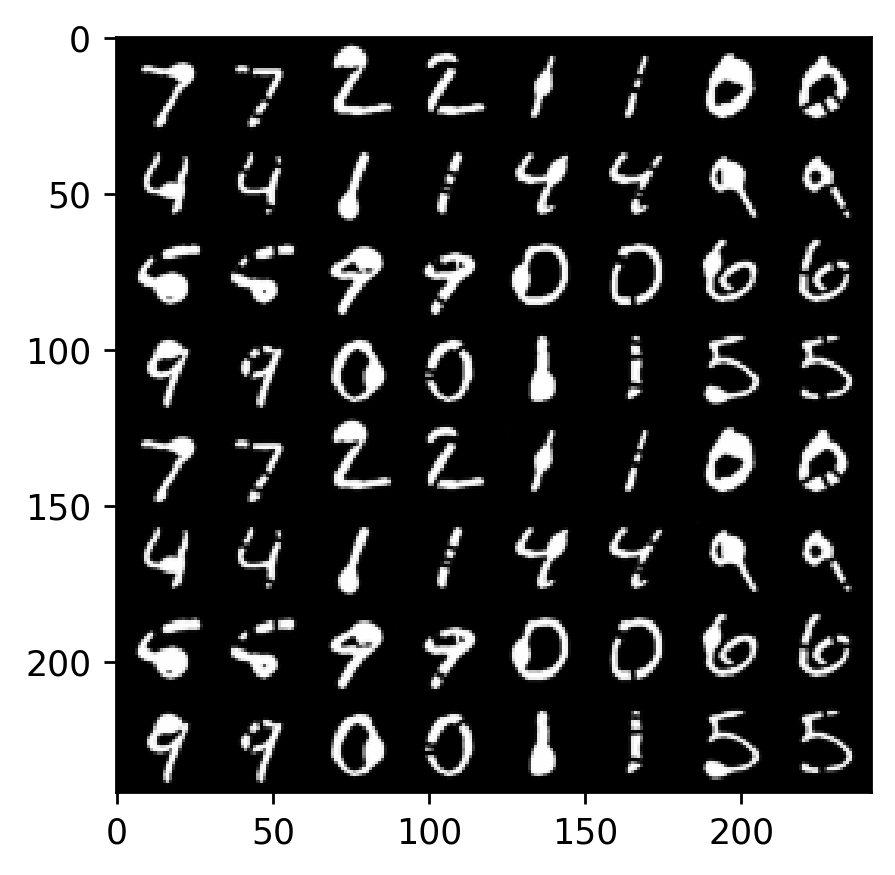

In [6]:
vqvae_exp.show_vqvae_recons(dpi=250, train=False)

In [ ]:
vqvae_exp.plot_vqvae_tsne(perplexity=30, n_iter=5000)

## Example dataset item

In [ ]:
from ccbir.data.morphomnist.dataset import PerturbedMorphoMNIST, SwollenMorphoMNIST, FracturedMorphoMNIST, PlainMorphoMNIST
from ccbir.models.twinnet.data import PSFTwinNetDataset
from deepscm.datasets.morphomnist import MorphoMNISTLike
import matplotlib.pyplot as plt
from ccbir.experiment.experiments import show_tensor
from functools import partial
from ccbir.data.dataset import BatchDict
from torchvision import transforms

#test_data_perturbed = FracturedMorphoMNIST(train=True, binarize=False)
#test_data_plain = PlainMorphoMNIST(train=False)
psf_dataset = PSFTwinNetDataset(embed_image=lambda x: x, train=False)
#plain = PlainMorphoMNIST(train=True)

swollen = SwollenMorphoMNIST(train=True)
"""
swollen = SwollenMorphoMNIST(train=True, transform=partial(
                BatchDict.map_feature,
                keys=['image'],
                func=transforms.Normalize(mean=0.5, std=0.5),
            ),)

"""
#print(swollen.get_items().map_feature(['image'], transforms.Normalize(0.5, 0.5)))

#show_tensor(test_data_plain[8]['image'], dpi=50)


"\nswollen = SwollenMorphoMNIST(train=True, transform=partial(\n                BatchDict.map_feature,\n                keys=['image'],\n                func=transforms.Normalize(mean=0.5, std=0.5),\n            ),)\n\n"

In [ ]:
from ccbir.models.twinnet.model import SimpleDeepTwinNetComponent
from torchinfo import summary
import torch

model = SimpleDeepTwinNetComponent(2, 16, 32, torch.Size((16, 7, 7)))
print(f"{model.input_dim=}")
summary(model.network, (64, 2 + 16 + 32))

model.input_dim=50


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Linear: 1-1                            [64, 128]                 6,528
├─LeakyReLU: 1-2                         [64, 128]                 --
├─Unflatten: 1-3                         [64, 128, 1, 1]           --
├─ConvTranspose2d: 1-4                   [64, 64, 3, 3]            73,792
├─LeakyReLU: 1-5                         [64, 64, 3, 3]            --
├─ConvTranspose2d: 1-6                   [64, 32, 5, 5]            18,464
├─LeakyReLU: 1-7                         [64, 32, 5, 5]            --
├─ConvTranspose2d: 1-8                   [64, 16, 7, 7]            4,624
Total params: 103,408
Trainable params: 103,408
Non-trainable params: 0
Total mult-adds (M): 86.97
Input size (MB): 0.01
Forward/backward pass size (MB): 1.17
Params size (MB): 0.41
Estimated Total Size (MB): 1.60

In [ ]:
from torchinfo import summary
import torch
from torch import nn


def Activation(): return nn.SiLU(inplace=True)

class ResBlock(nn.Module):
    def __init__(self, dim, activation=lambda: nn.ReLU(True)):
        super().__init__()
        self.block = nn.Sequential(
            activation(),
            nn.Conv2d(dim, dim, 3, 1, 1),
            nn.BatchNorm2d(dim),
            activation(),
            nn.Conv2d(dim, dim, 1),
            nn.BatchNorm2d(dim)
        )

    def forward(self, x):
        return x + self.block(x)


dim = 16 * 7 * 7
print('Works')
net = nn.Sequential(
    nn.Unflatten(1, (-1, 1, 1)),
    nn.LazyConvTranspose2d(128, 3),
    nn.LazyConvTranspose2d(128, 3),
    nn.LazyConvTranspose2d(128, 3),
    nn.LazyConvTranspose2d(128, 3),
    ResBlock(128),
    ResBlock(128),
    ResBlock(128),
    nn.LazyConv2d(2, 2),
)
input_shape = (64, 2 + 16 + 32)
print(f"{input_shape=}")
summary(net, input_shape)

Works
input_shape=(64, 50)


/vol/bitbucket/mb8318/ccbir_venv/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [7]:
from ccbir.experiment.experiments import PSFTwinNetExperiment
from ccbir.models.vqvae.model import VQVAE
#from ccbir.models.twinnet.model_gpu2_taitam import PSFTwinNet
from ccbir.models.twinnet.model import PSFTwinNet
from ccbir.models.util import load_best_model, best_model_checkpoint_path
import torch

vqvae = load_best_model(VQVAE)
checkpoint = torch.load(best_model_checkpoint_path(VQVAE))
print(f"{checkpoint=}")

twinnet = PSFTwinNet.load_from_checkpoint(
    '/vol/bitbucket/mb8318/ccbir/logs/tb_logs/twinnet/version_144/checkpoints/last.ckpt'
    #'/vol/bitbucket/mb8318/ccbir/logs/tb_logs/twinnet/version_114/checkpoints/last.ckpt'
    #'/vol/bitbucket/mb8318/ccbir/logs/tb_logs/twinnet/version_80/checkpoints/twinnet-epoch=1010-val_loss=9.3478222.ckpttwinnet-epoch=981-val_loss=9.5853806.ckpt'
    #'/vol/bitbucket/mb8318/ccbir/logs/tb_logs/twinnet/version_53/checkpoints/twinnet-epoch=115-val_loss=56.2798500.ckpt'
    #'/vol/bitbucket/mb8318/ccbir/logs/tb_logs/twinnet/version_47/checkpoints/twinnet-epoch=082-val_loss=68.0407639.ckpt'
    #'/vol/bitbucket/mb8318/ccbir/logs/tb_logs/twinnet/version_47/checkpoints/last.ckpt'
    #'/vol/bitbucket/mb8318/ccbir/logs/tb_logs/twinnet/version_37/checkpoints/last.ckpt'
    #'/homes/mb8318/Documents/year4/ccbir/lightning_logs/version_126/checkpoints/last.ckpt'
    #'/homes/mb8318/Documents/year4/ccbir/lightning_logs/version_121/checkpoints/last.ckpt'
    #'/homes/mb8318/Documents/year4/ccbir/assets/checkpoints/psftwinnet/version_115/checkpoints/last.ckpt'
    #'/homes/mb8318/Documents/year4/ccbir/lightning_logs/version_115/checkpoints/last.ckpt'
    #'/homes/mb8318/Documents/year4/ccbir/lightning_logs/version_114/checkpoints/last.ckpt'
    #'/homes/mb8318/Documents/year4/ccbir/lightning_logs/version_75/checkpoints/last.ckpt'
    #'/homes/mb8318/Documents/year4/ccbir/lightning_logs/version_66/checkpoints/last.ckpt'
)
twinnet.eval()

exp = PSFTwinNetExperiment(
    vqvae=vqvae,
    twinnet=twinnet,
)


Loaded <class 'ccbir.models.vqvae.model.VQVAE'> from path=PosixPath('/homes/mb8318/Documents/year4/ccbir/assets/checkpoints/vqvae/best.ckpt')
checkpoint={'epoch': 388, 'global_step': 2625750, 'pytorch-lightning_version': '1.6.0', 'state_dict': OrderedDict([('model.encoder.0.weight', tensor([[[[-6.6274e-02, -7.9998e-02,  6.1277e-02,  2.6657e-02],
          [ 9.7909e-02,  2.4627e-01,  6.2056e-03,  7.5411e-03],
          [-1.6609e+00,  1.3632e+00, -3.9943e-01, -2.3294e-02],
          [-8.6993e-01,  1.3050e+00, -2.7708e-01, -1.0774e-02]]],


        [[[-7.0134e-02, -2.4548e-01, -3.1823e-01, -1.7073e-01],
          [-1.9055e-01,  8.4071e-02,  1.5258e+00, -7.1801e-01],
          [-3.0076e-01,  6.9727e-01,  8.8261e-01, -9.1112e-01],
          [-1.6760e-01,  5.3575e-01,  4.0768e-01, -7.5275e-02]]],


        [[[-2.3770e-02,  4.1950e-01,  1.4474e-01, -1.2072e-01],
          [ 5.6161e-01, -1.0091e+00,  8.8317e-02,  1.3705e-01],
          [-1.0669e+00, -3.1282e+00, -1.2972e+00,  3.9014e-01],
    

/vol/bitbucket/mb8318/ccbir_venv/lib/python3.8/site-packages/torch/nn/functional.py:3669: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


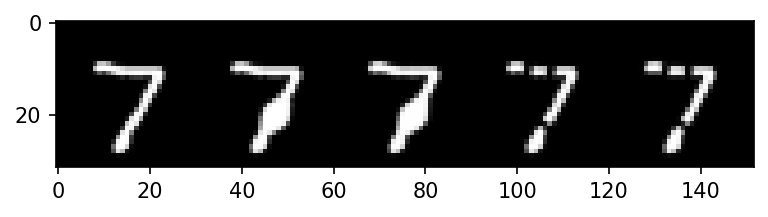

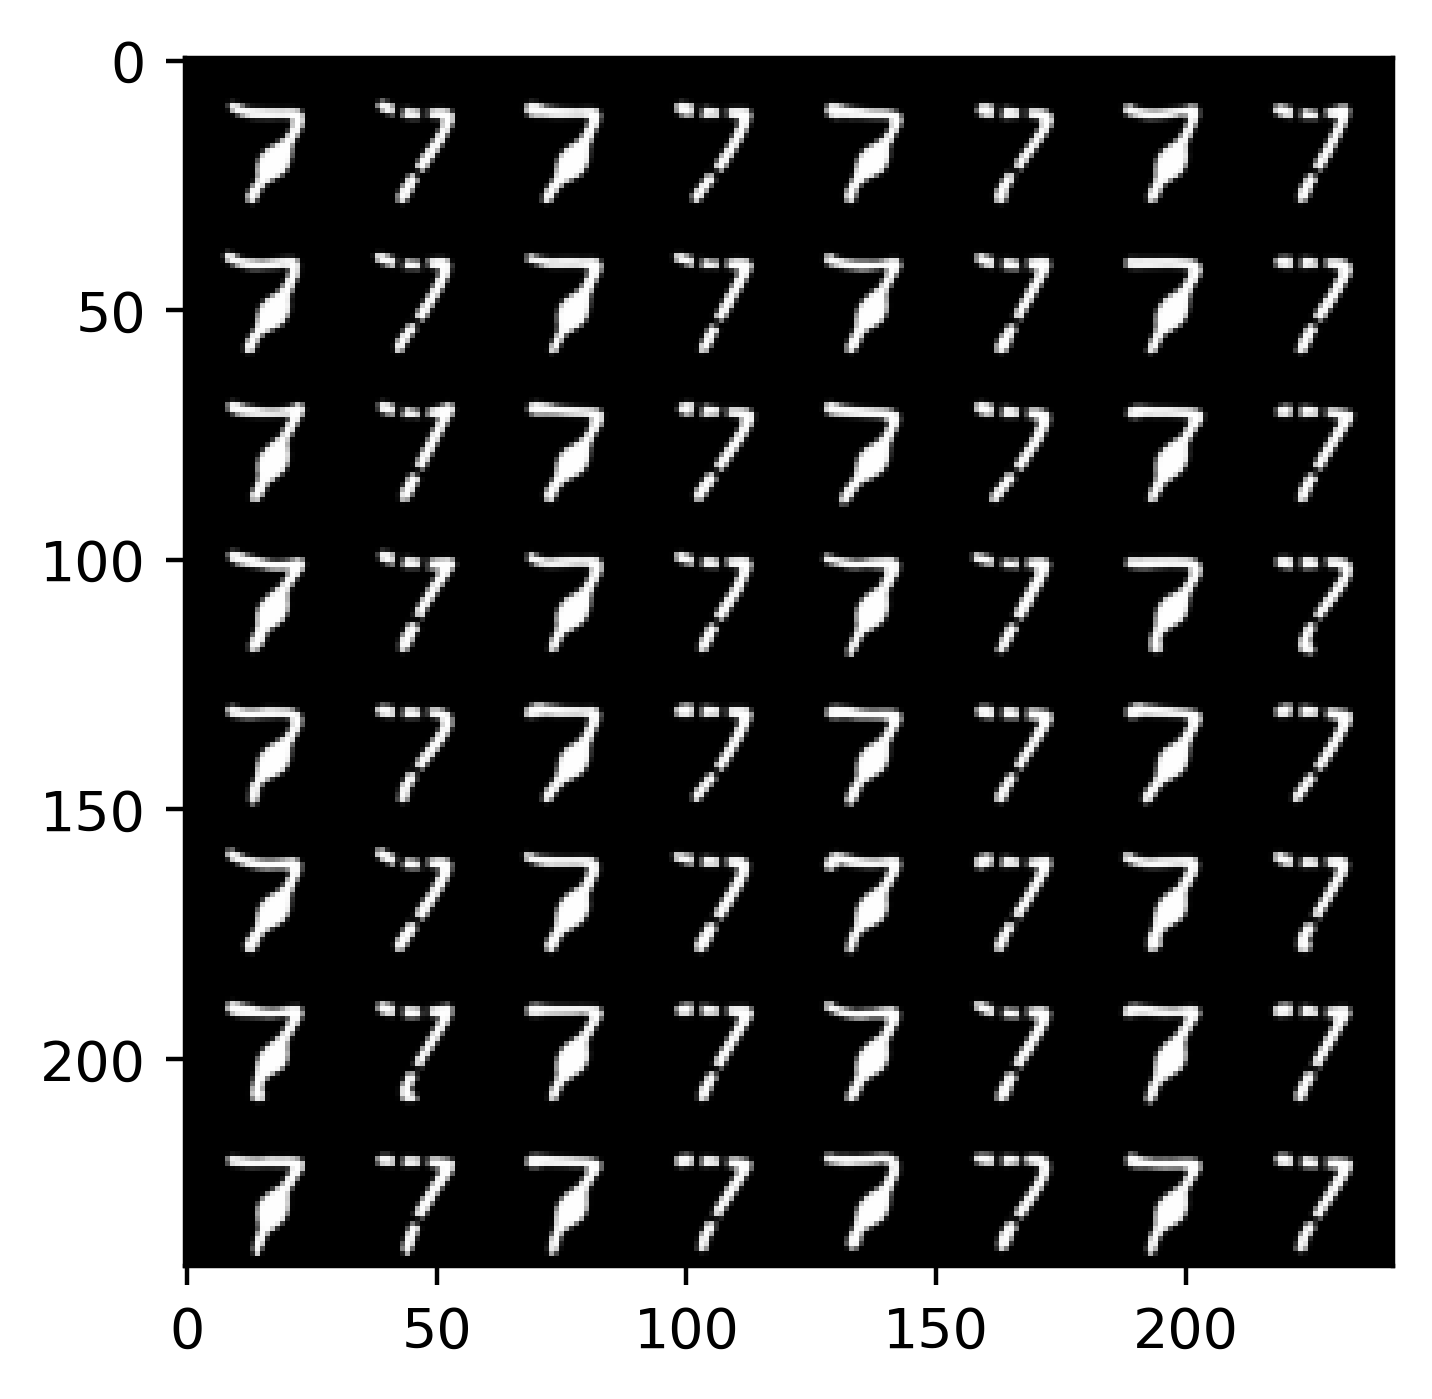

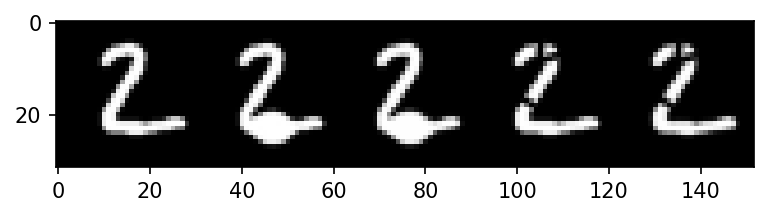

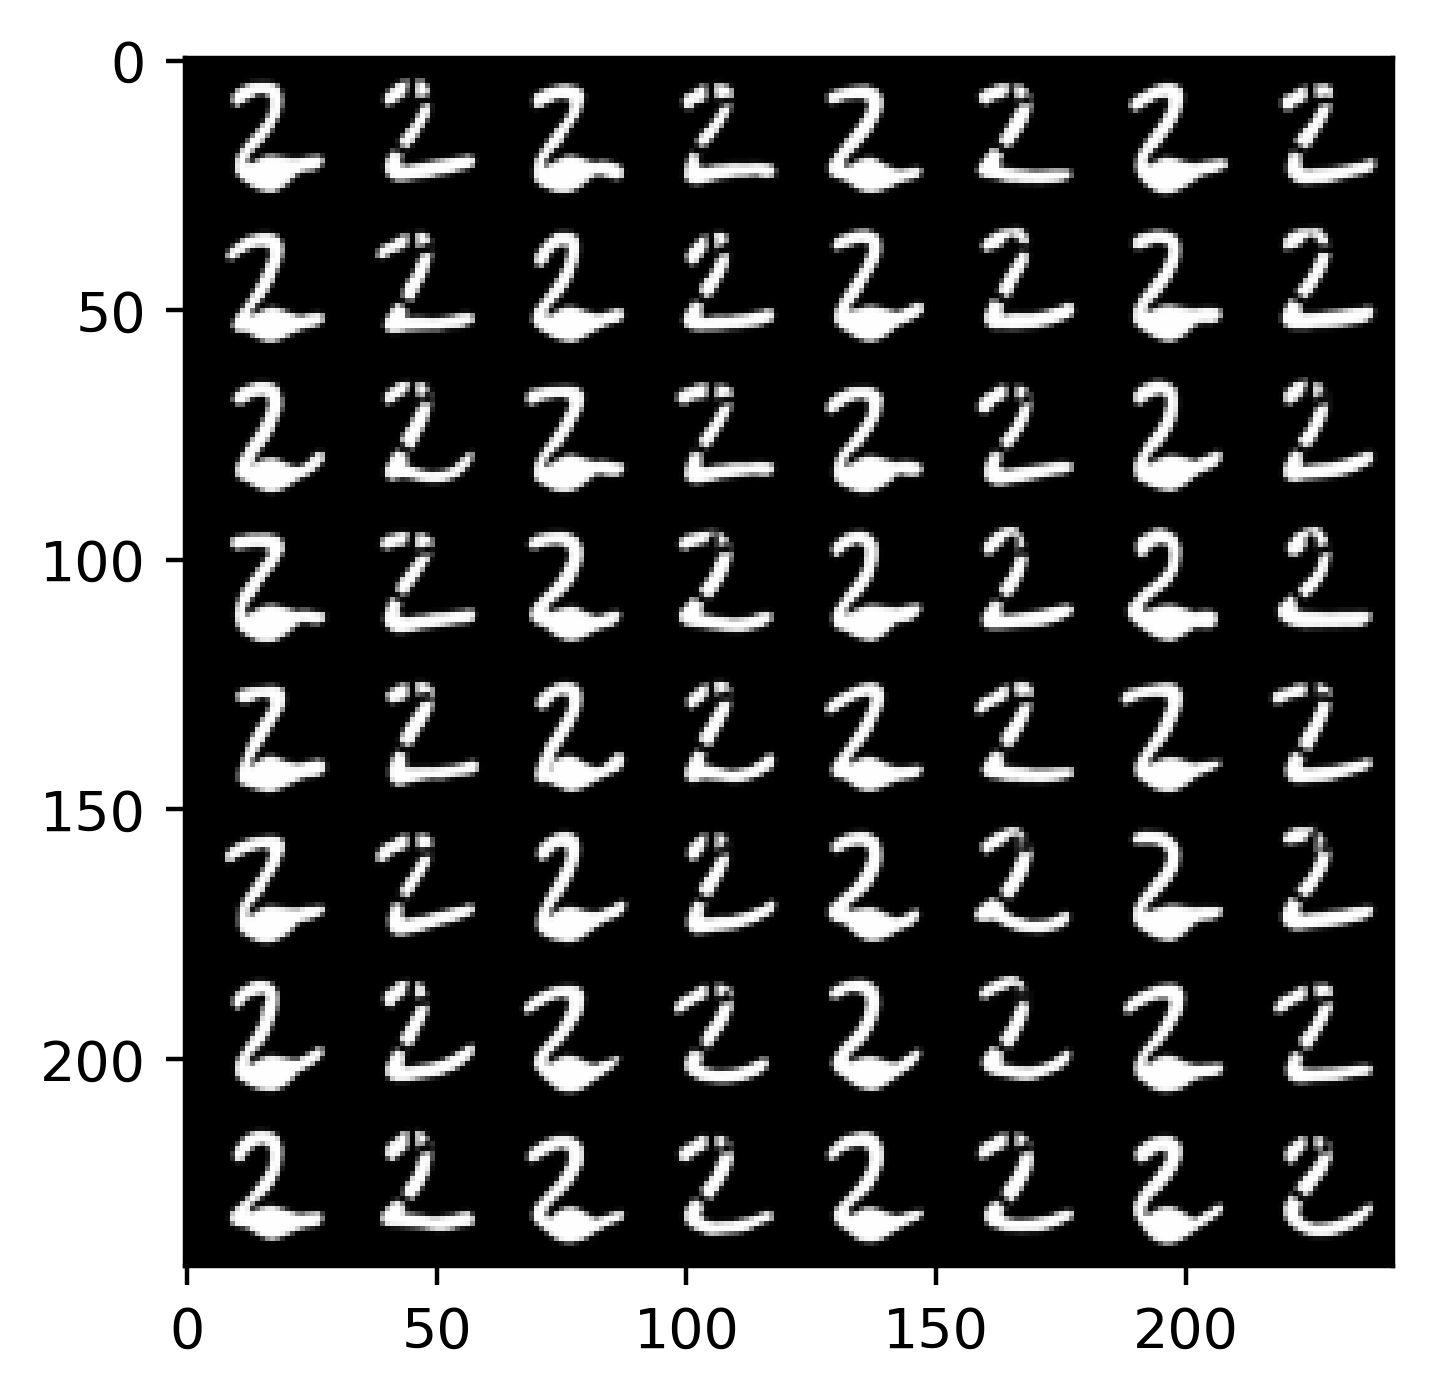

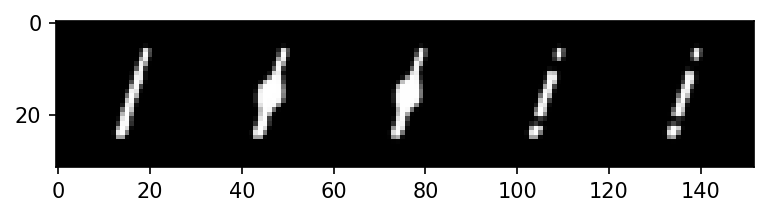

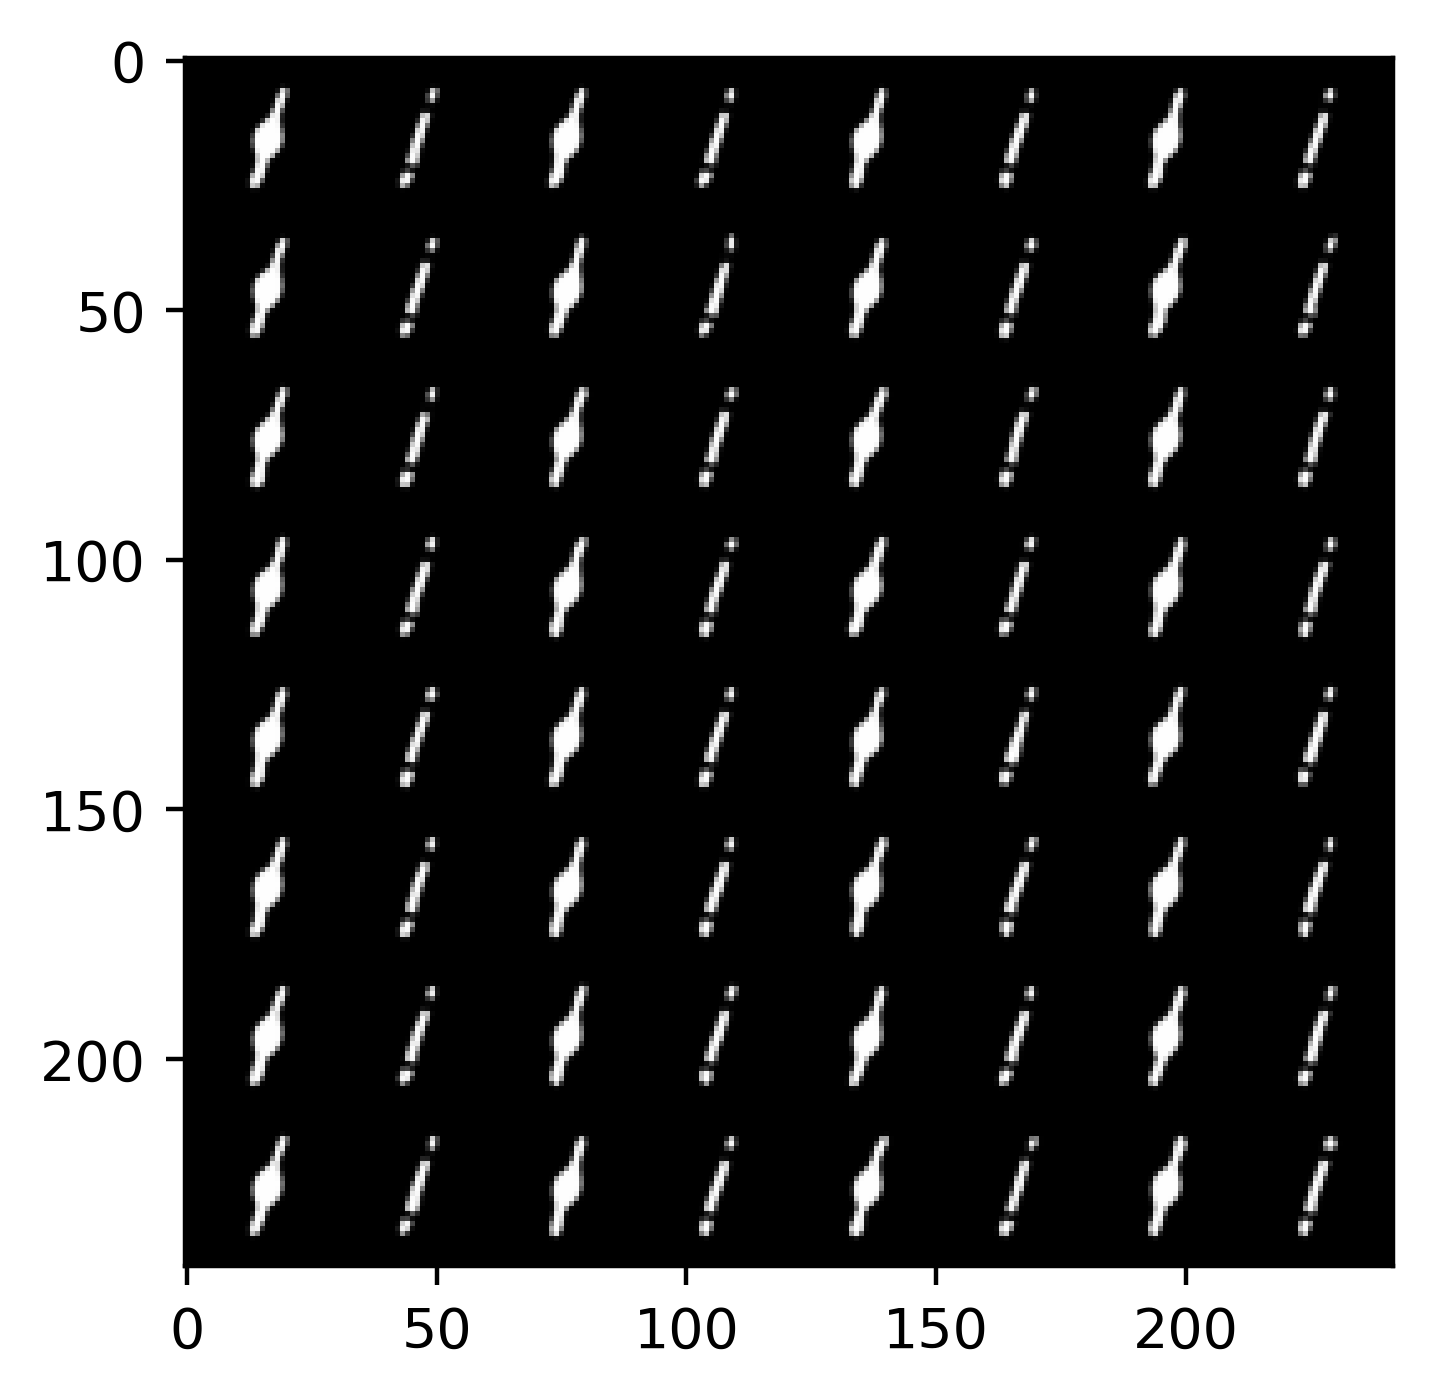

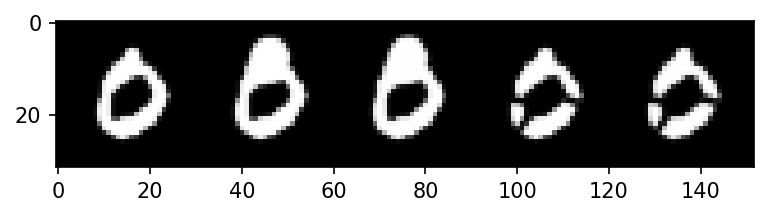

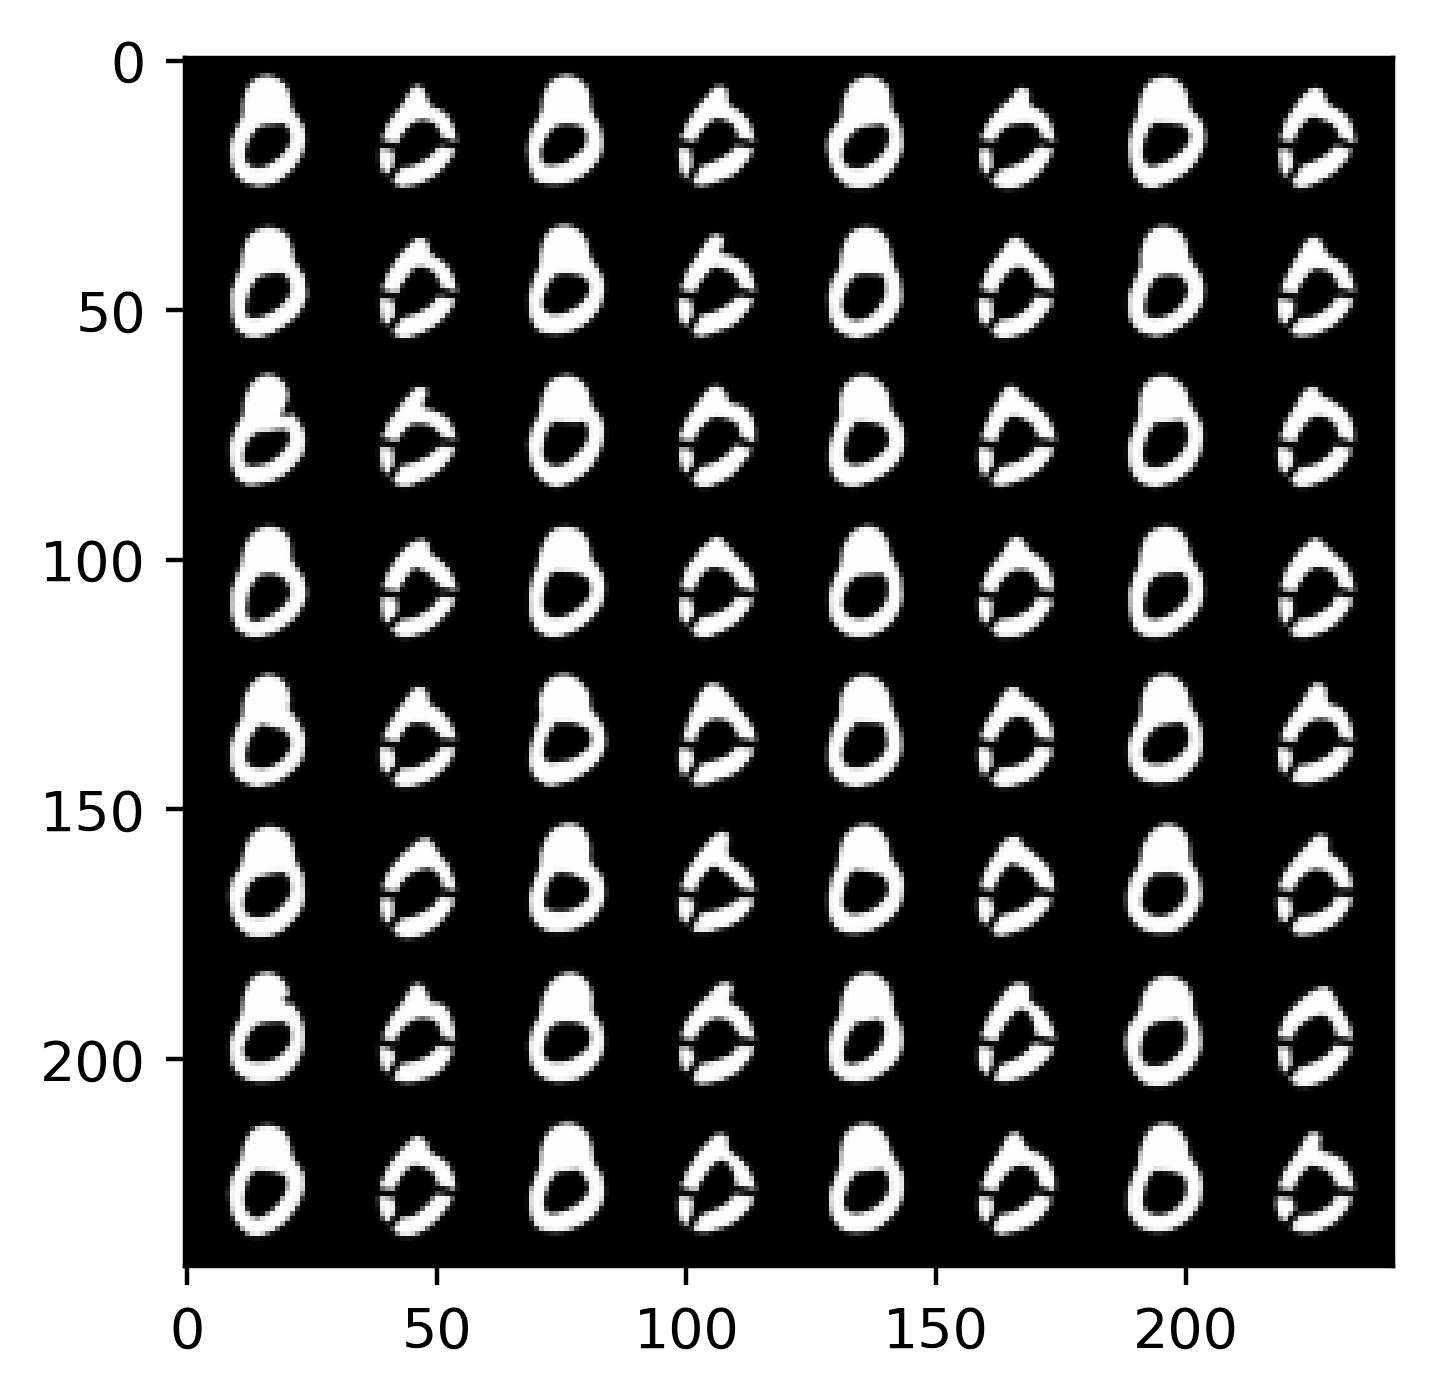

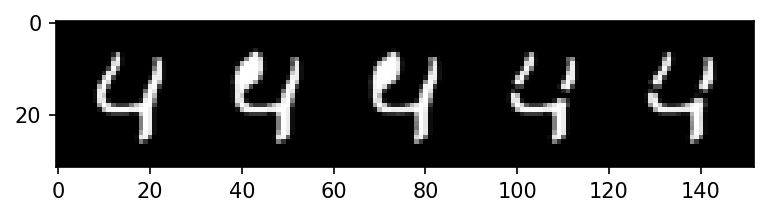

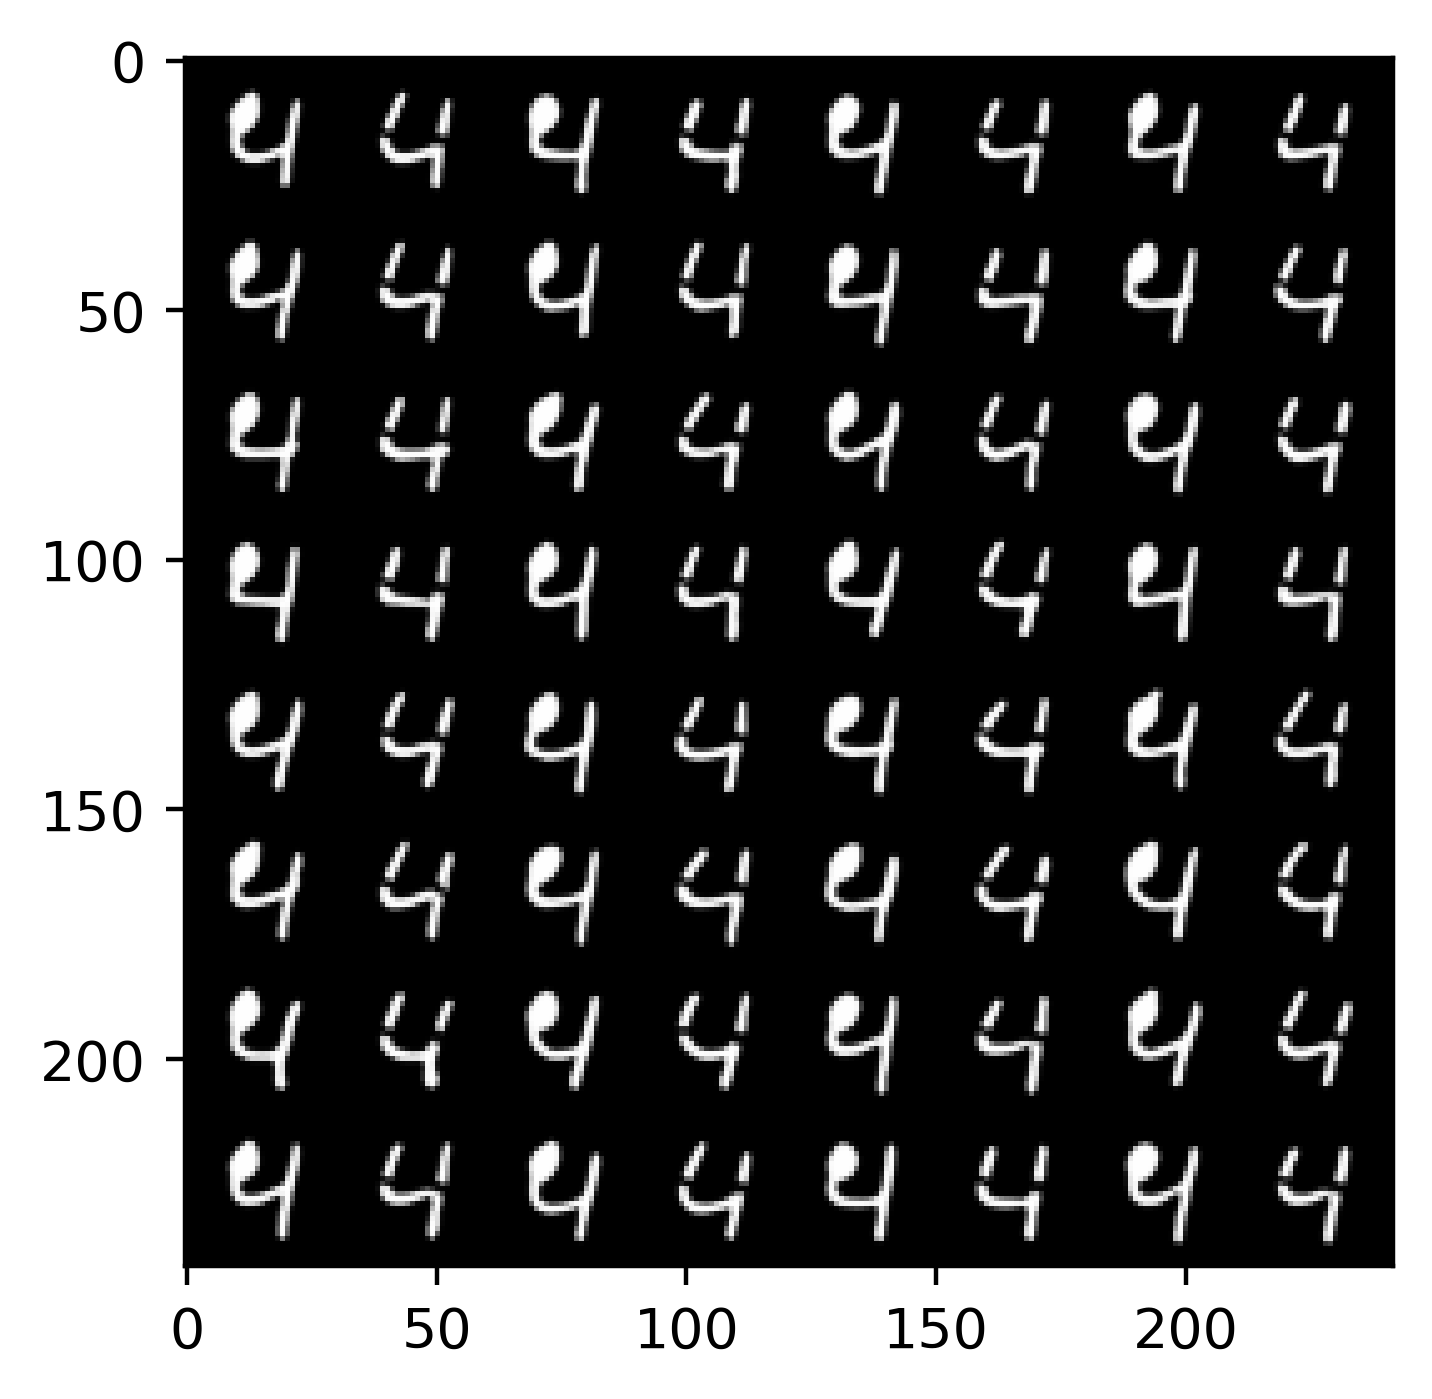

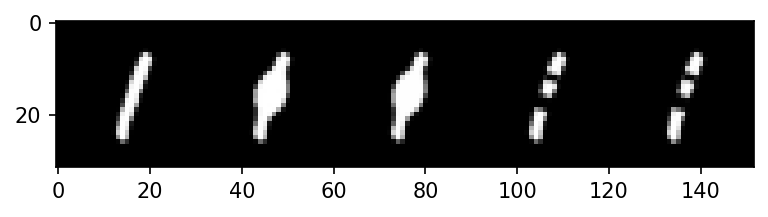

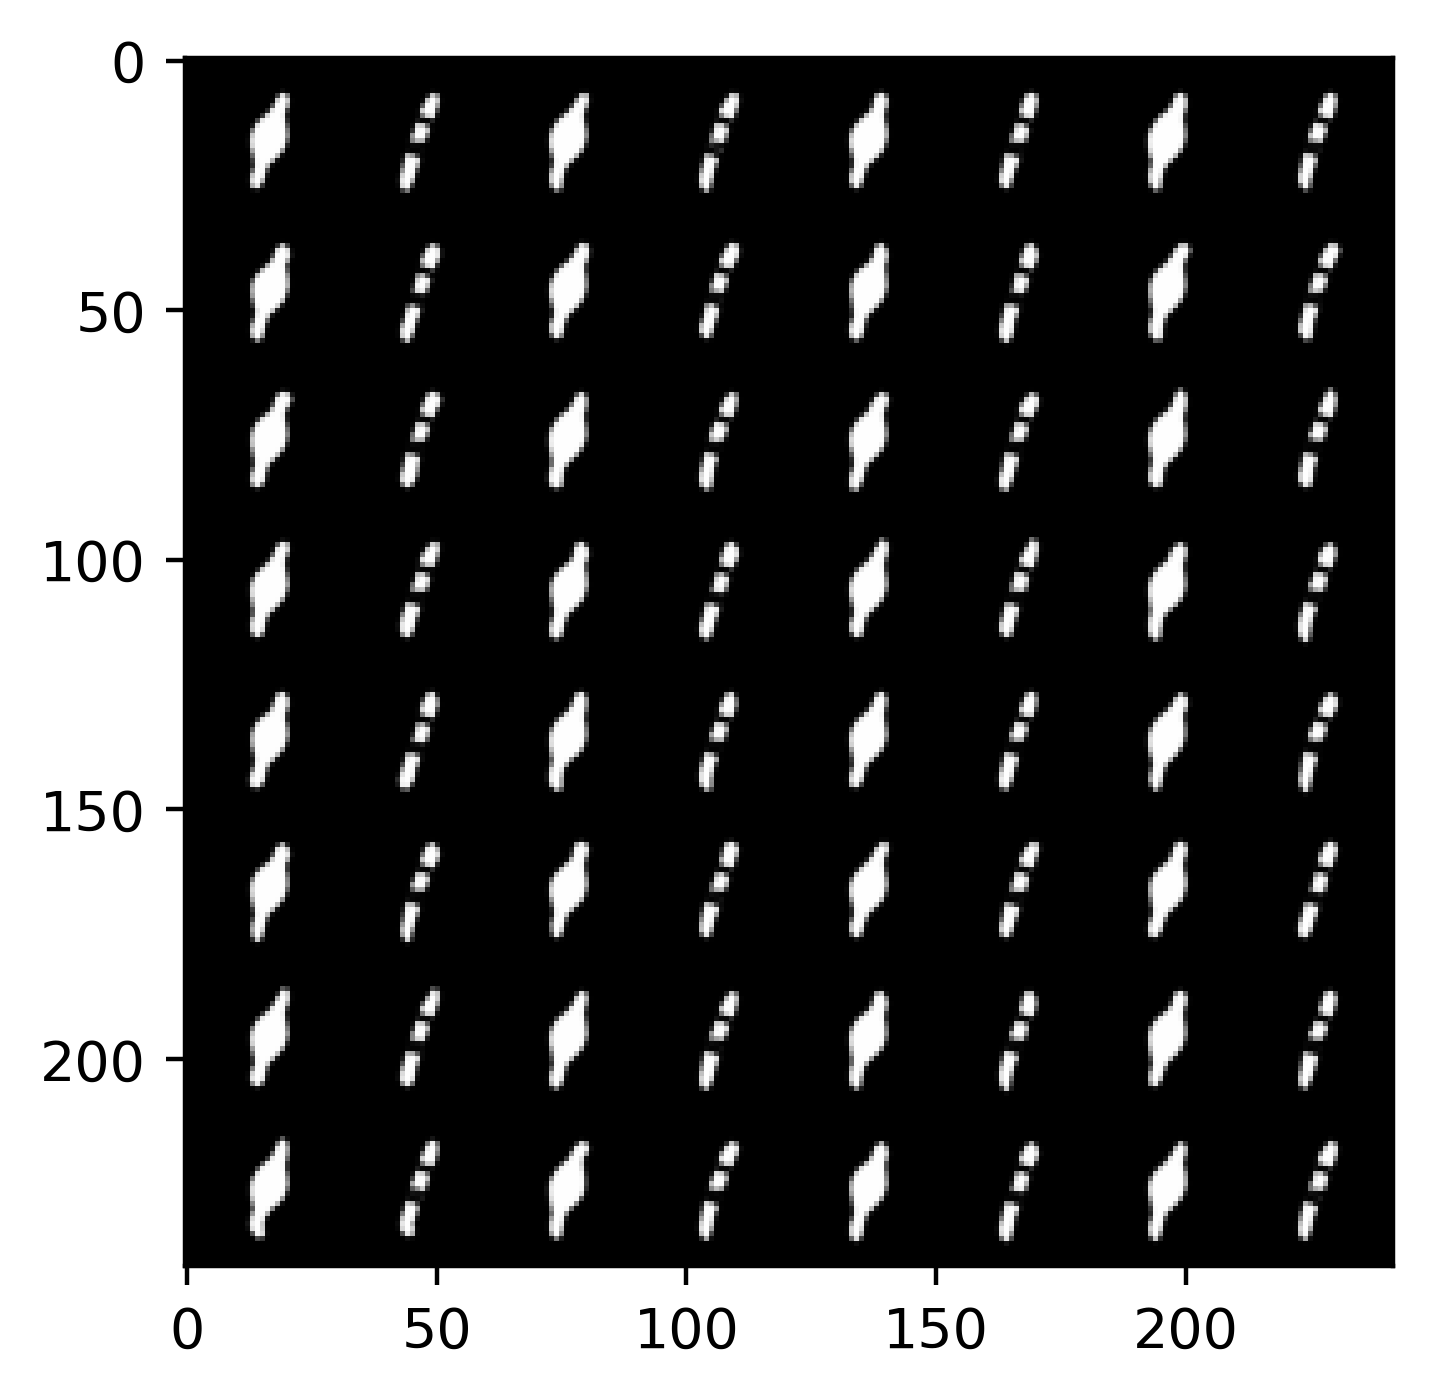

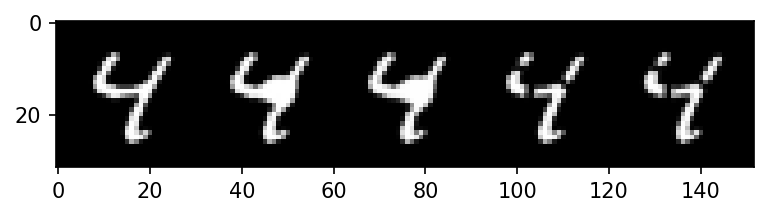

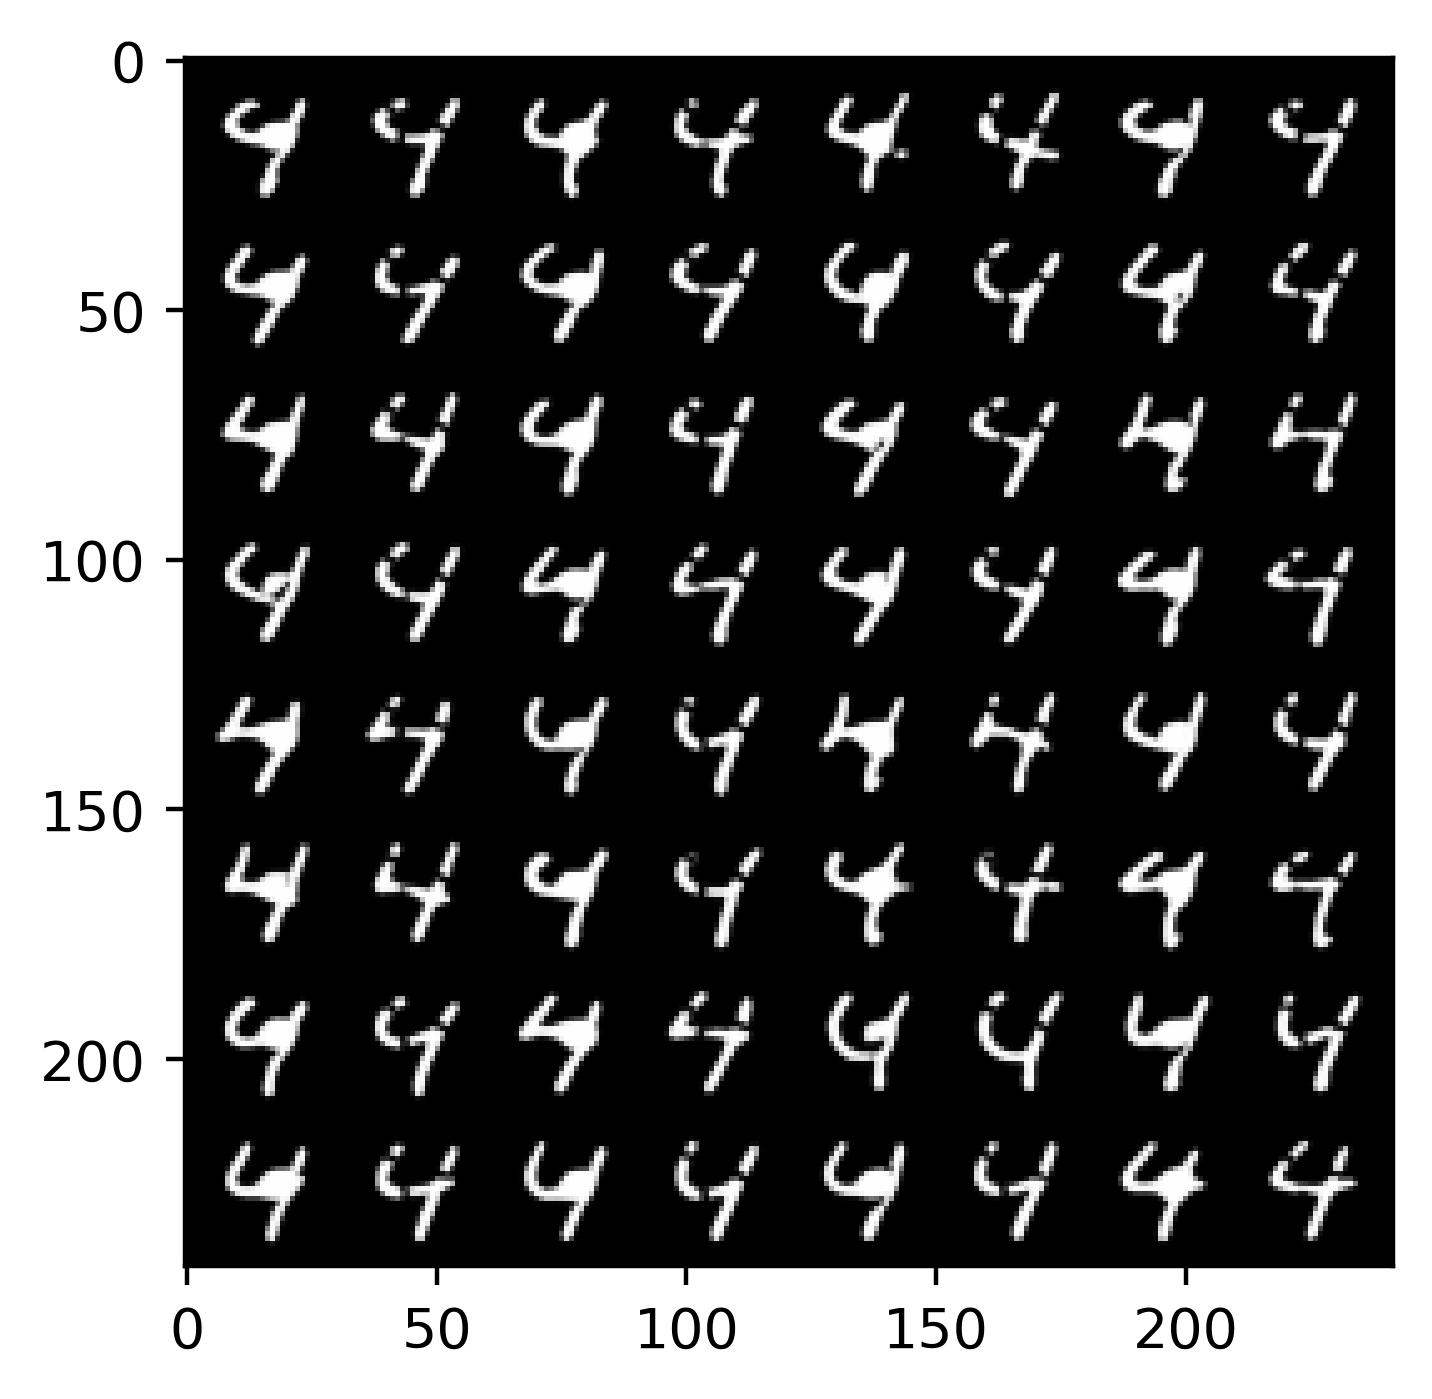

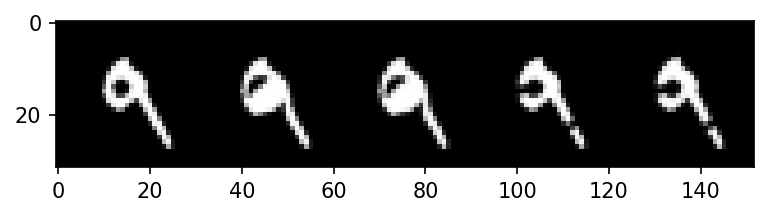

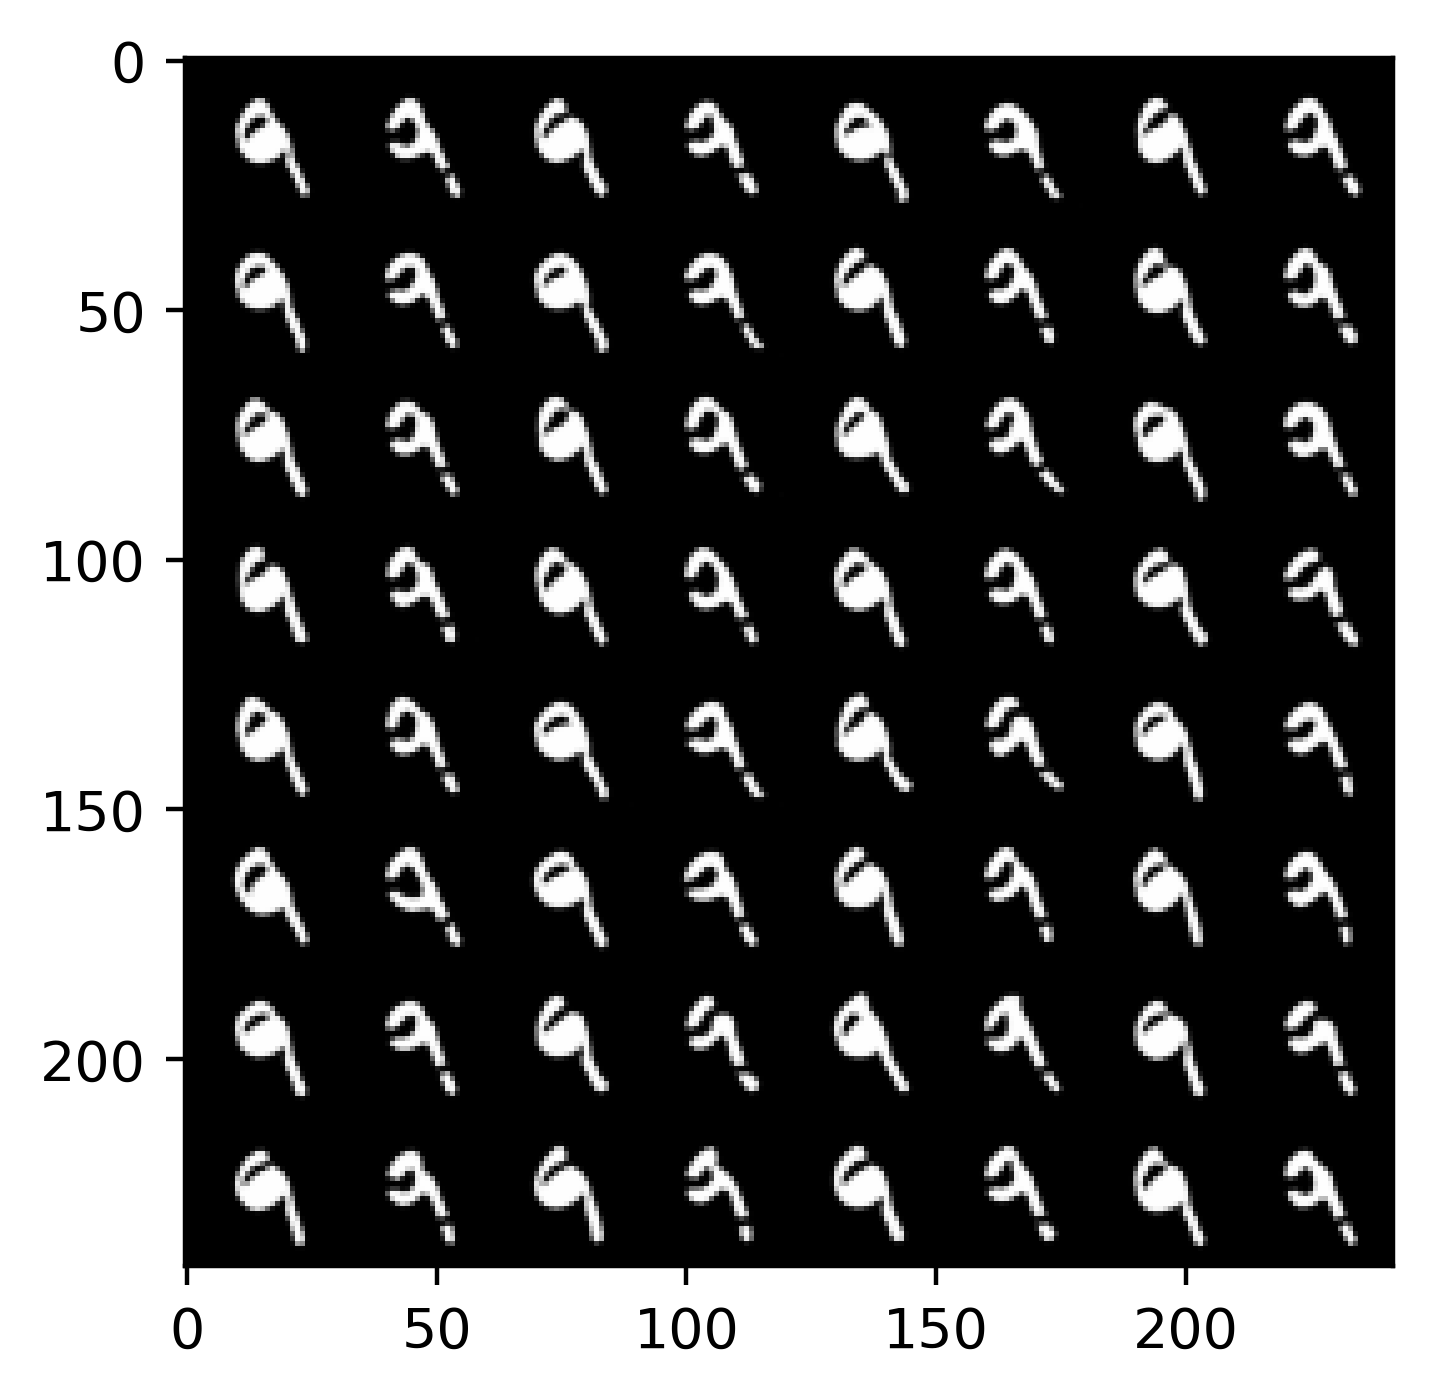

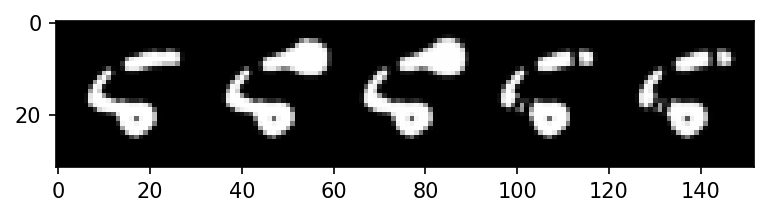

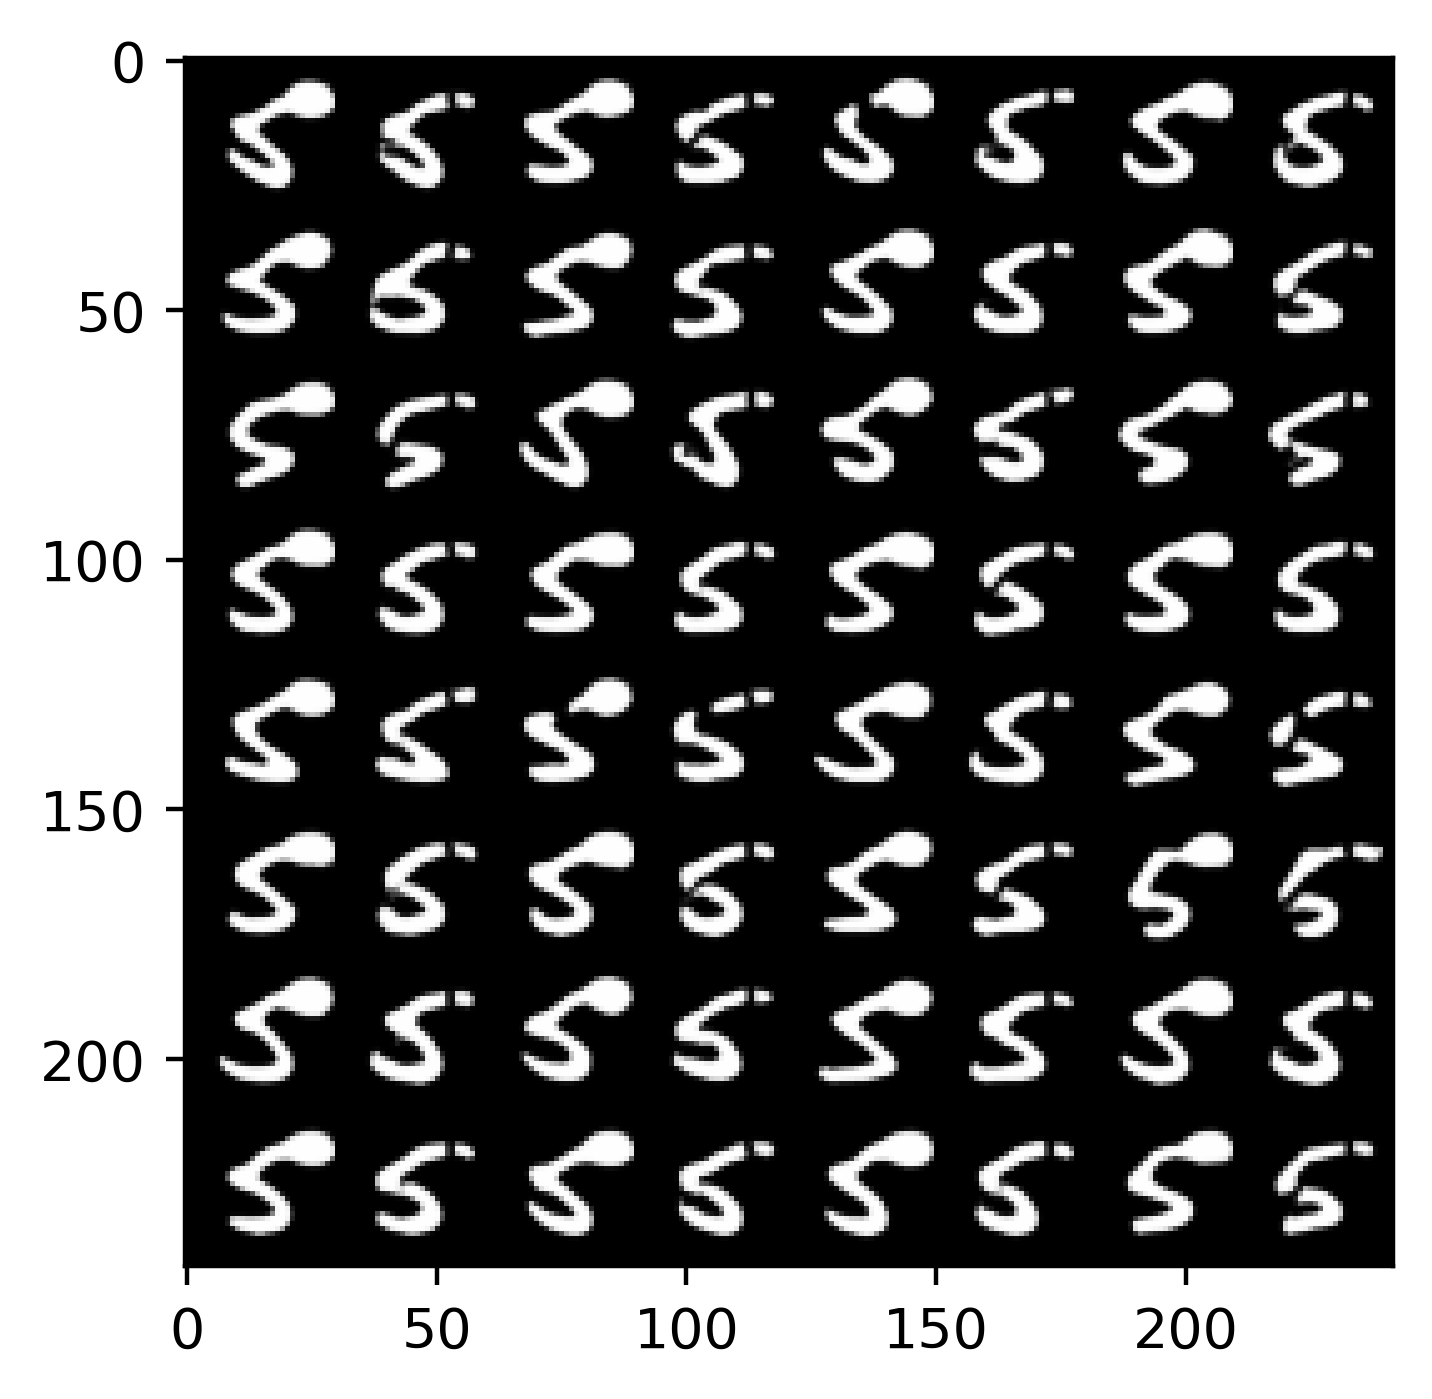

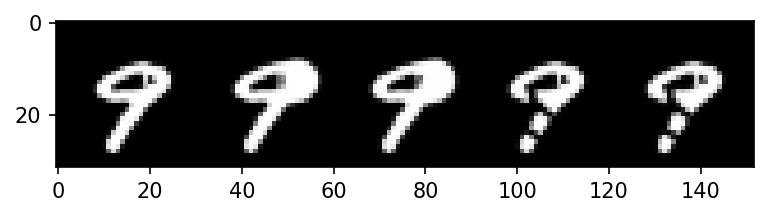

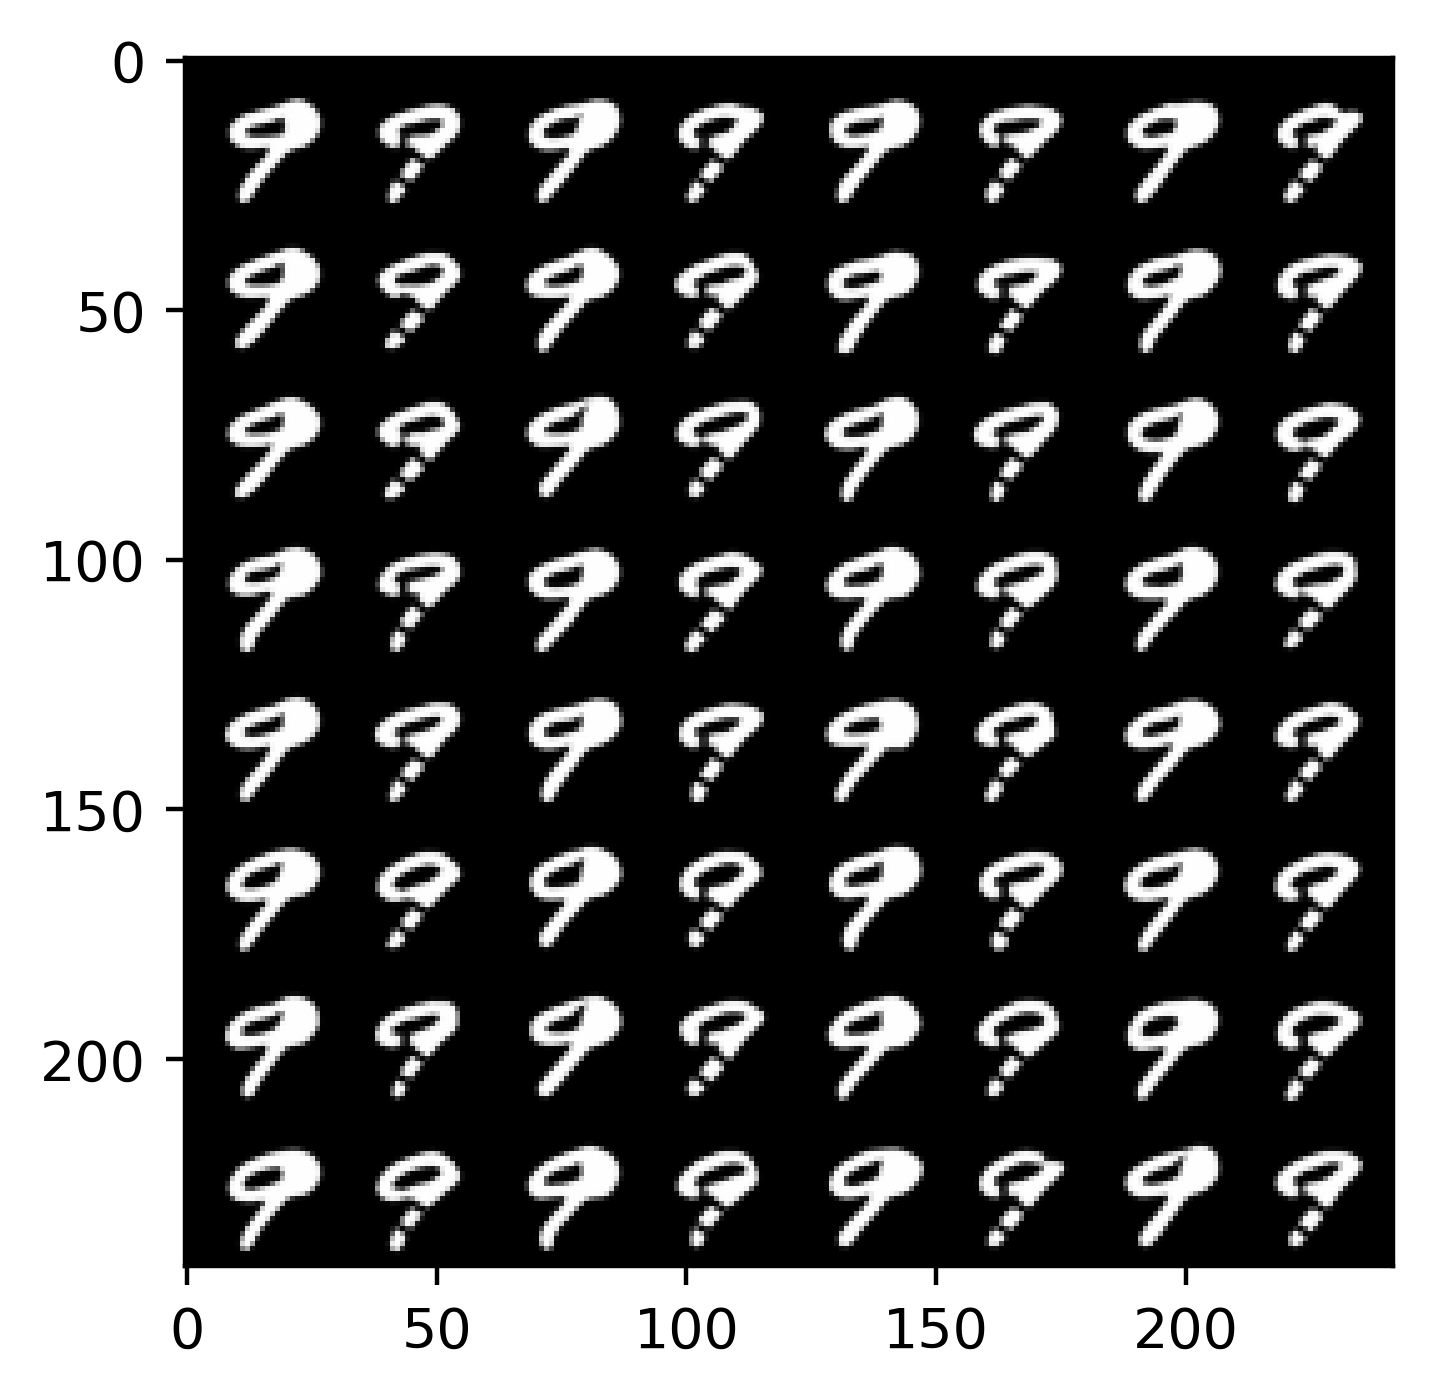

In [10]:
# 1, 35 
for sample_idx in range(10):
    exp.show_twinnet_samples(sample_idx, noise_scale=1, top_k=32, num_samples=4096, train=False, dpi=400, condition_on_factual_outcome=True)

/homes/mb8318/Documents/year4/ccbir/ccbir/experiment/util.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=dpi)


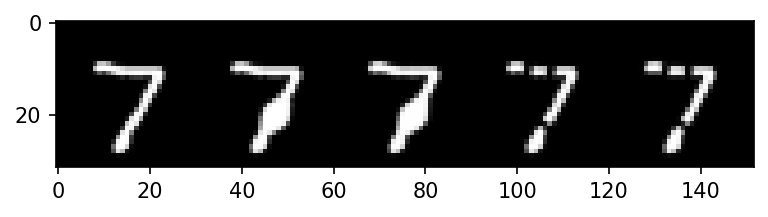

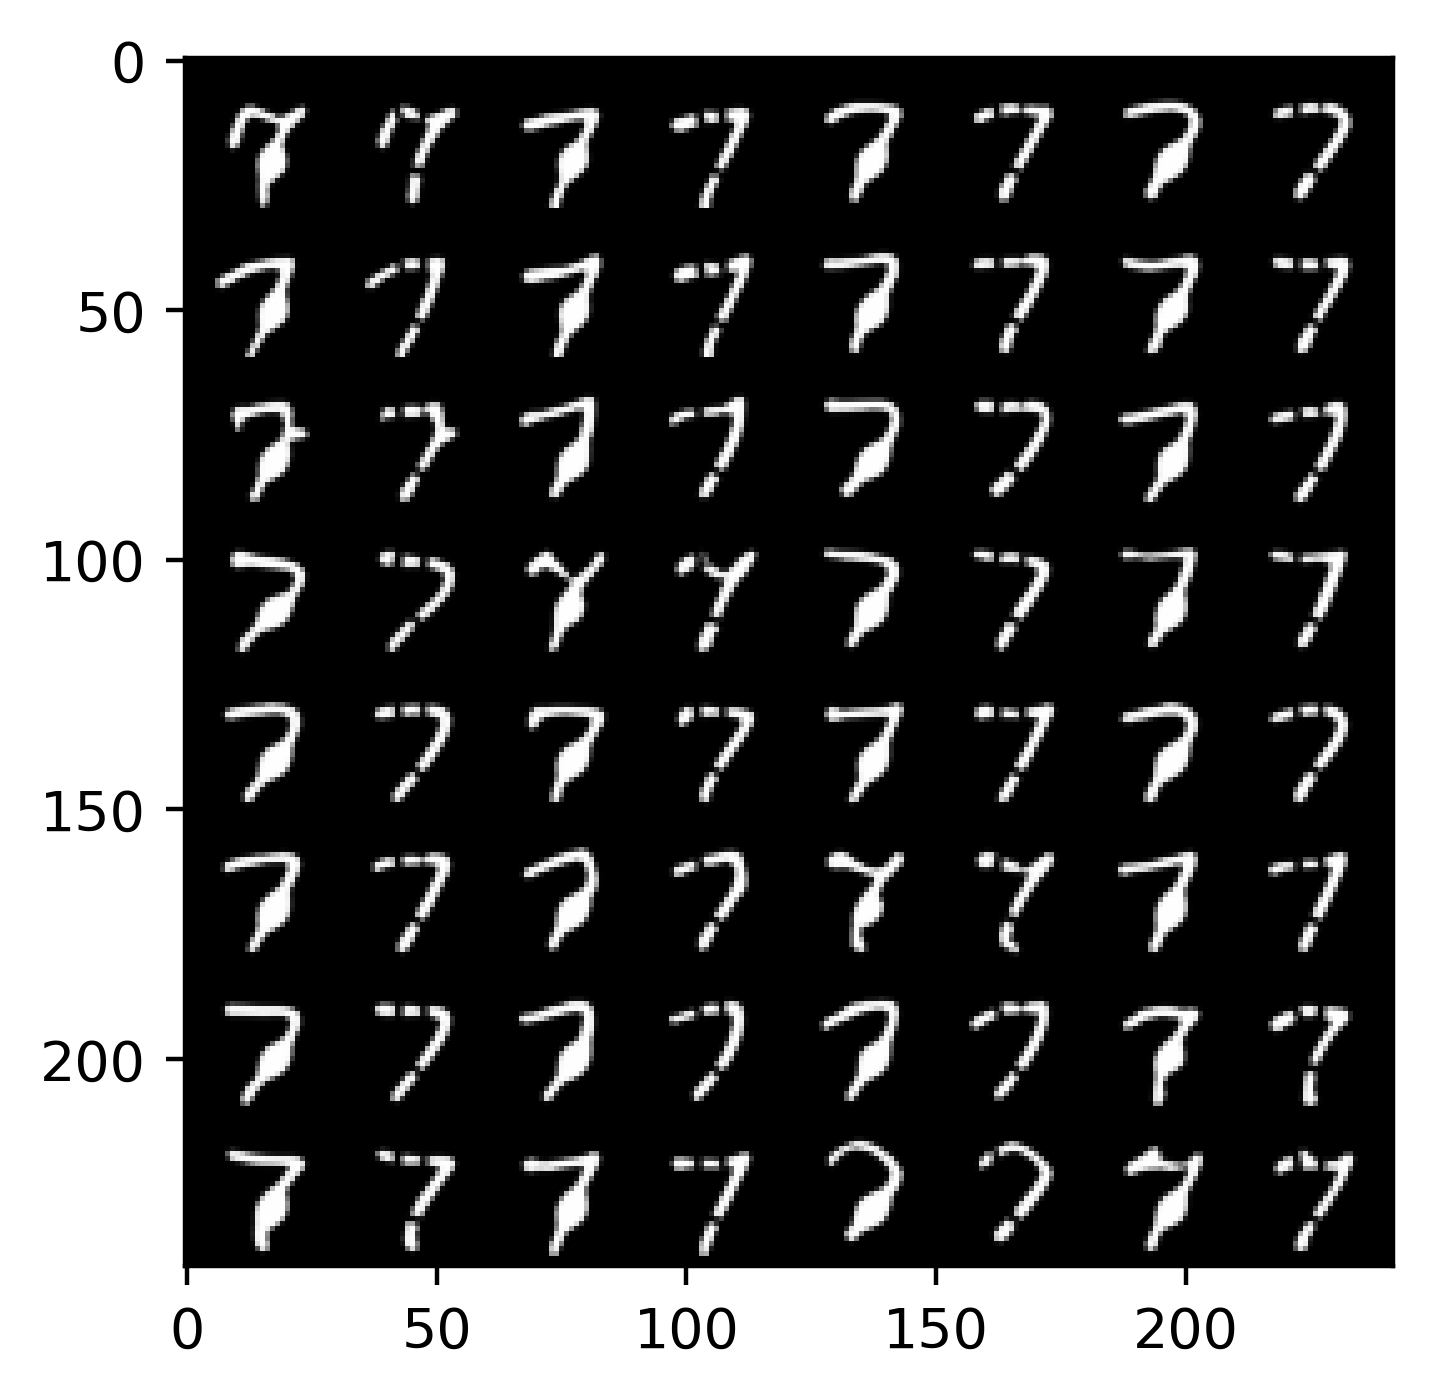

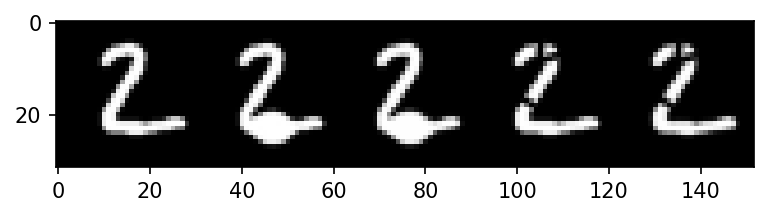

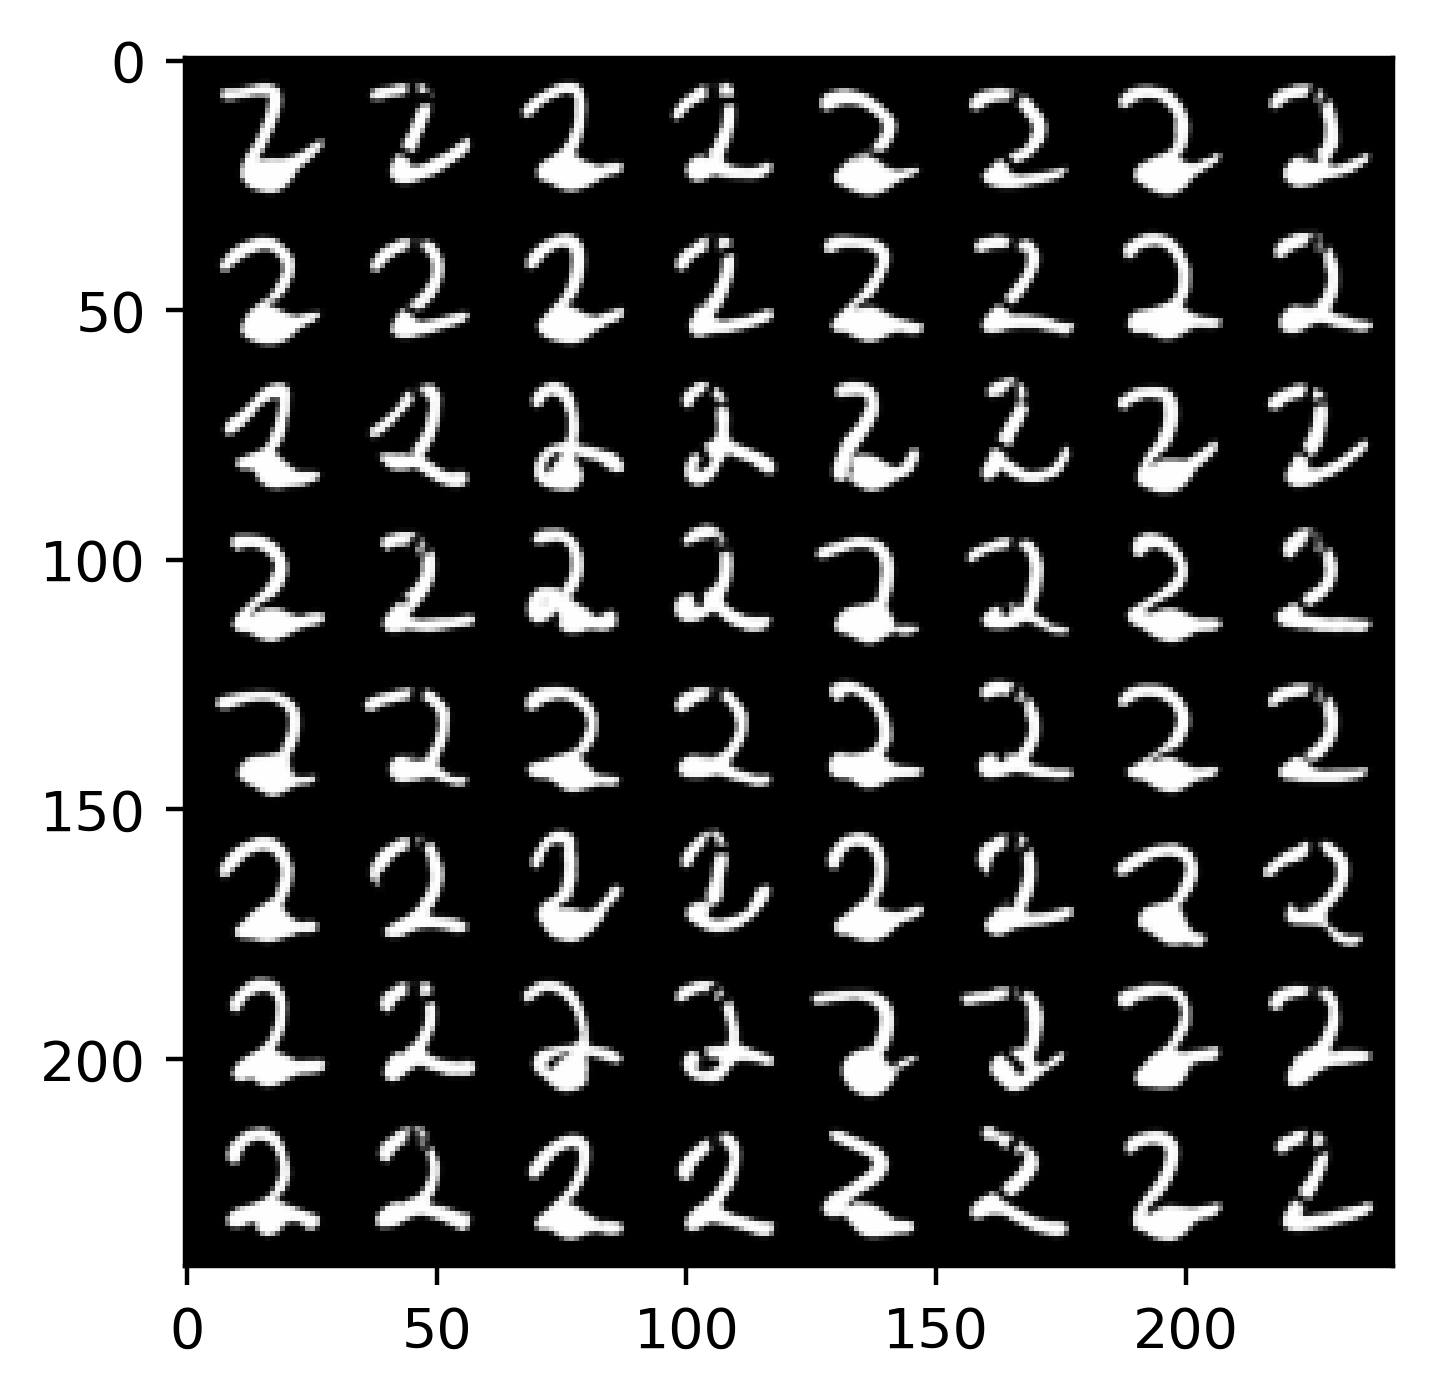

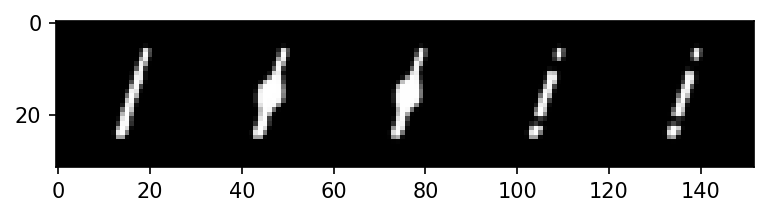

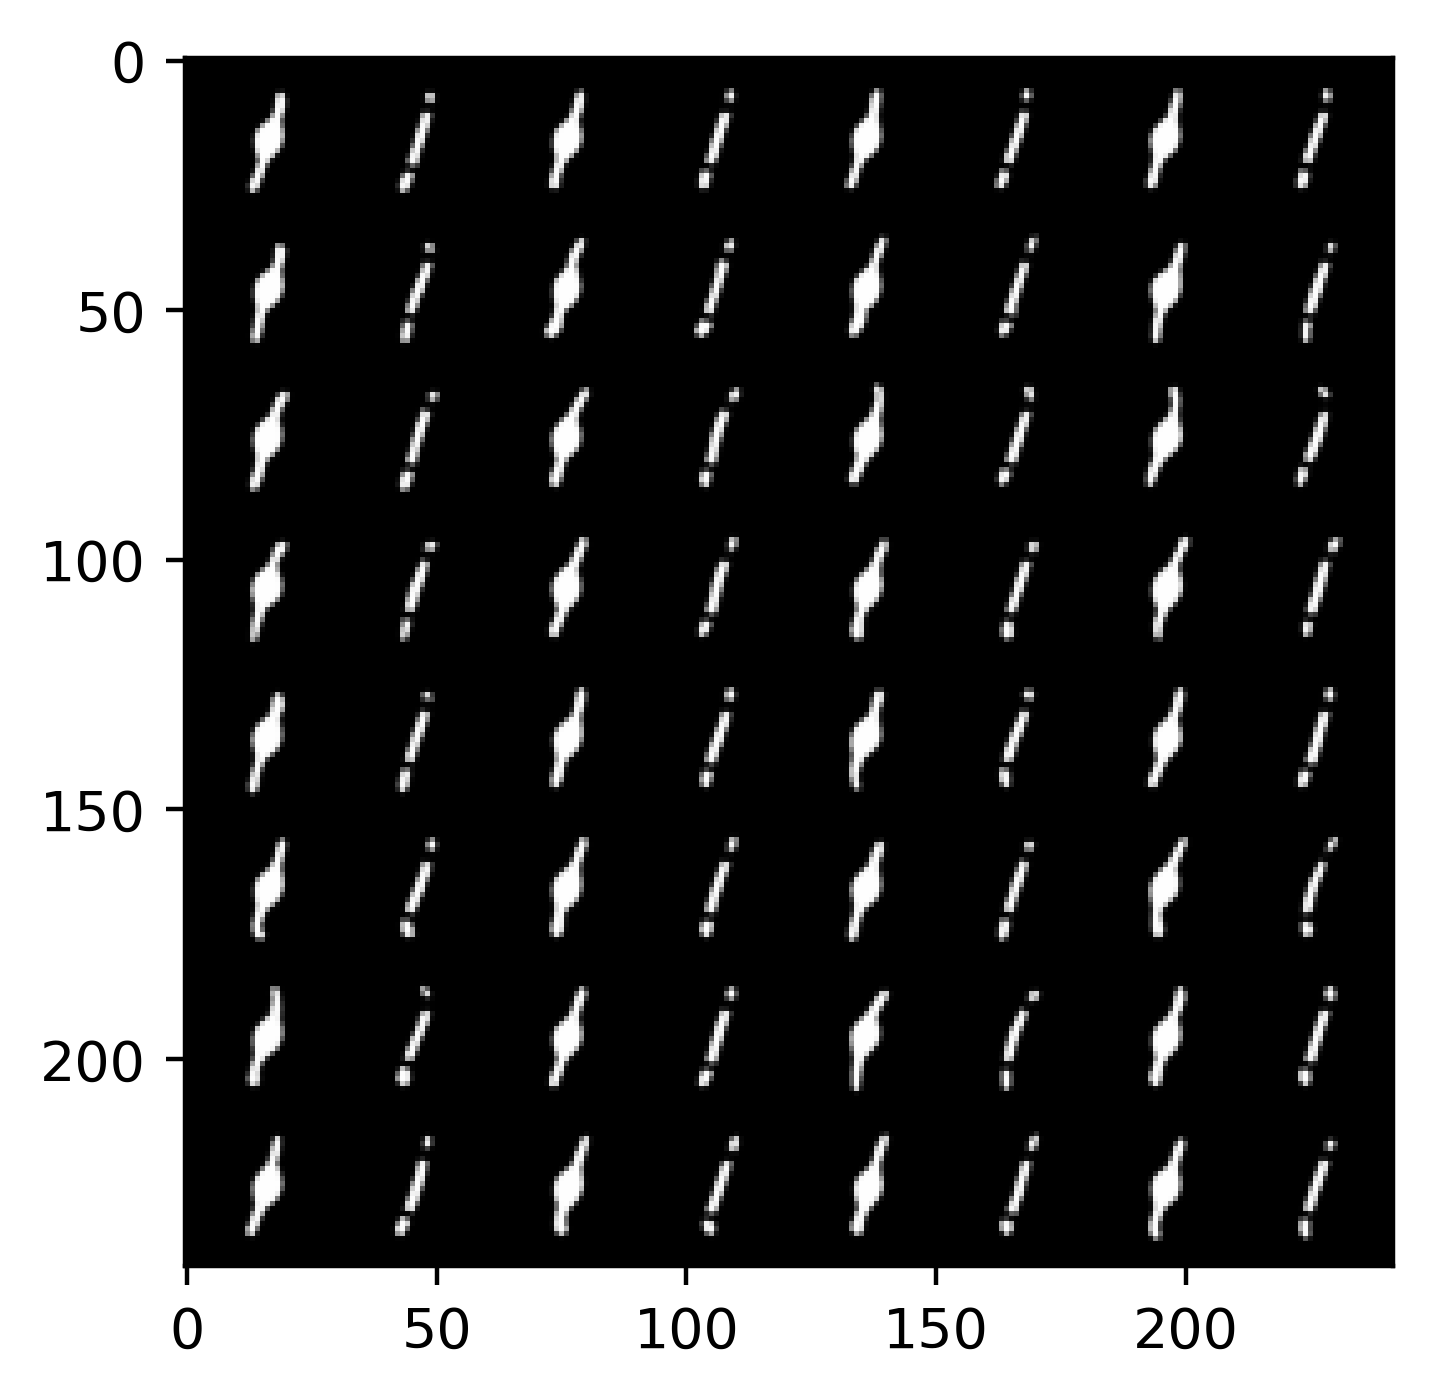

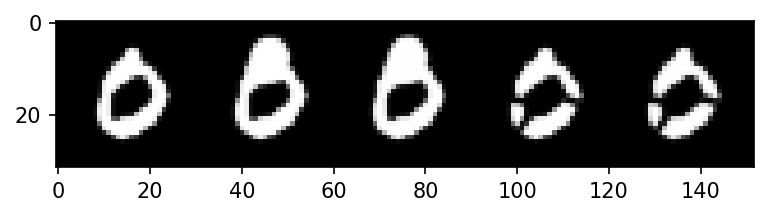

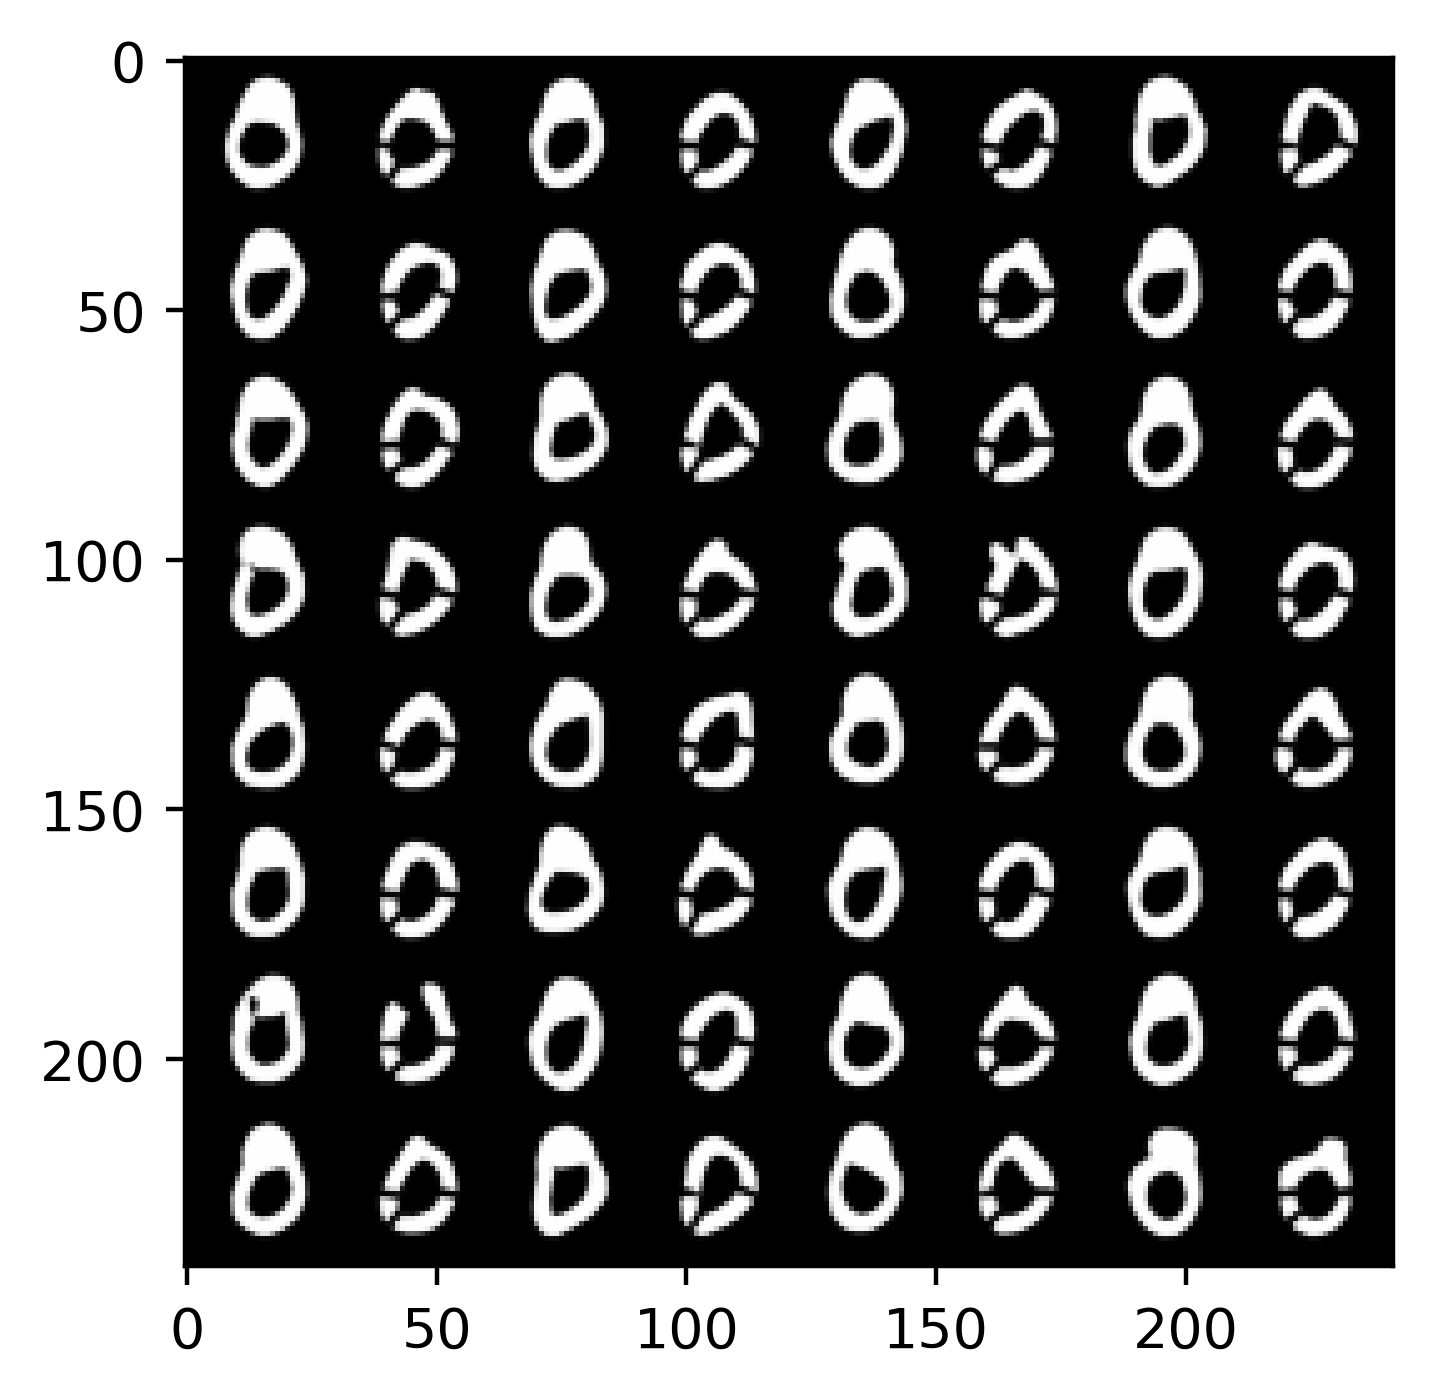

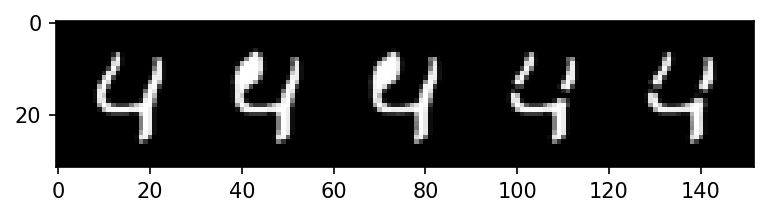

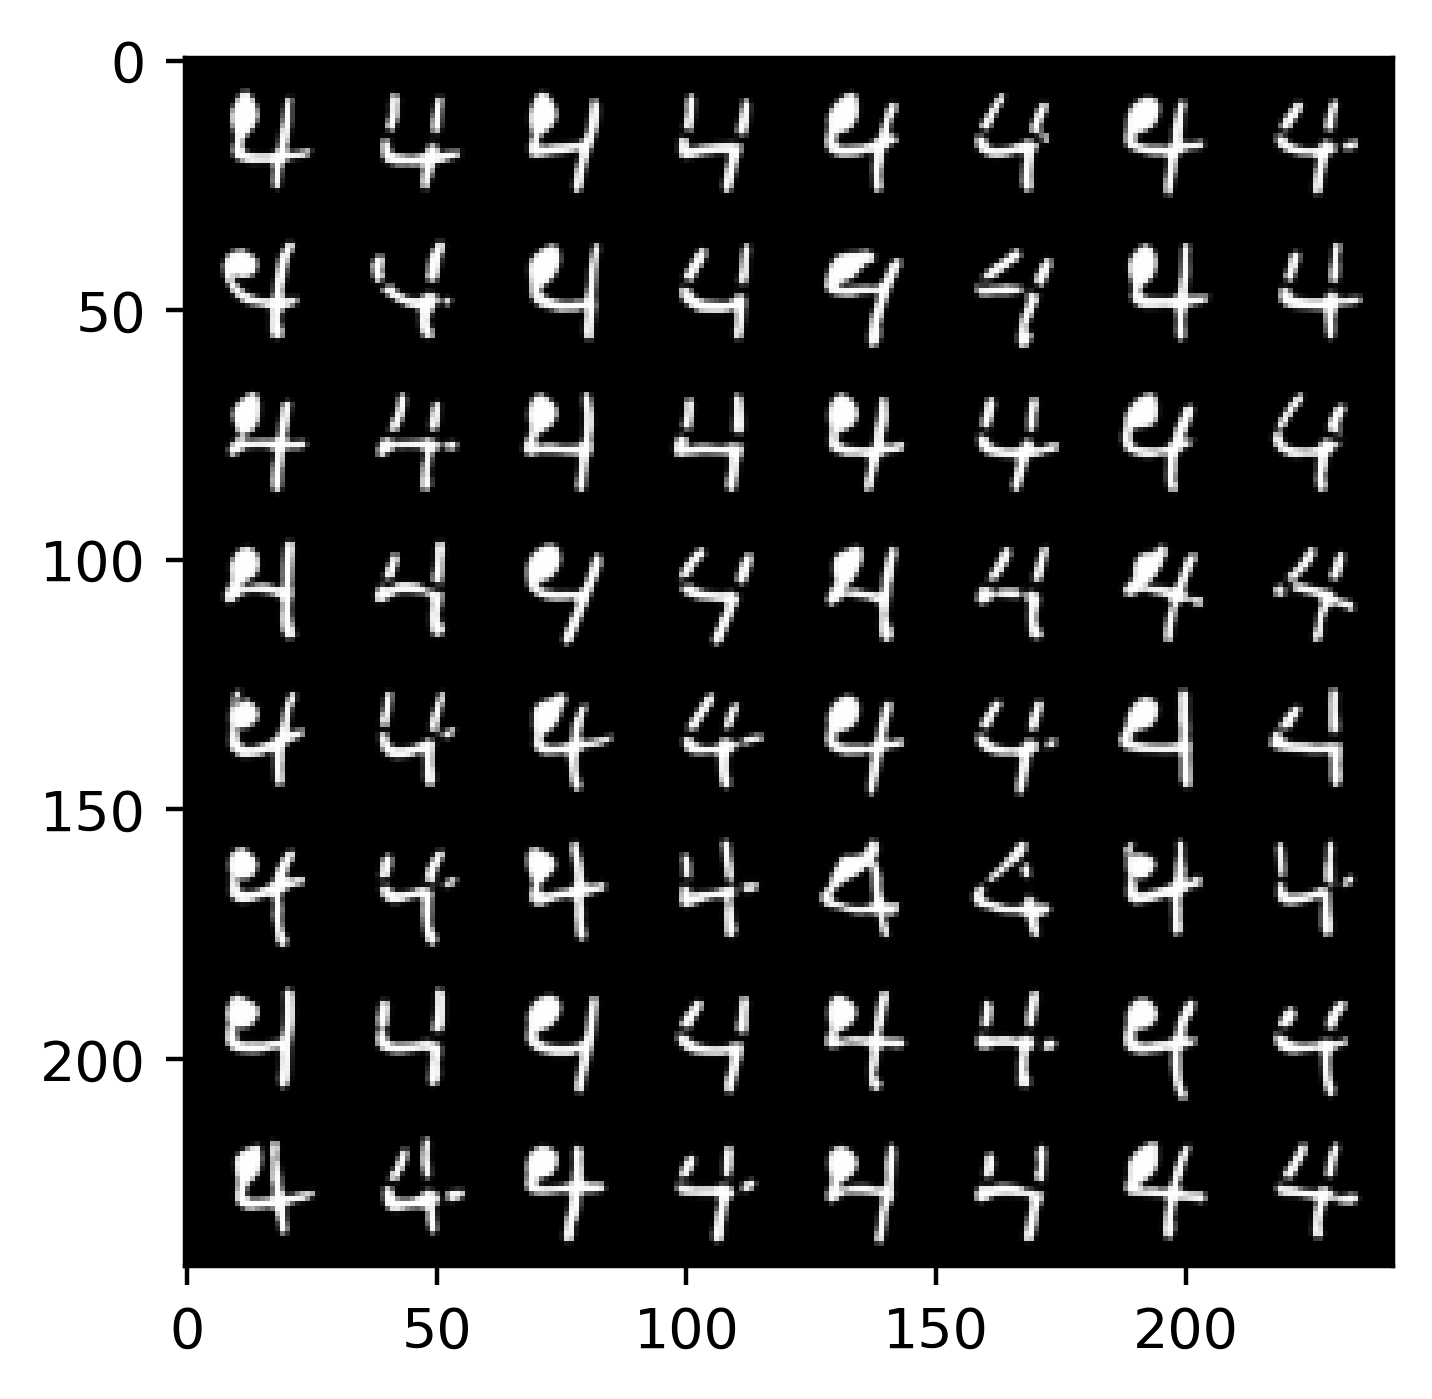

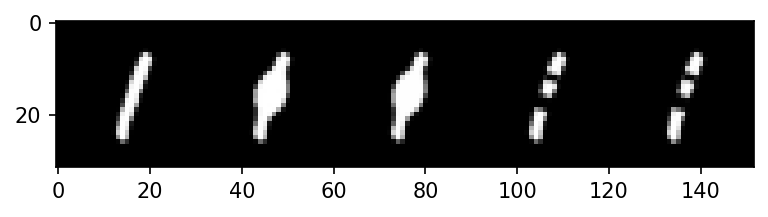

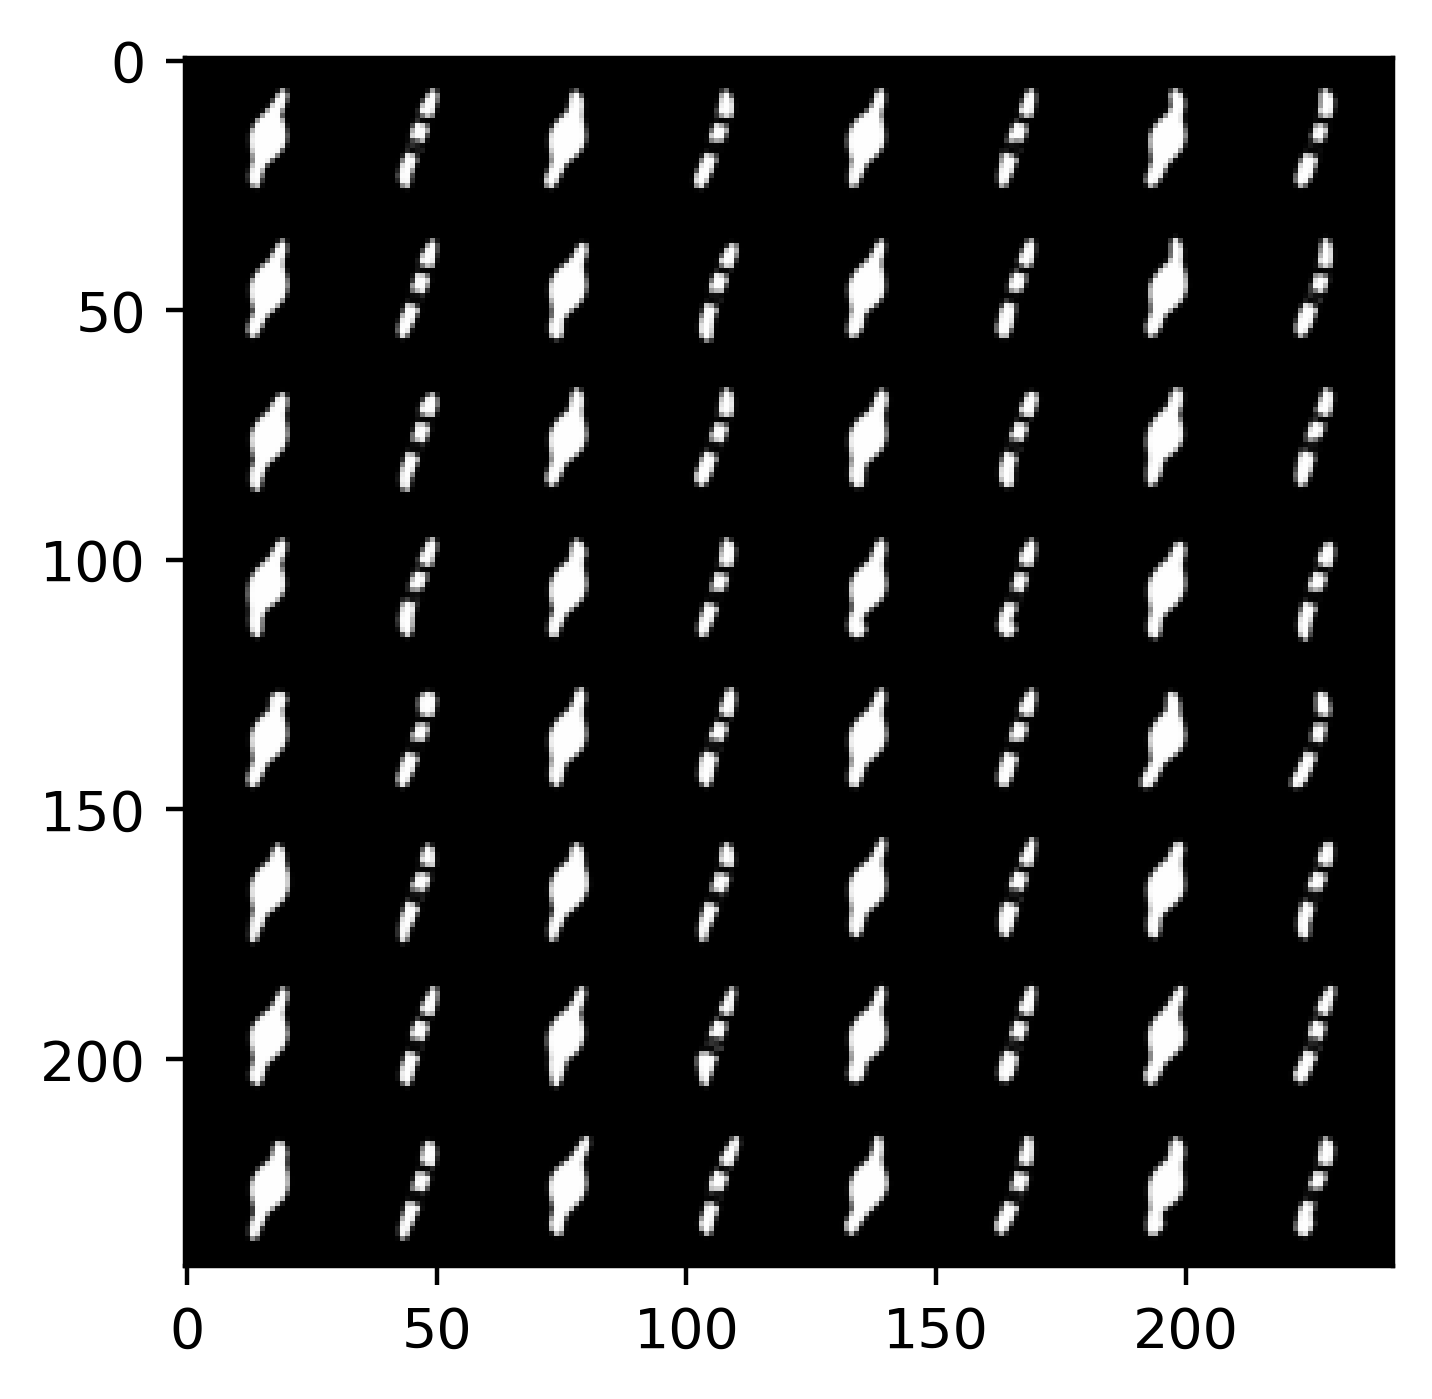

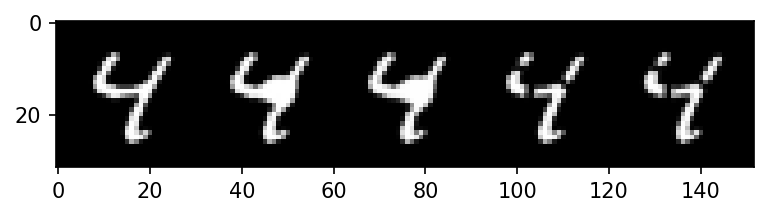

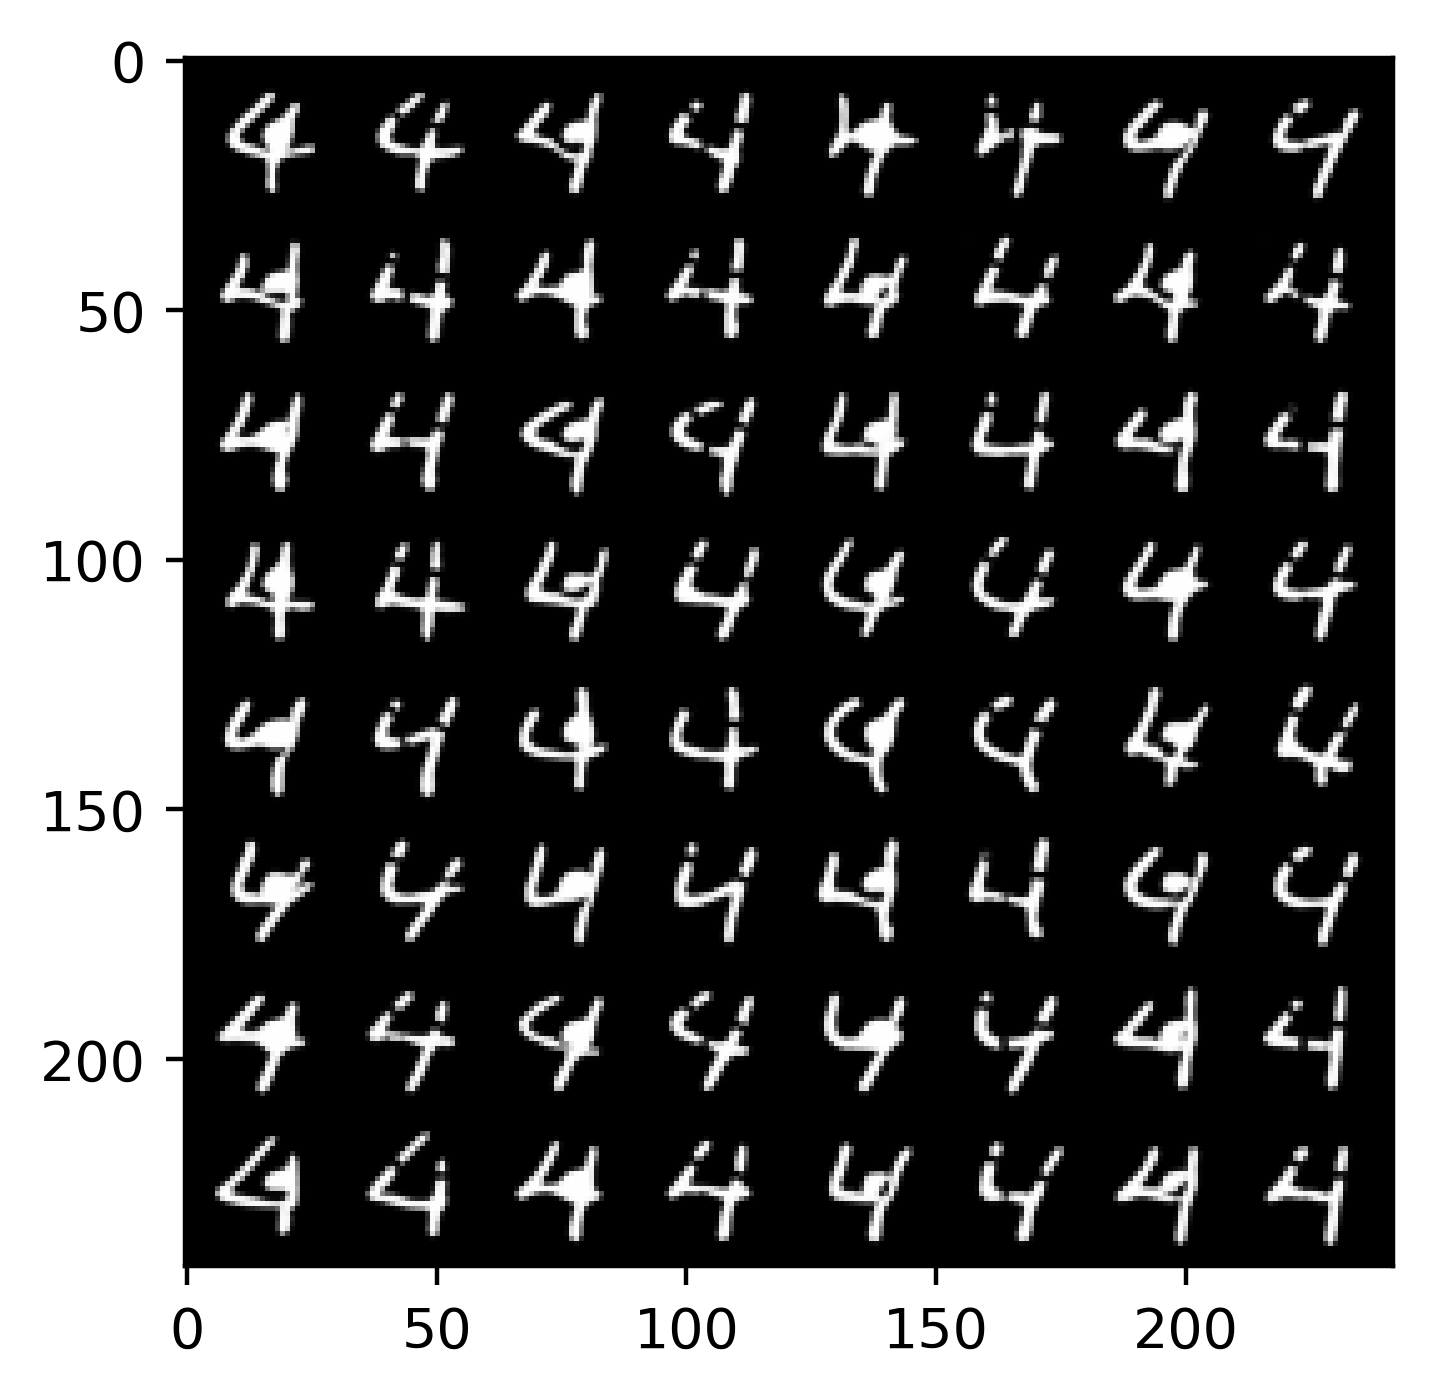

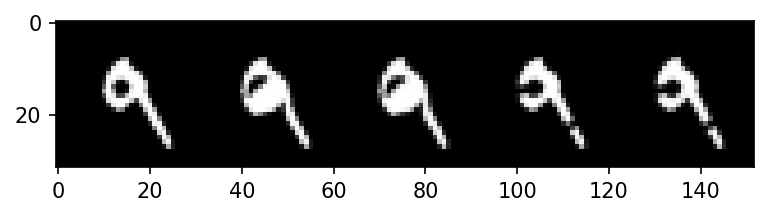

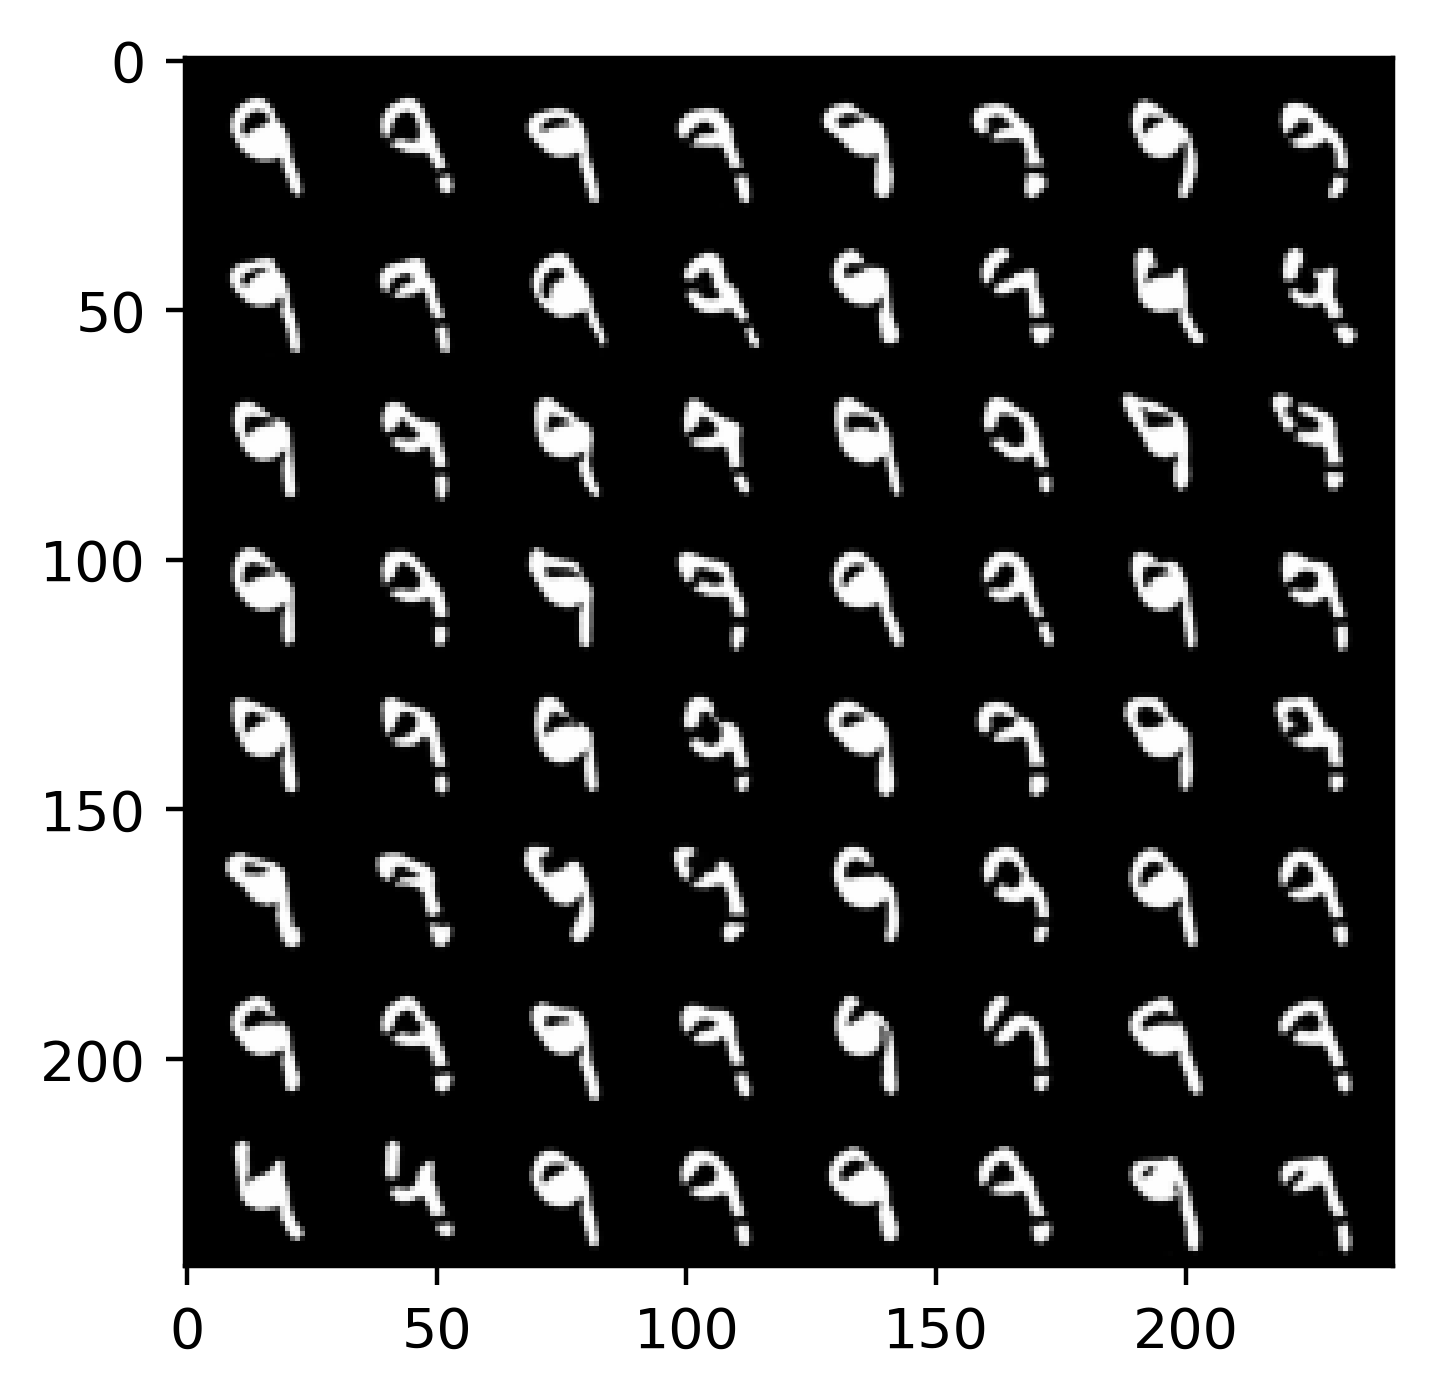

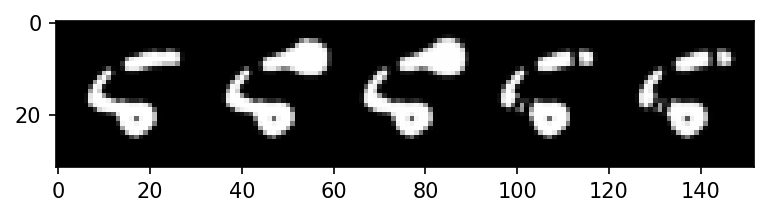

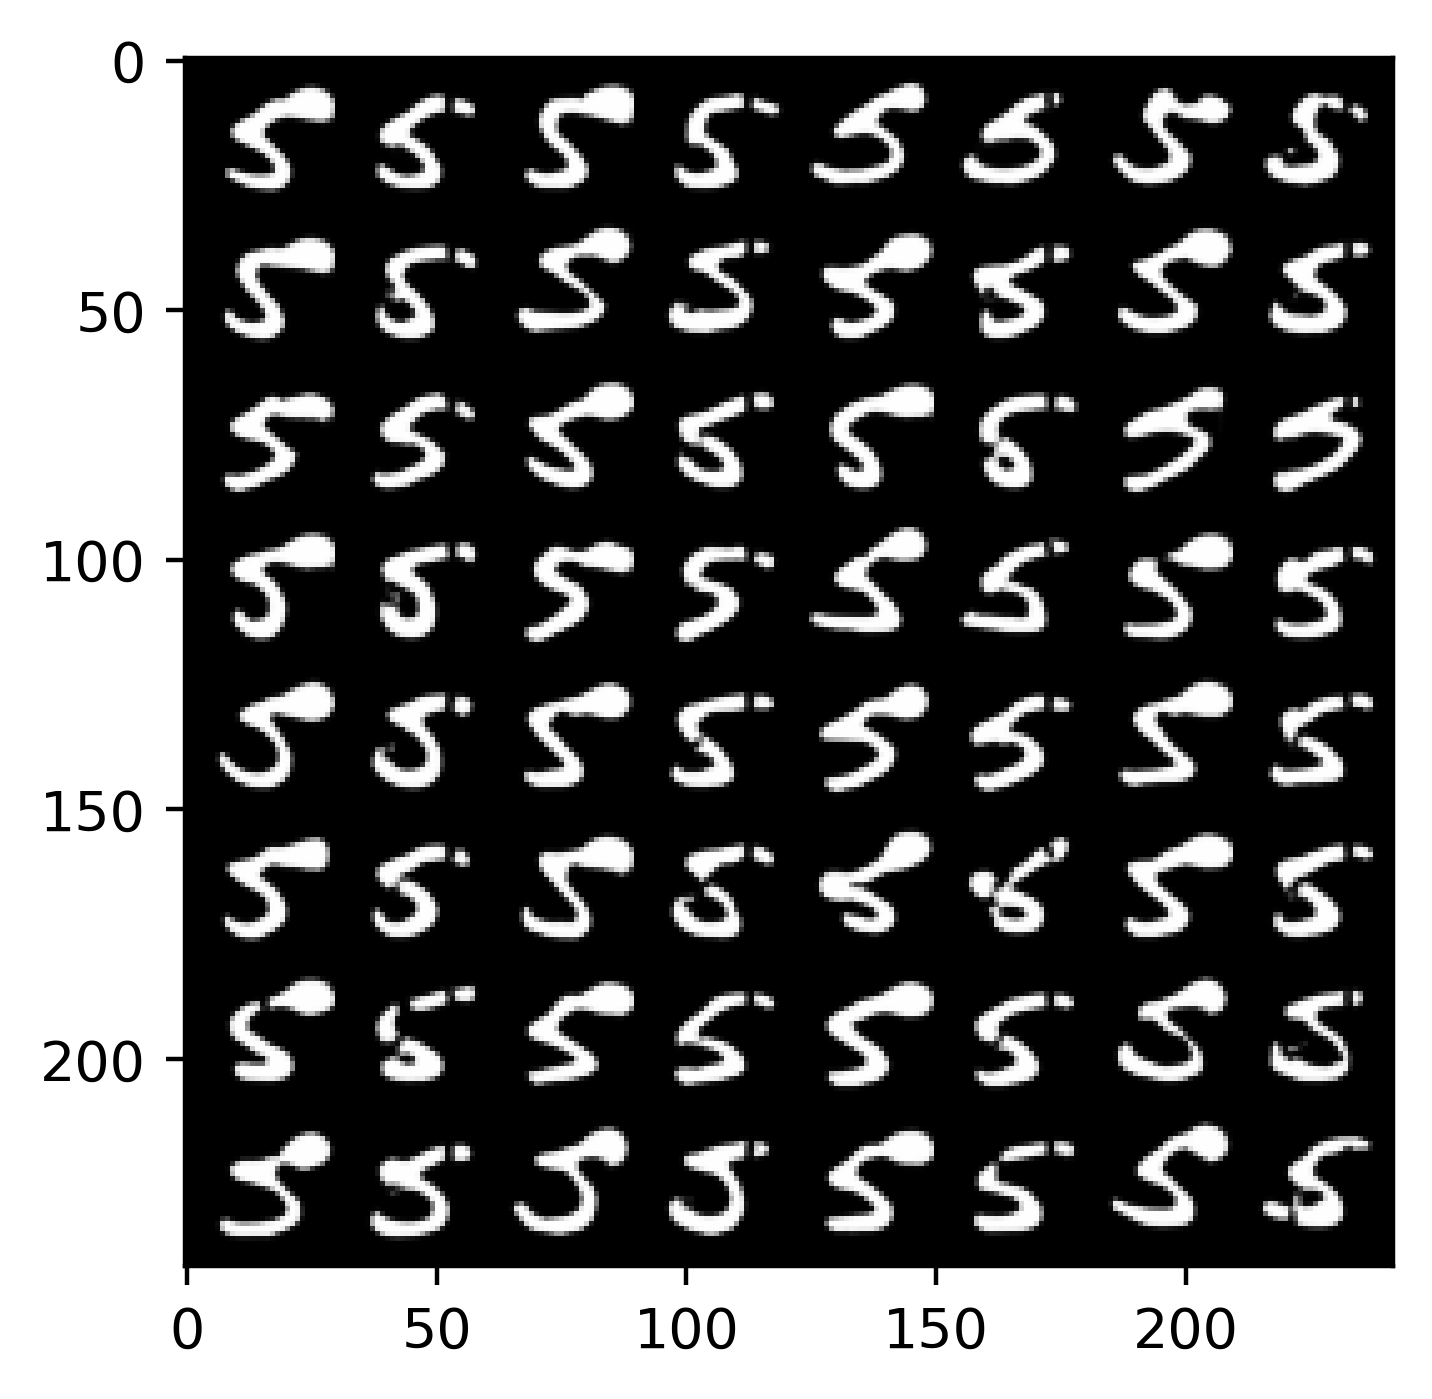

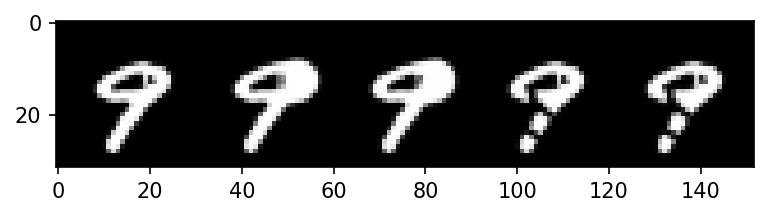

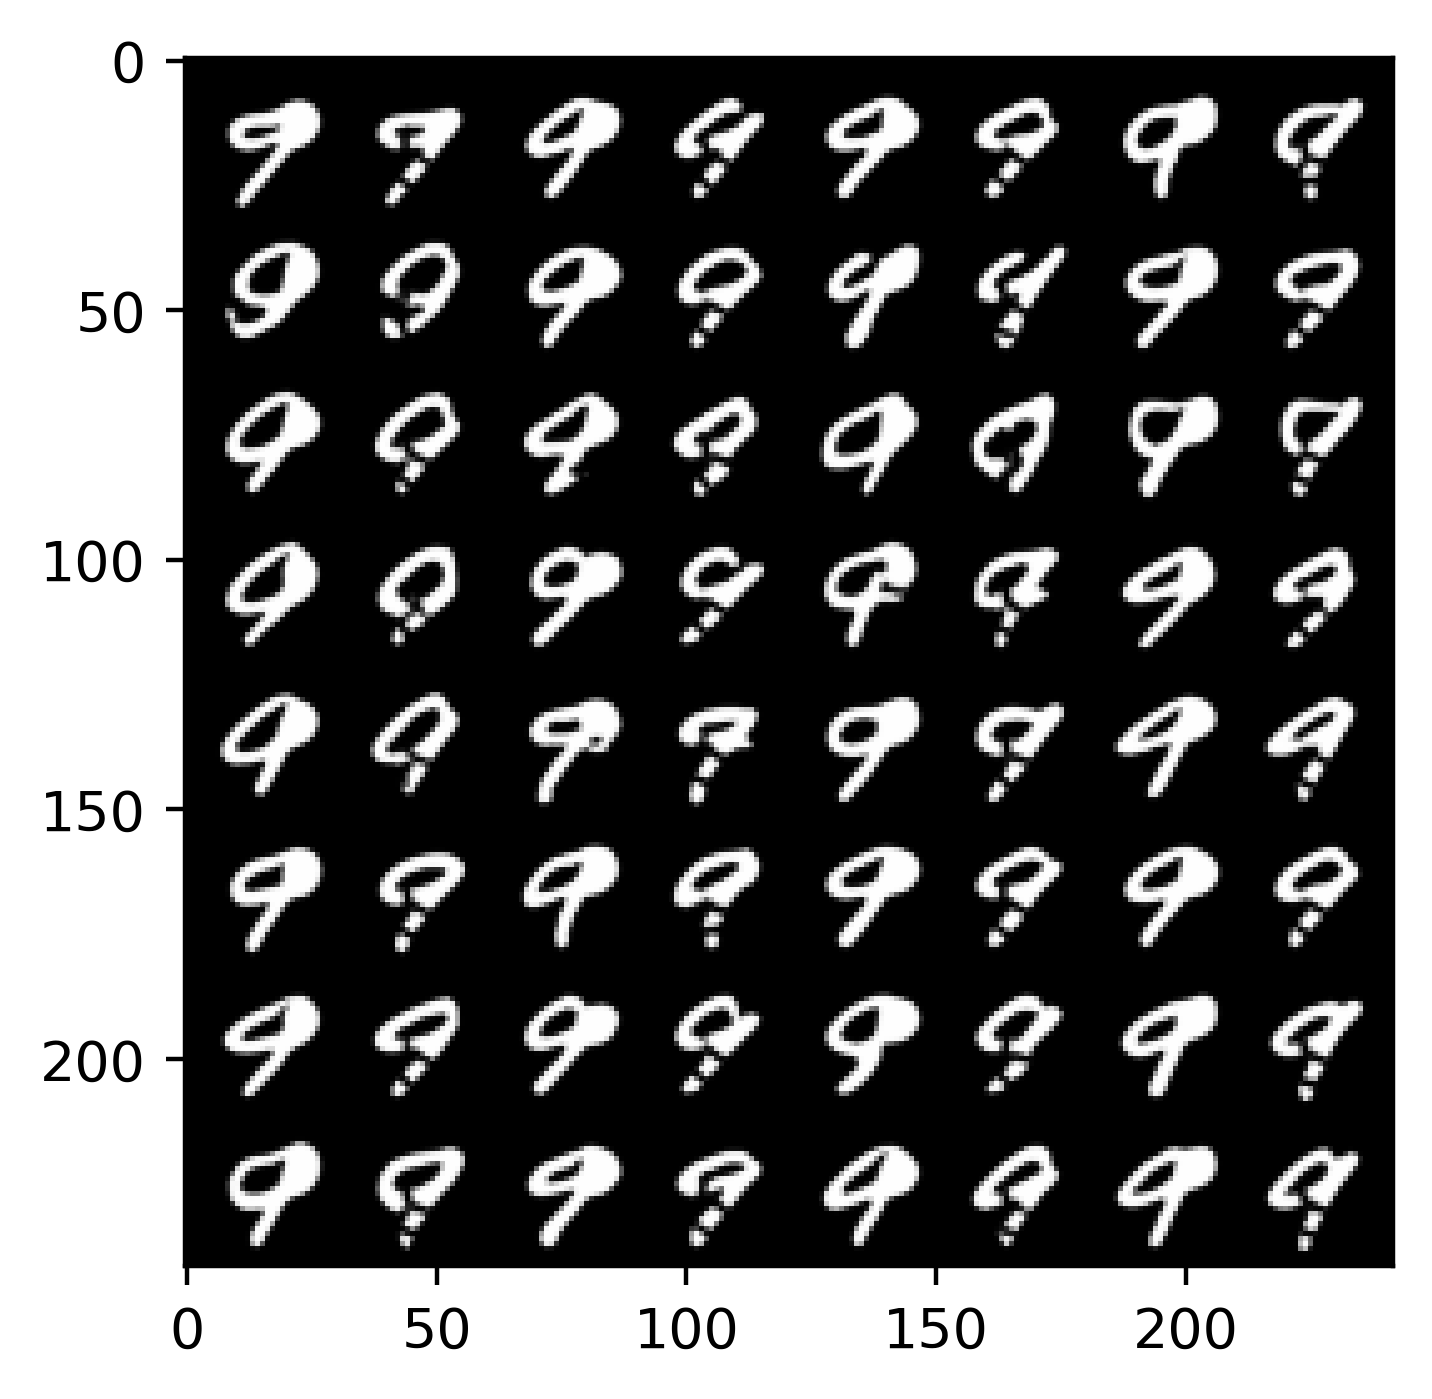

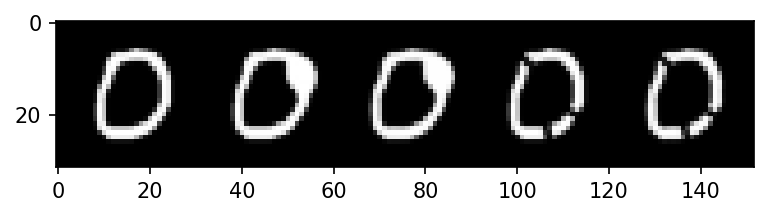

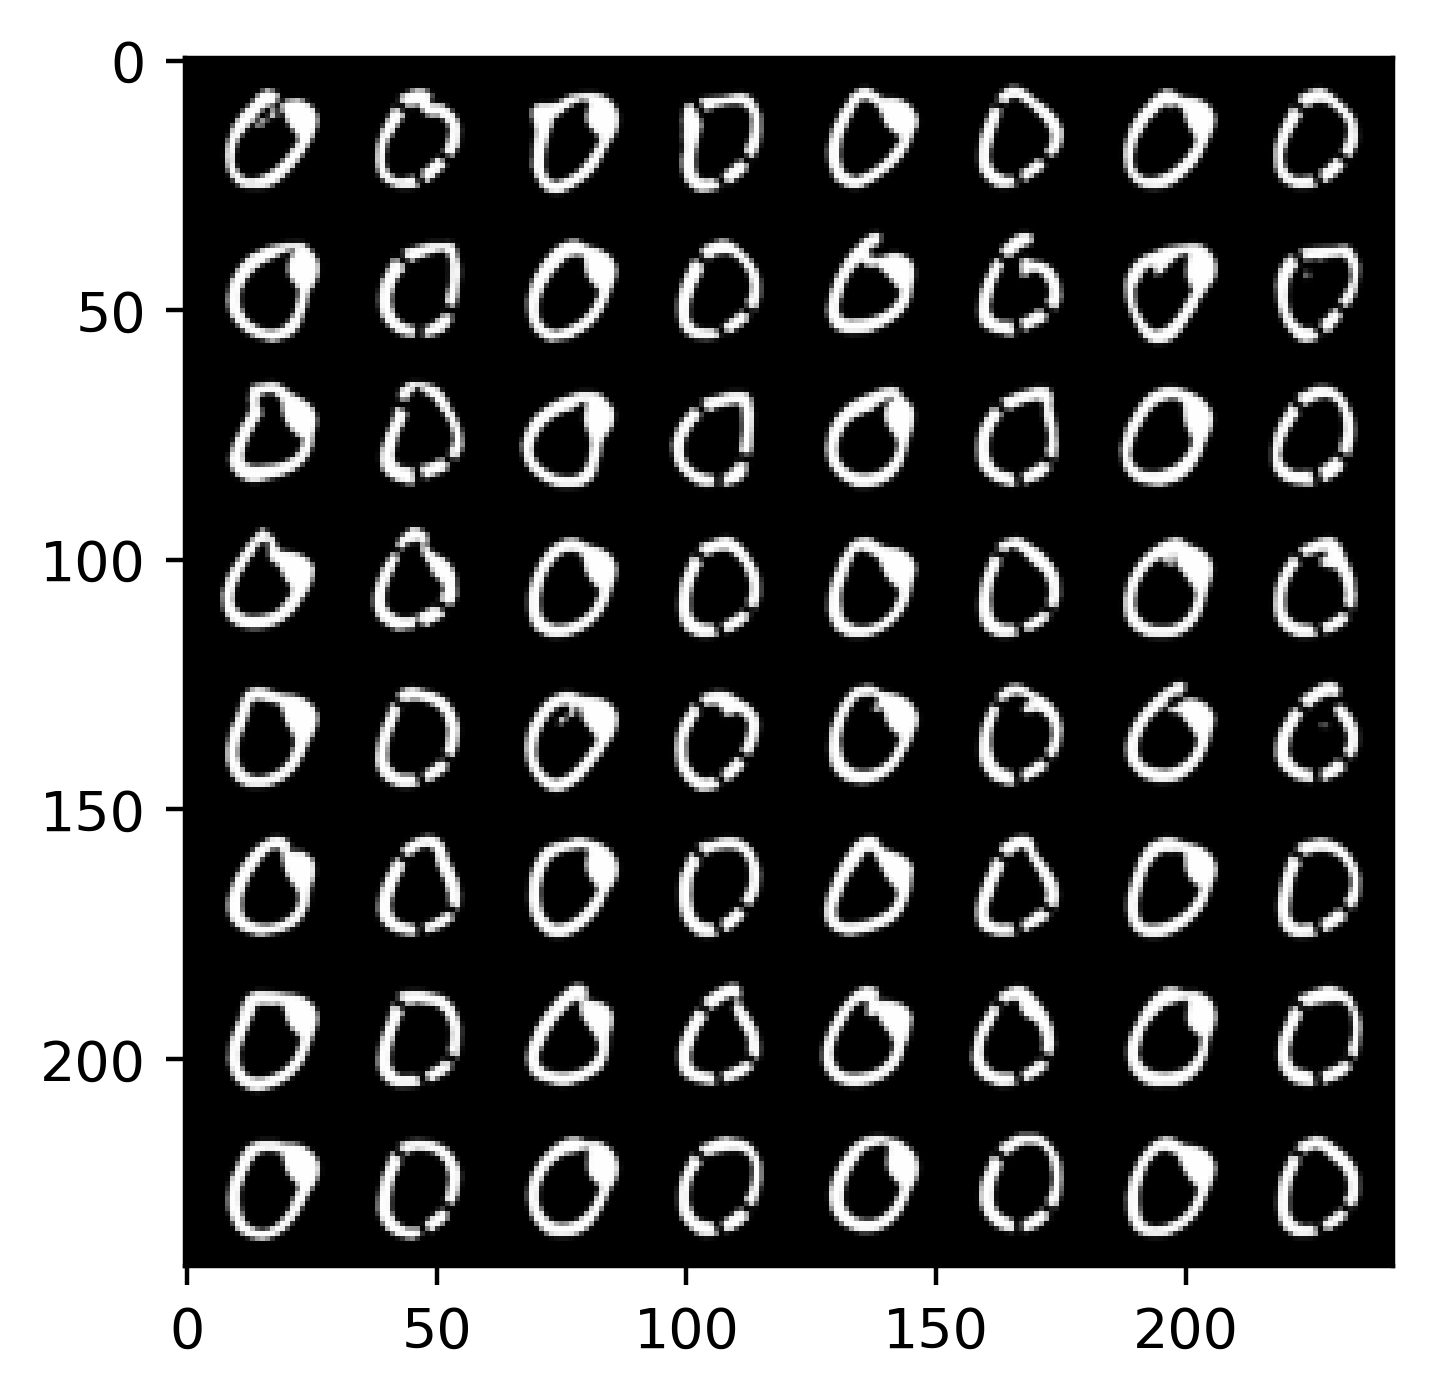

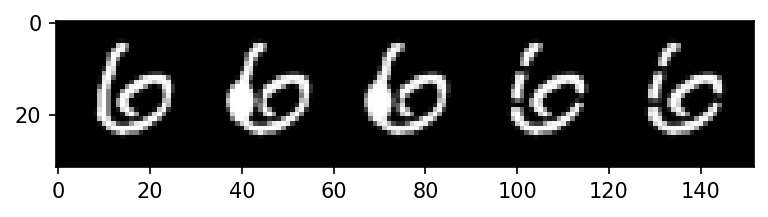

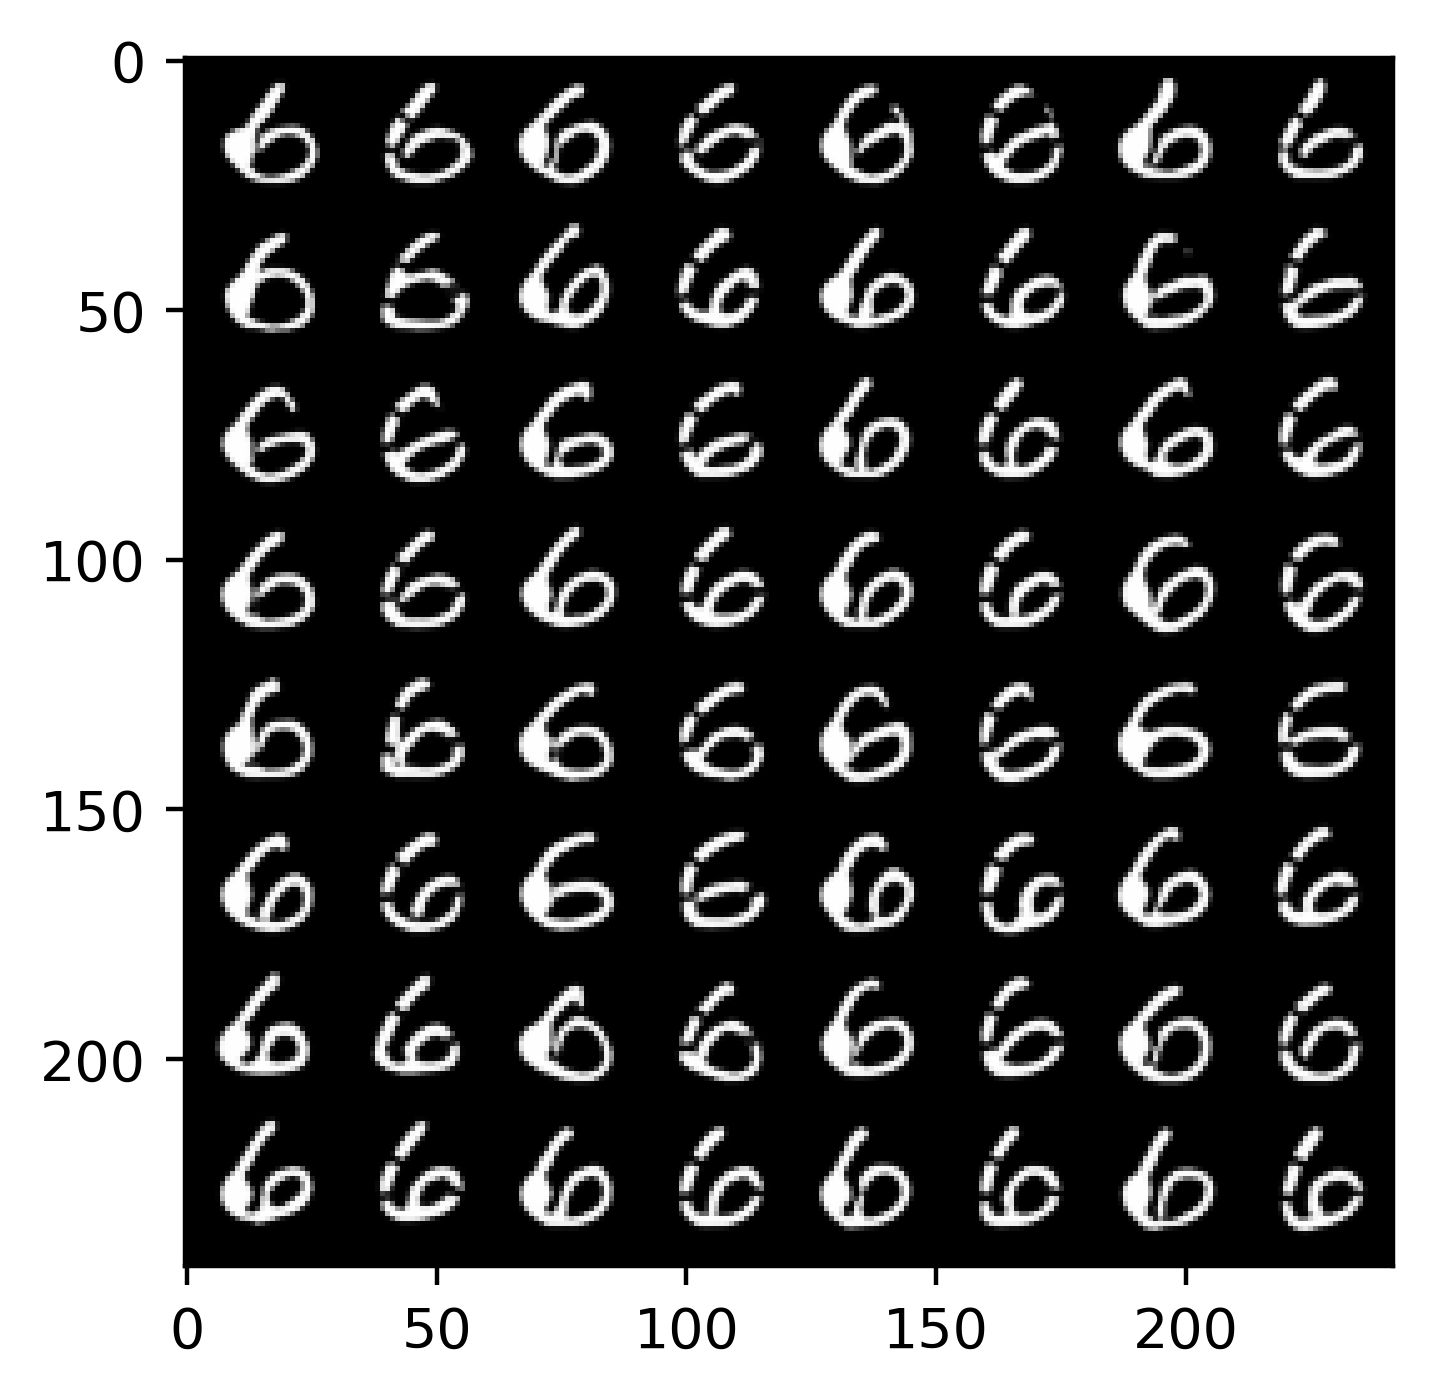

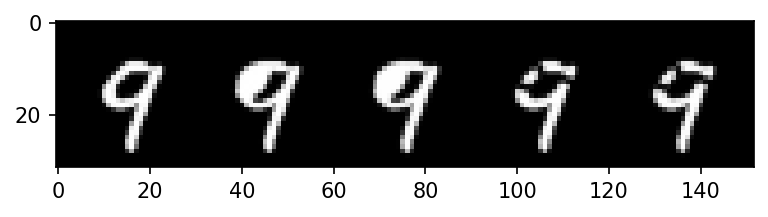

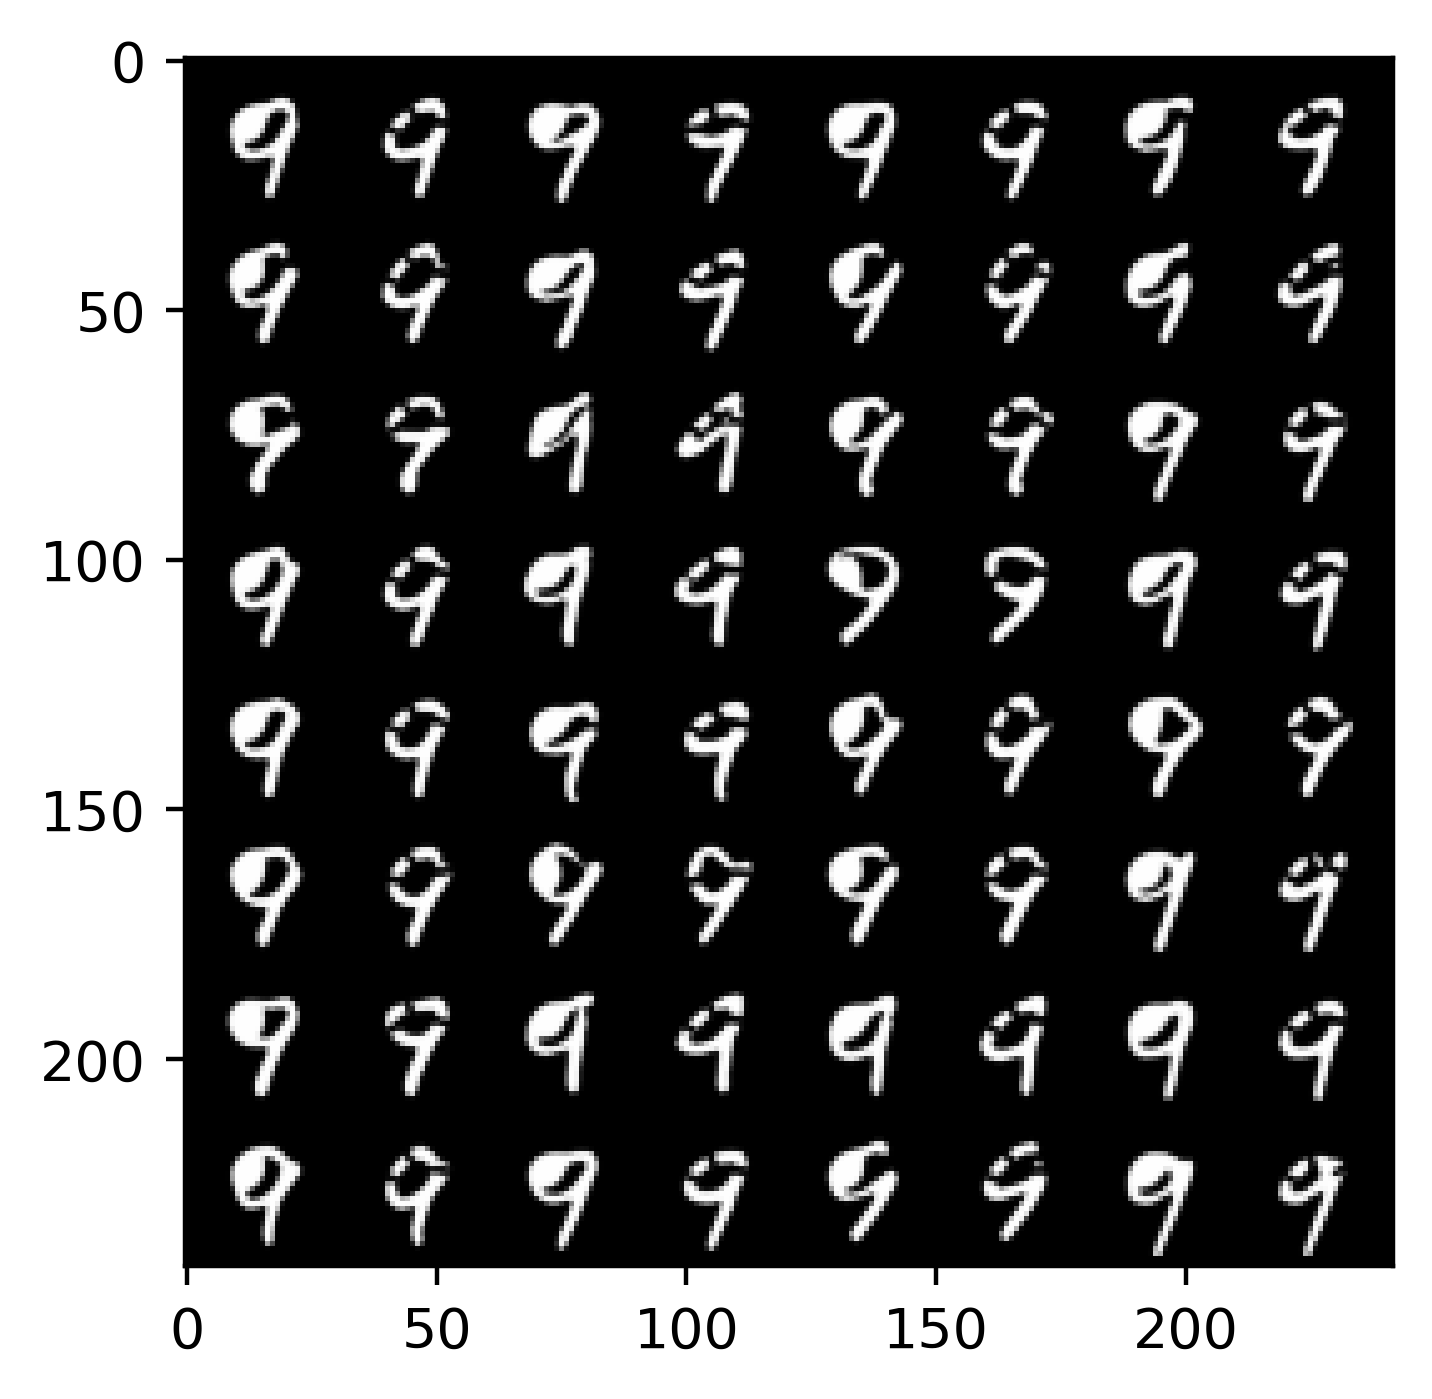

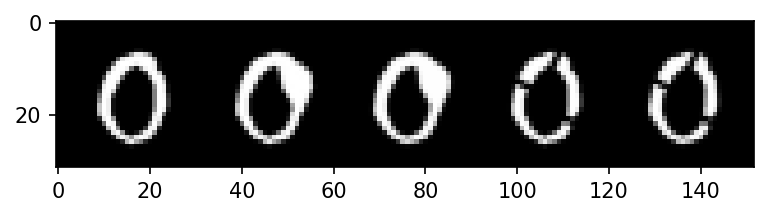

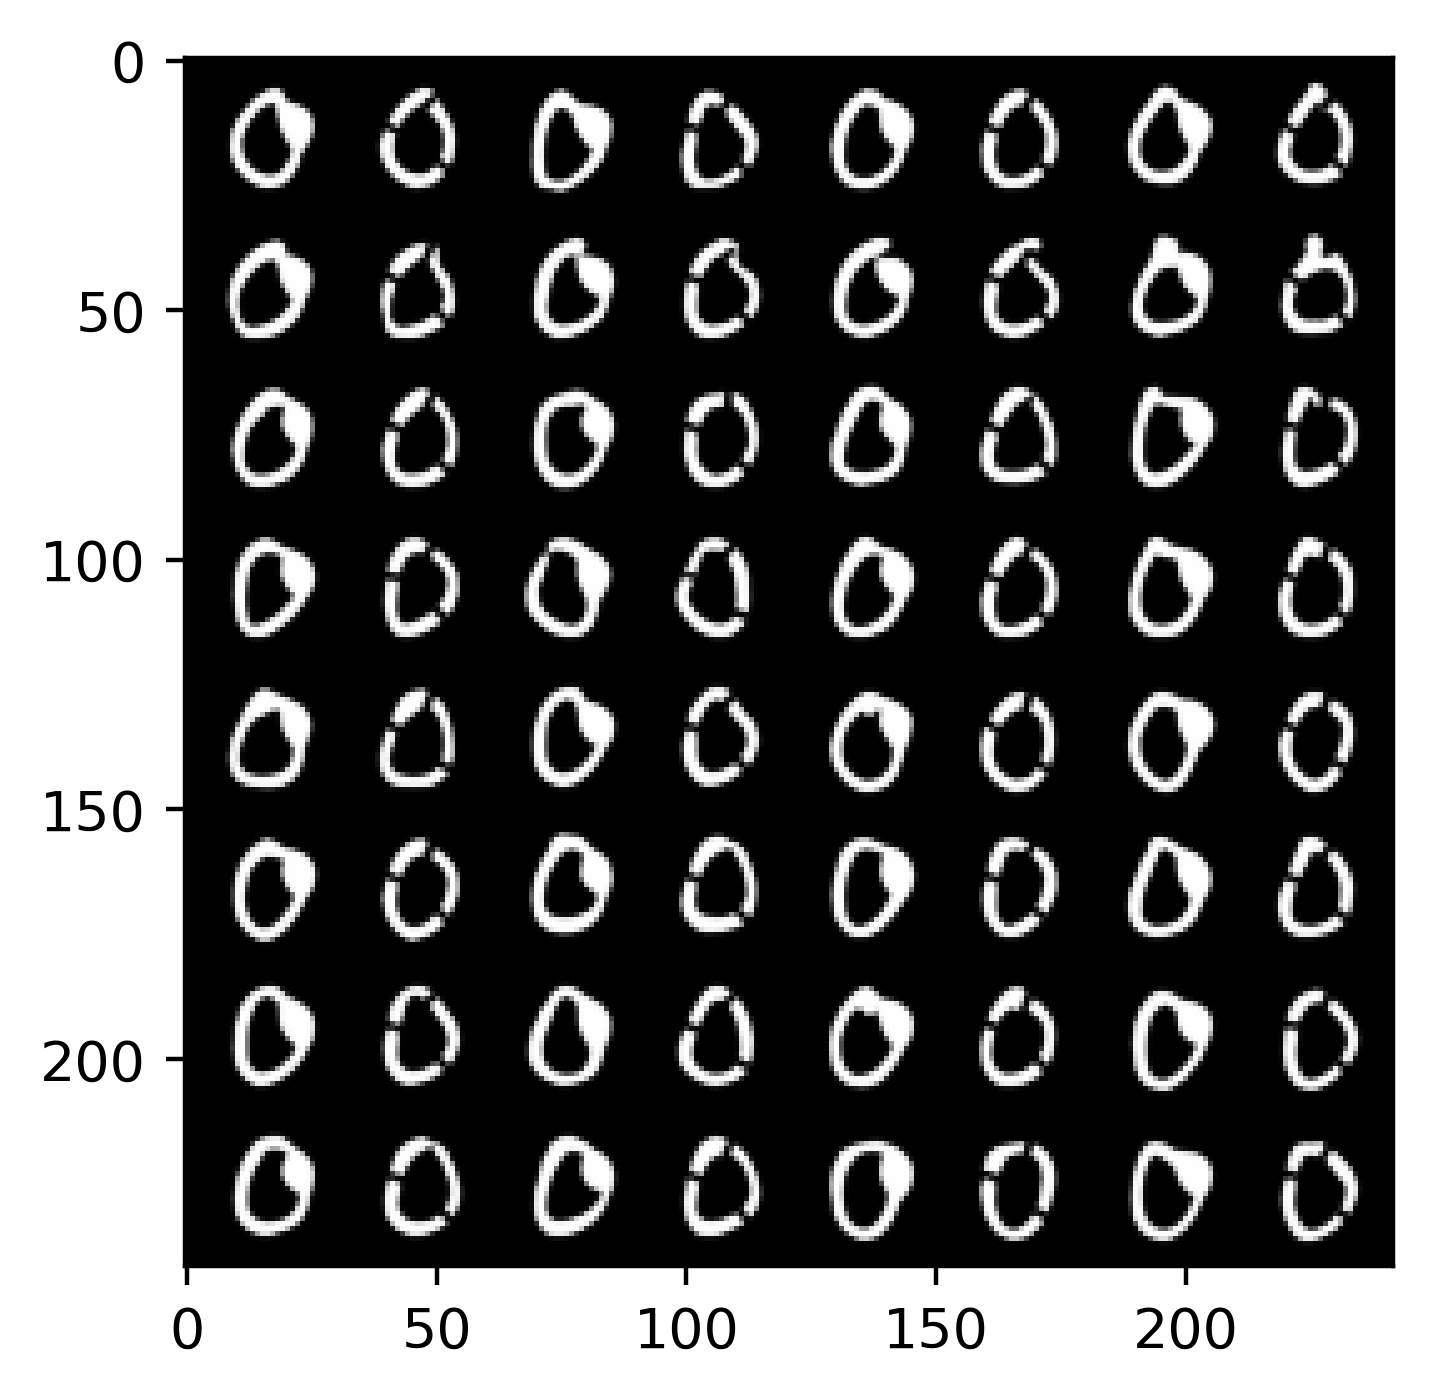

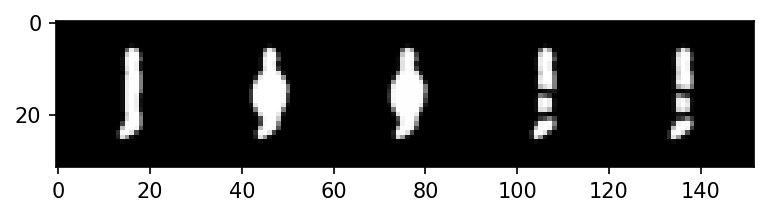

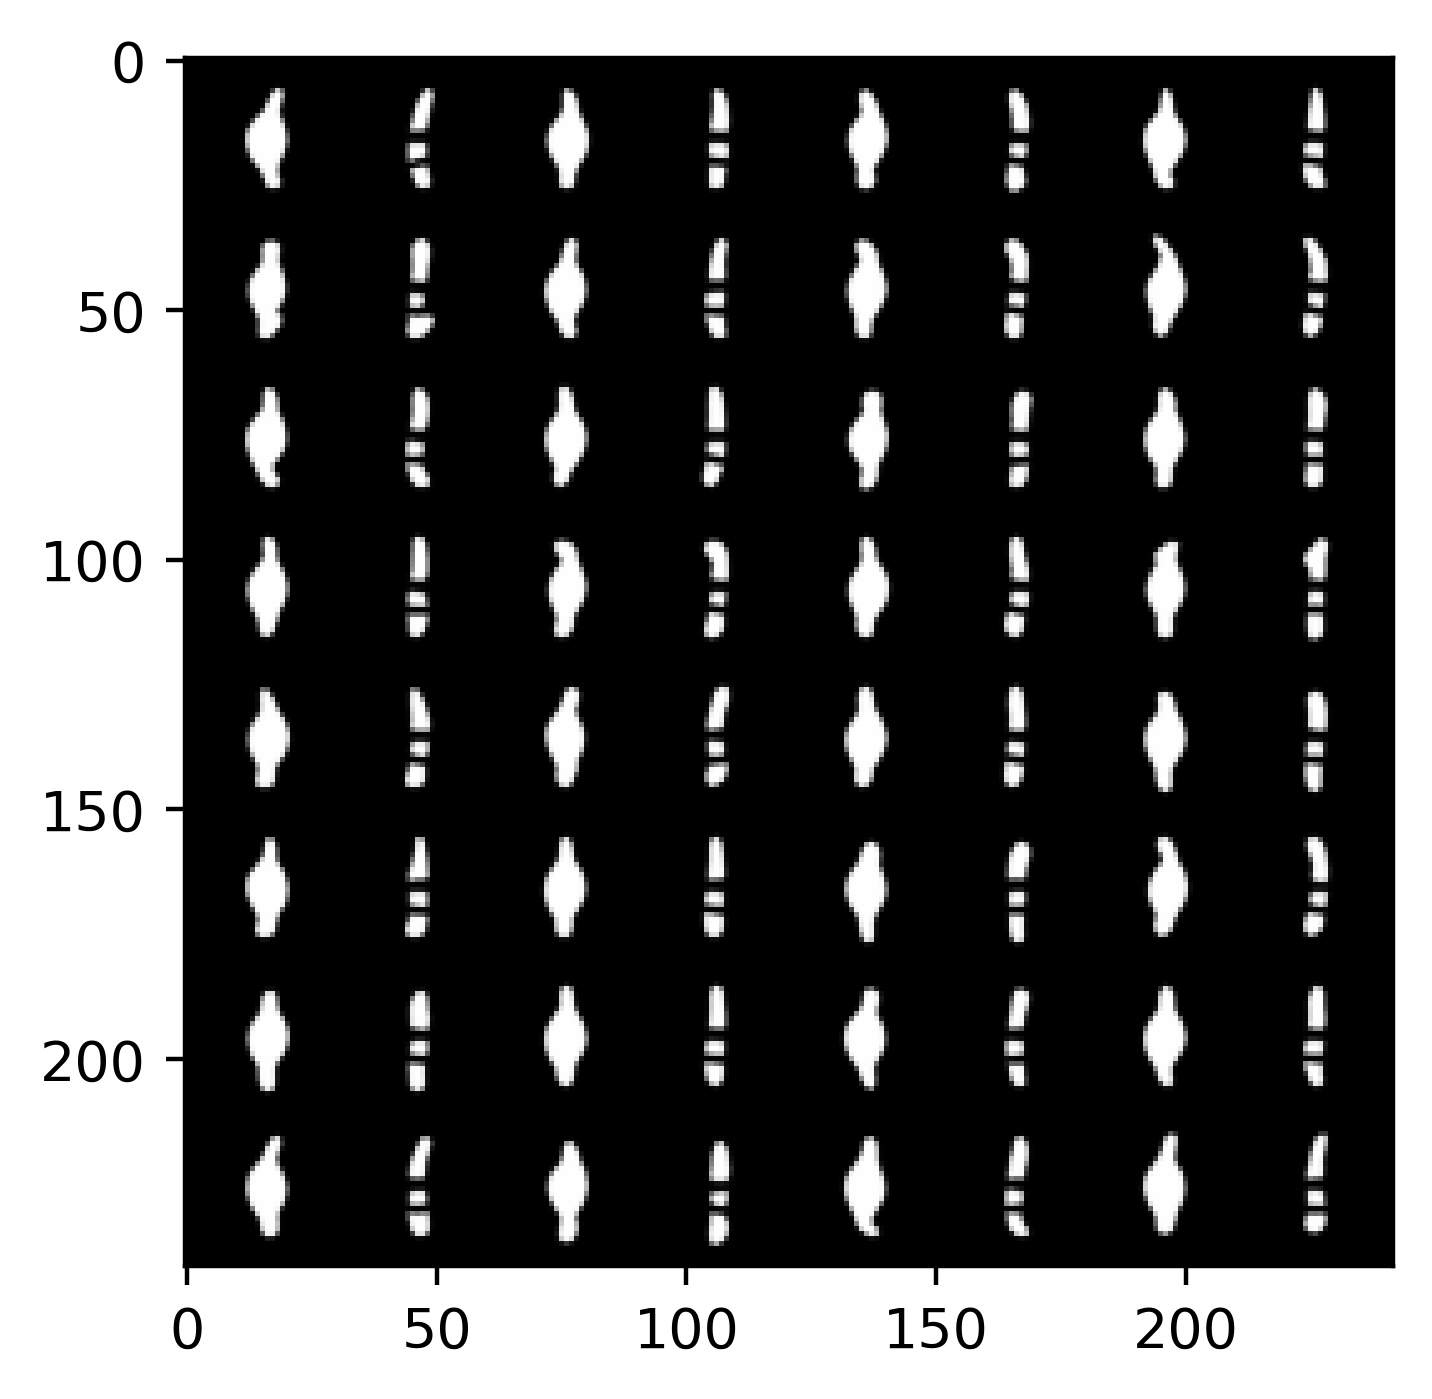

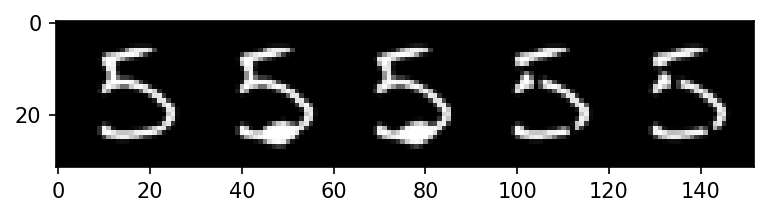

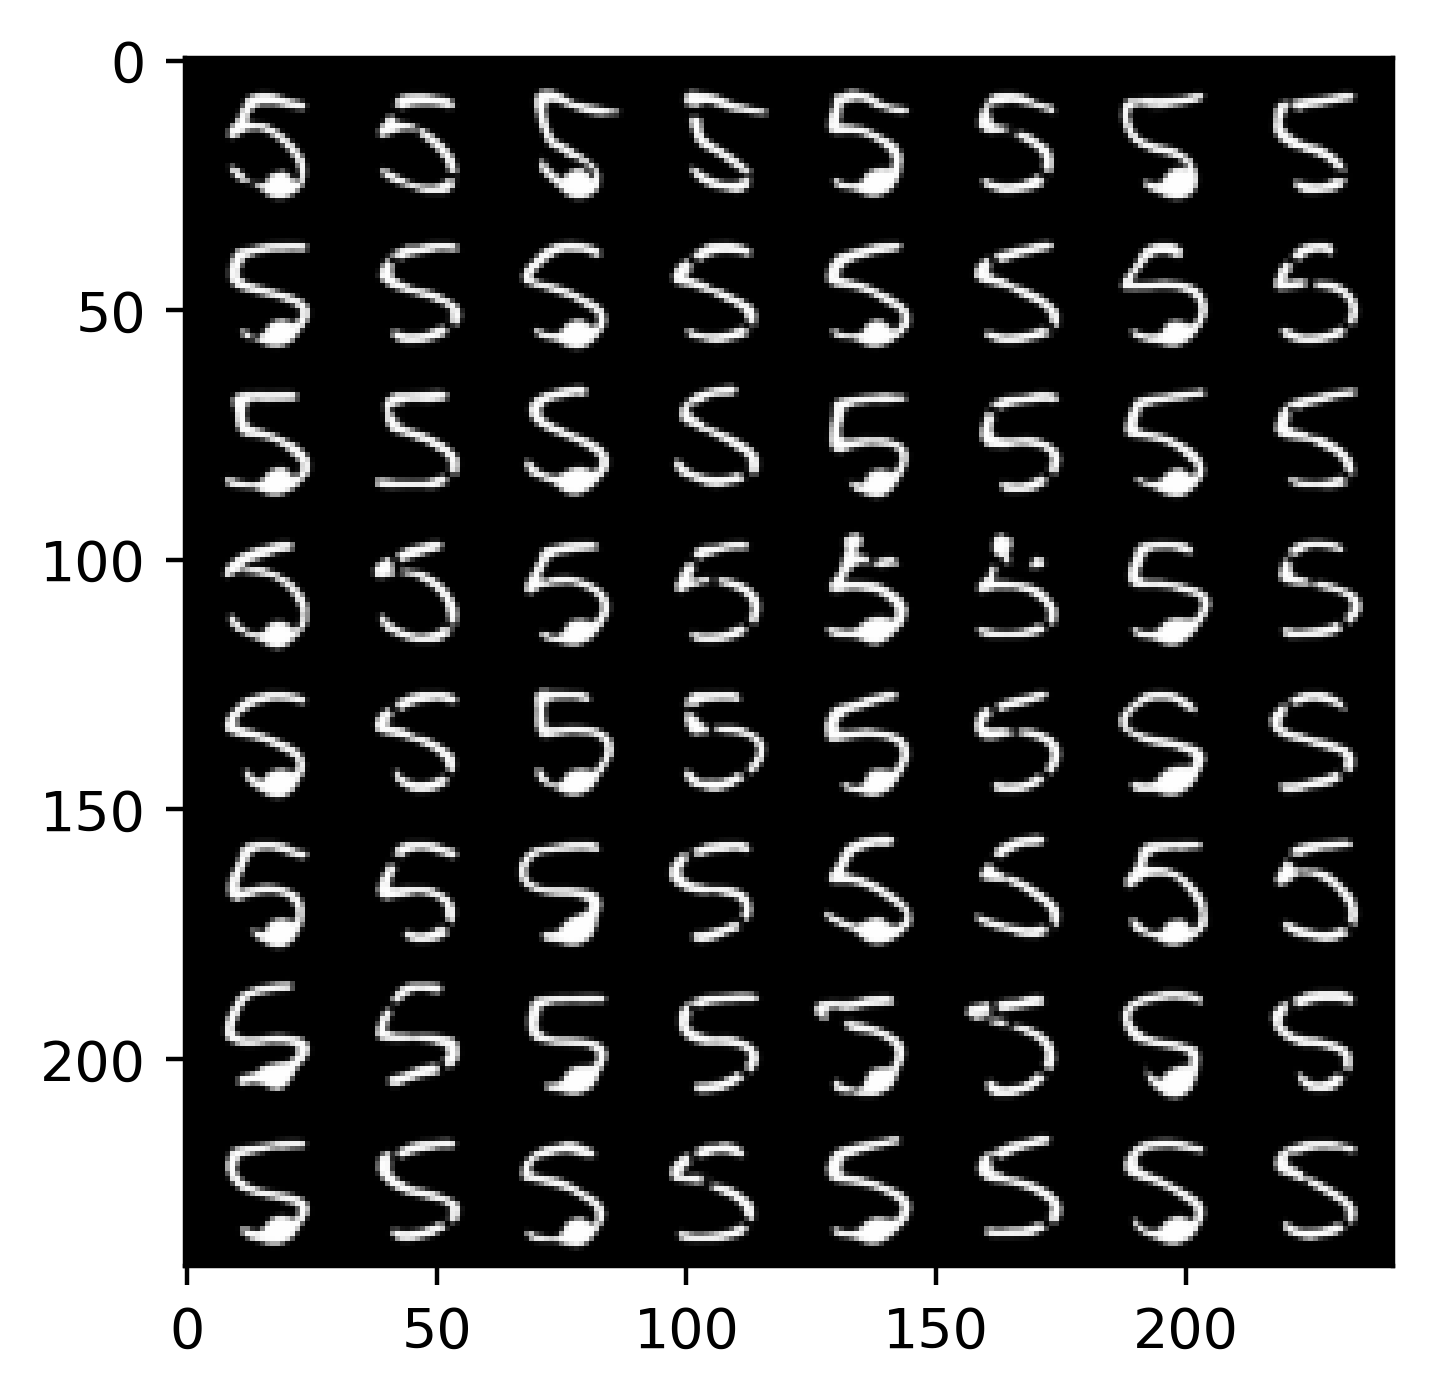

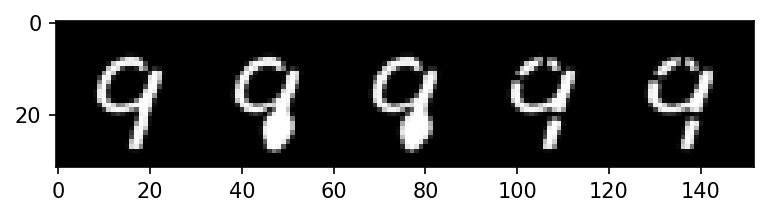

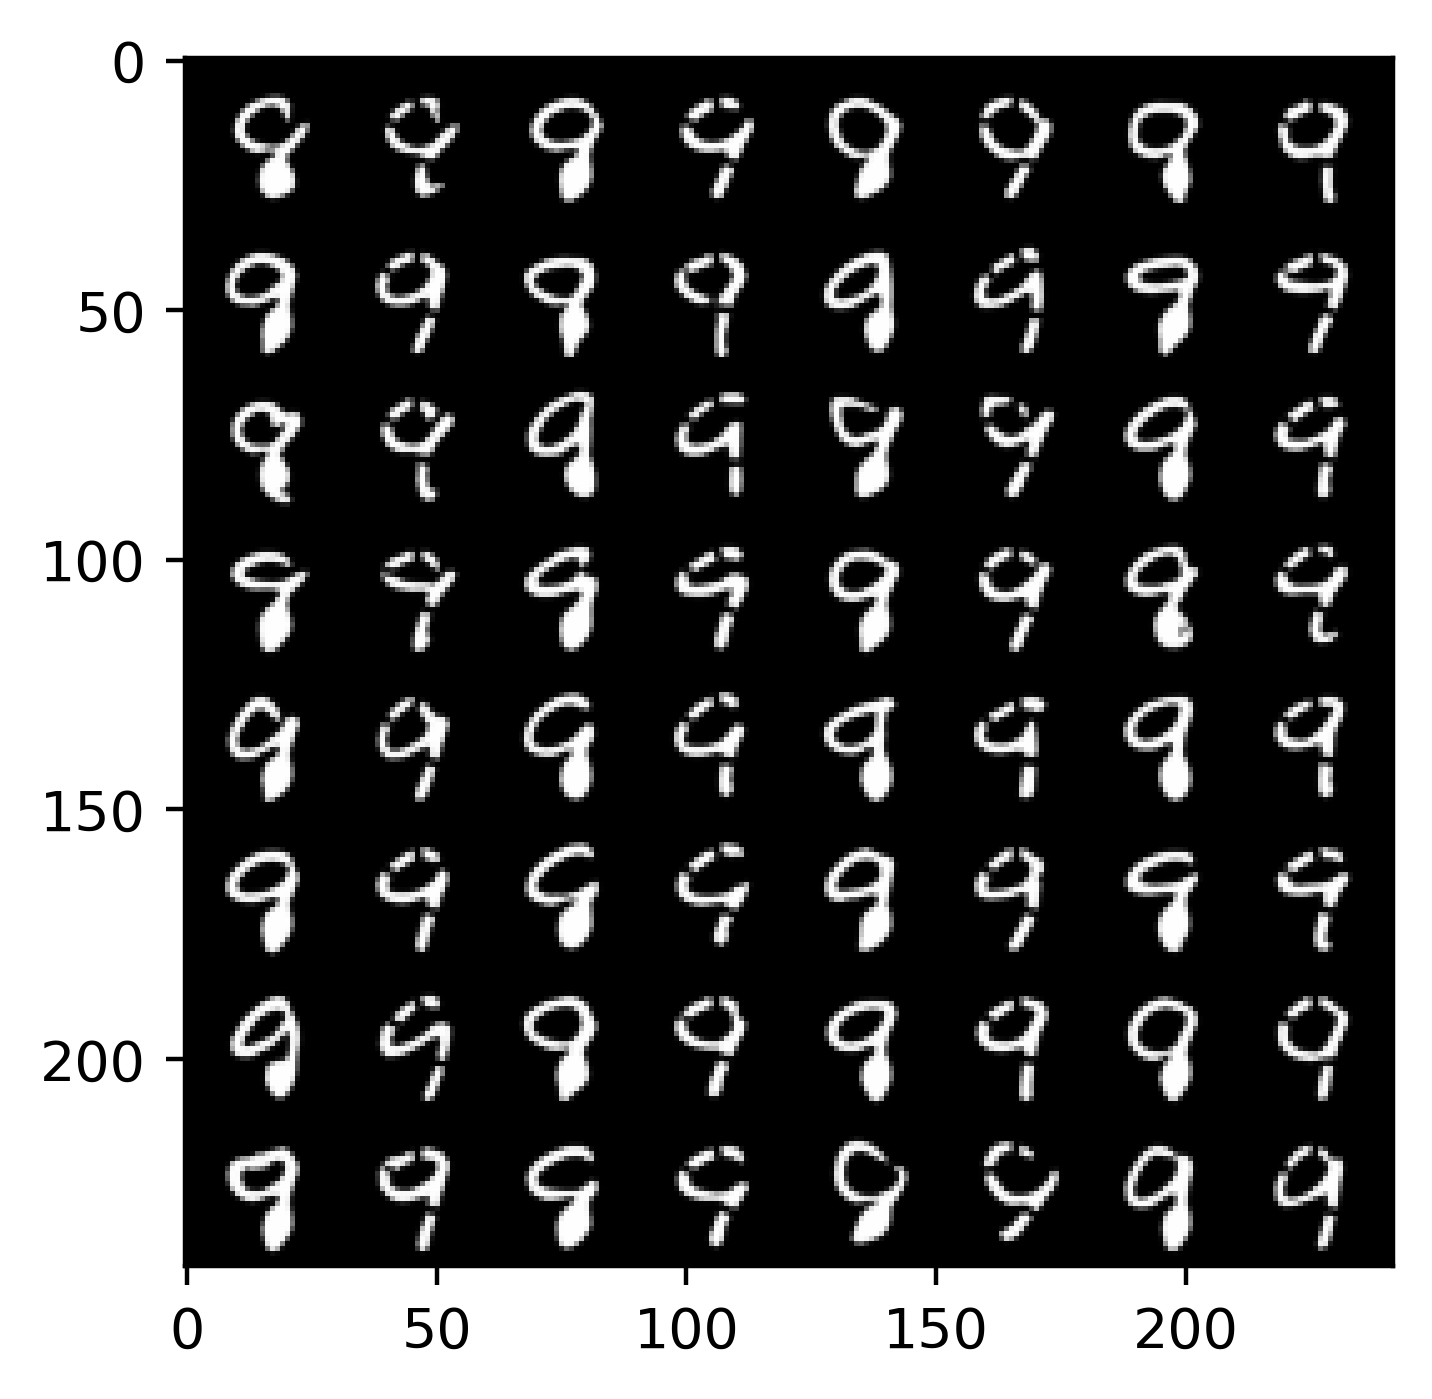

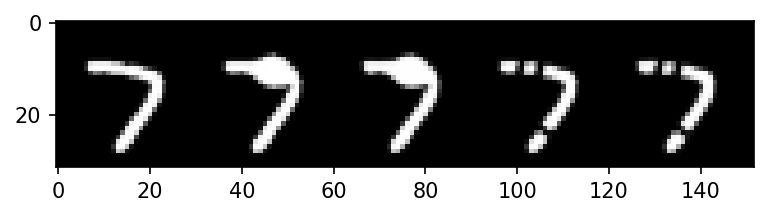

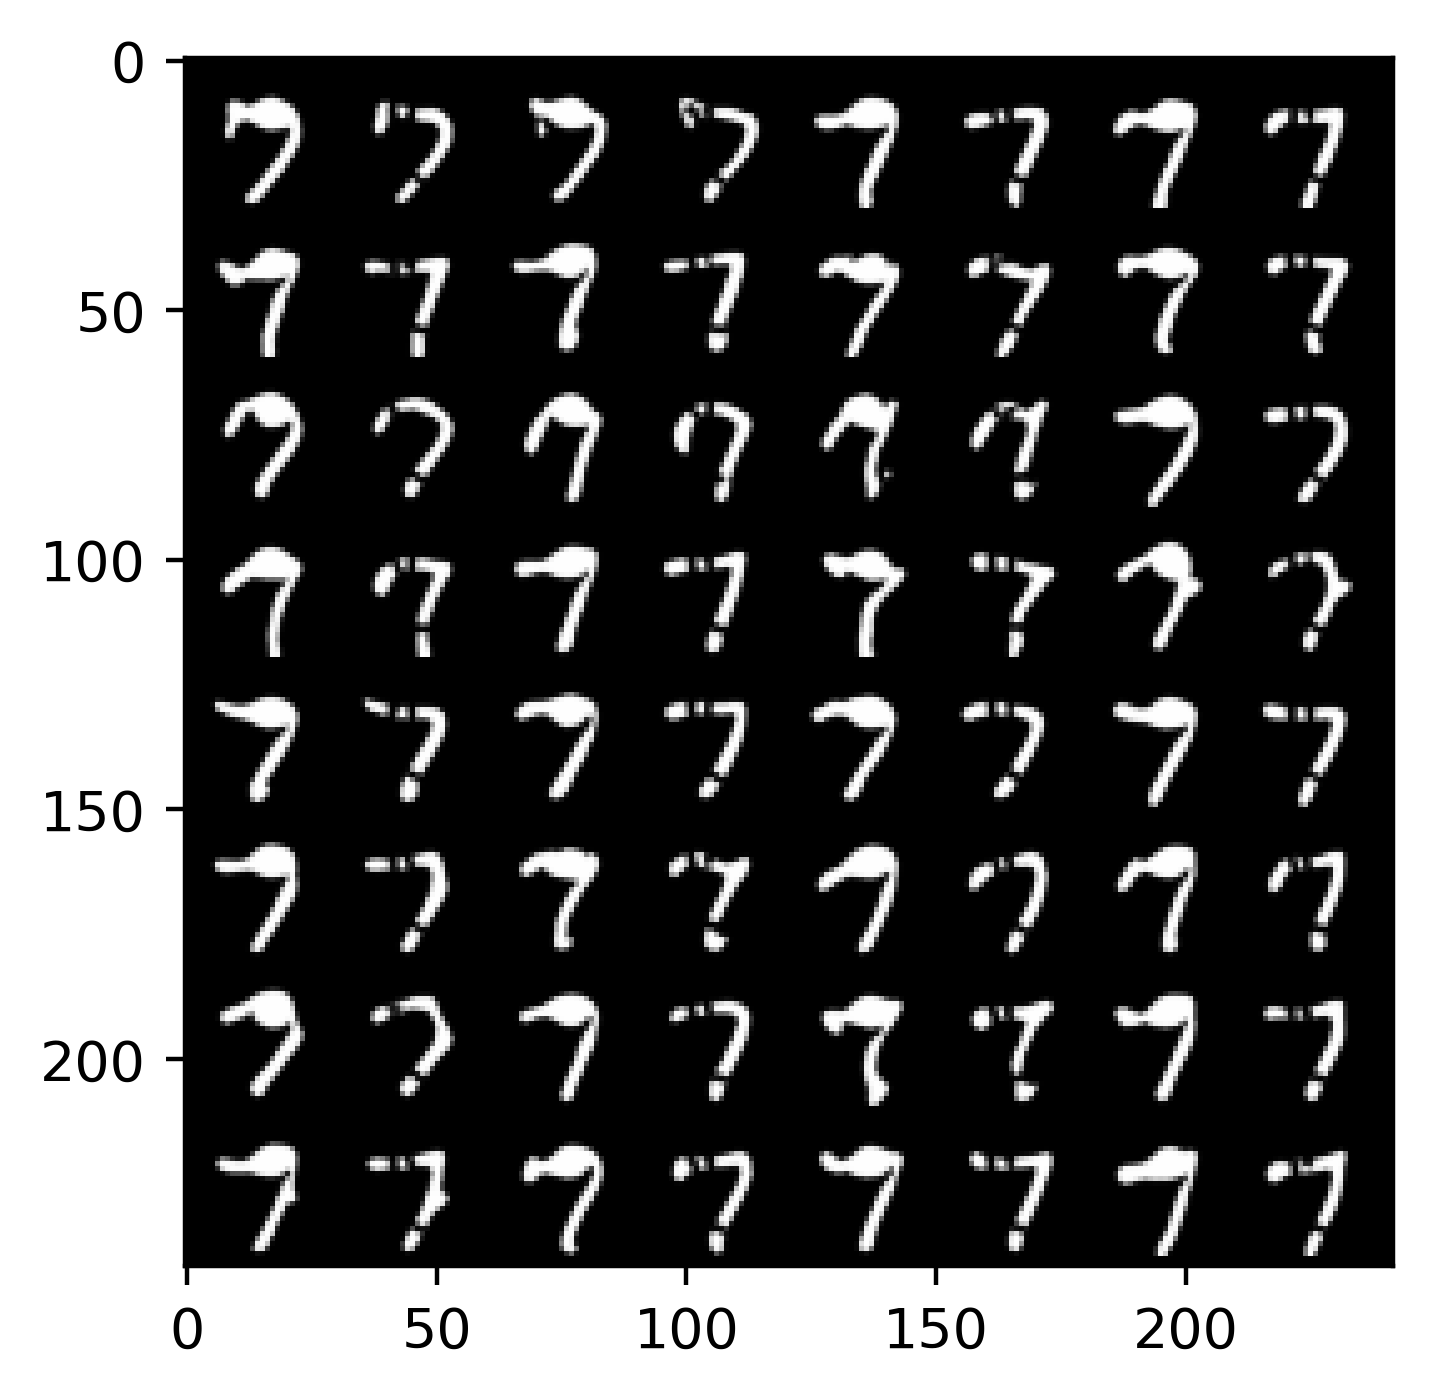

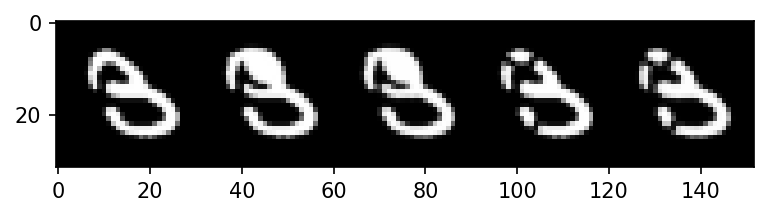

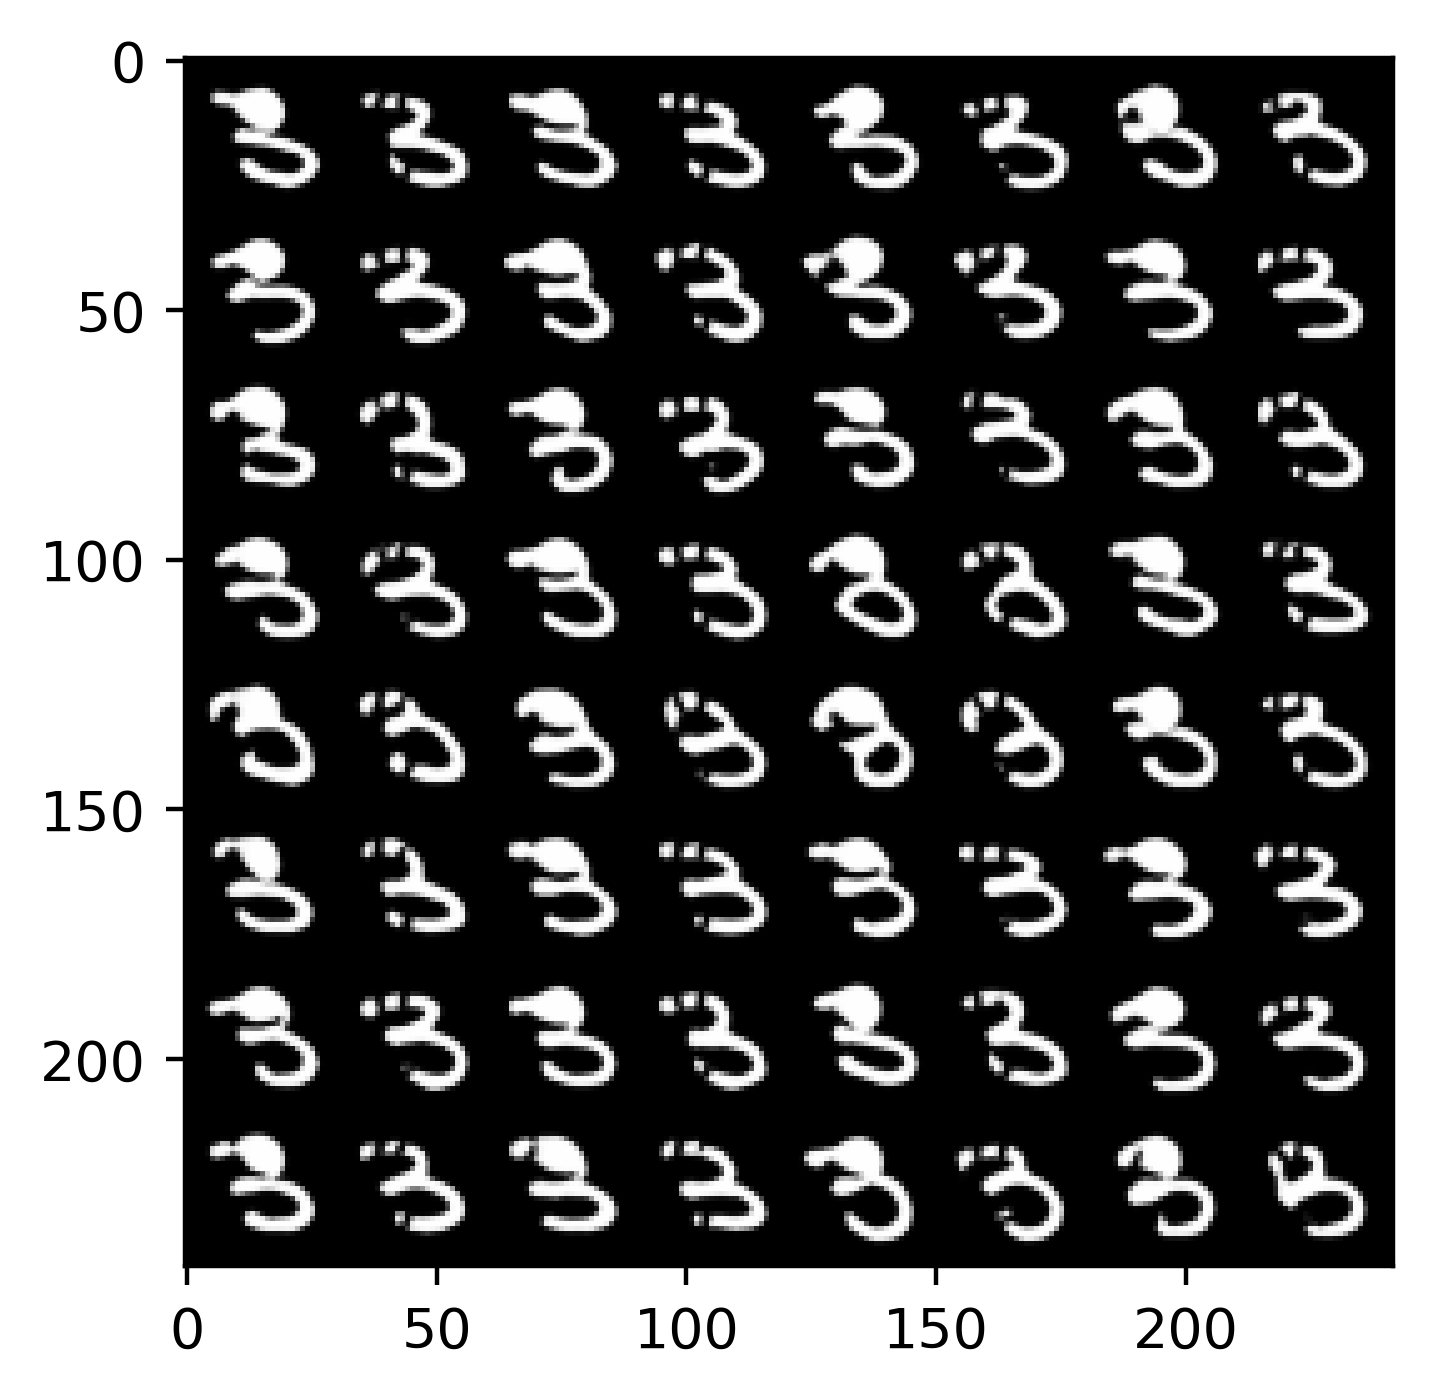

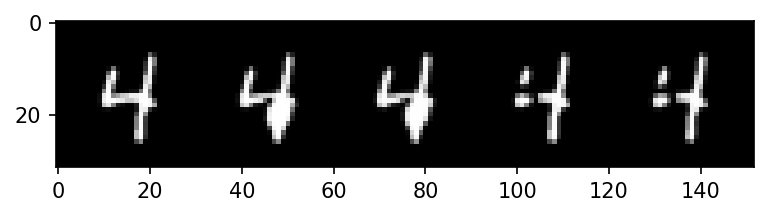

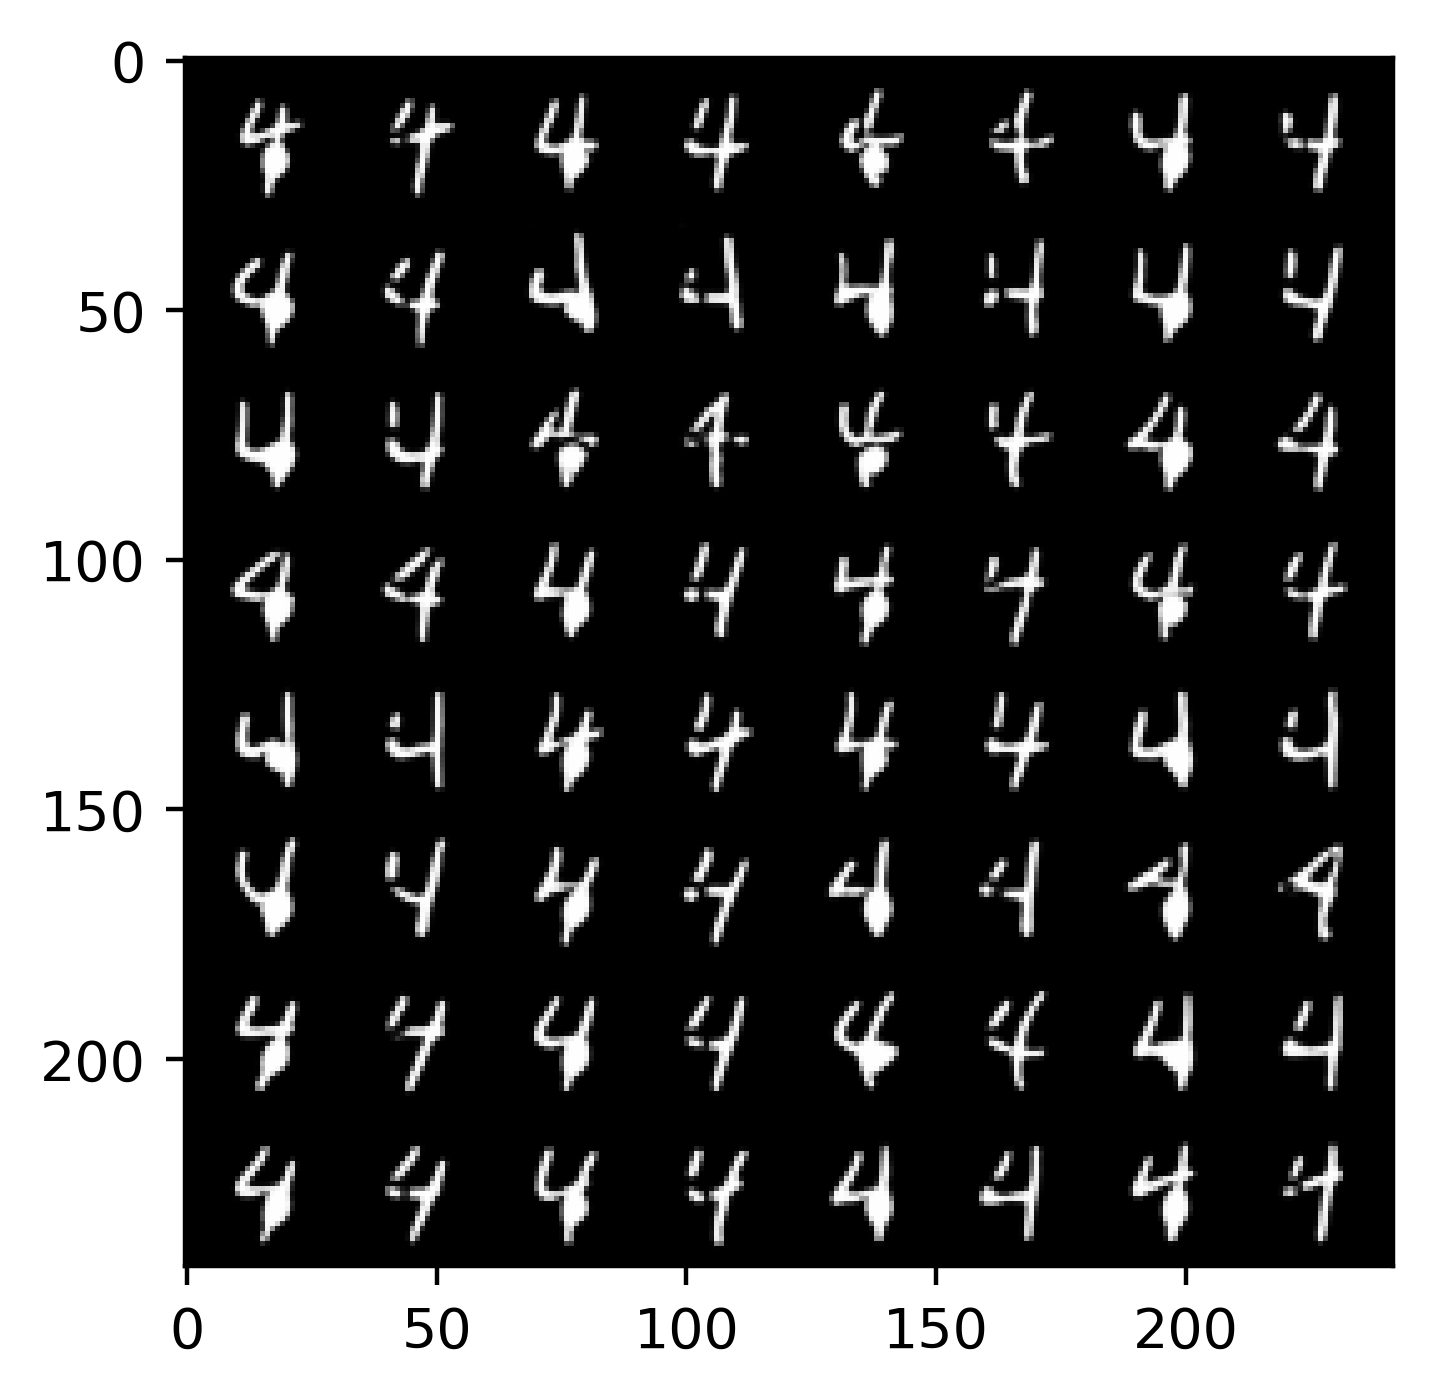

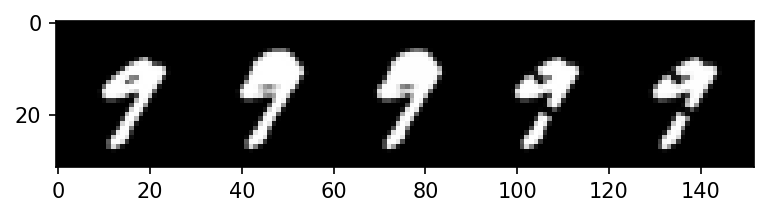

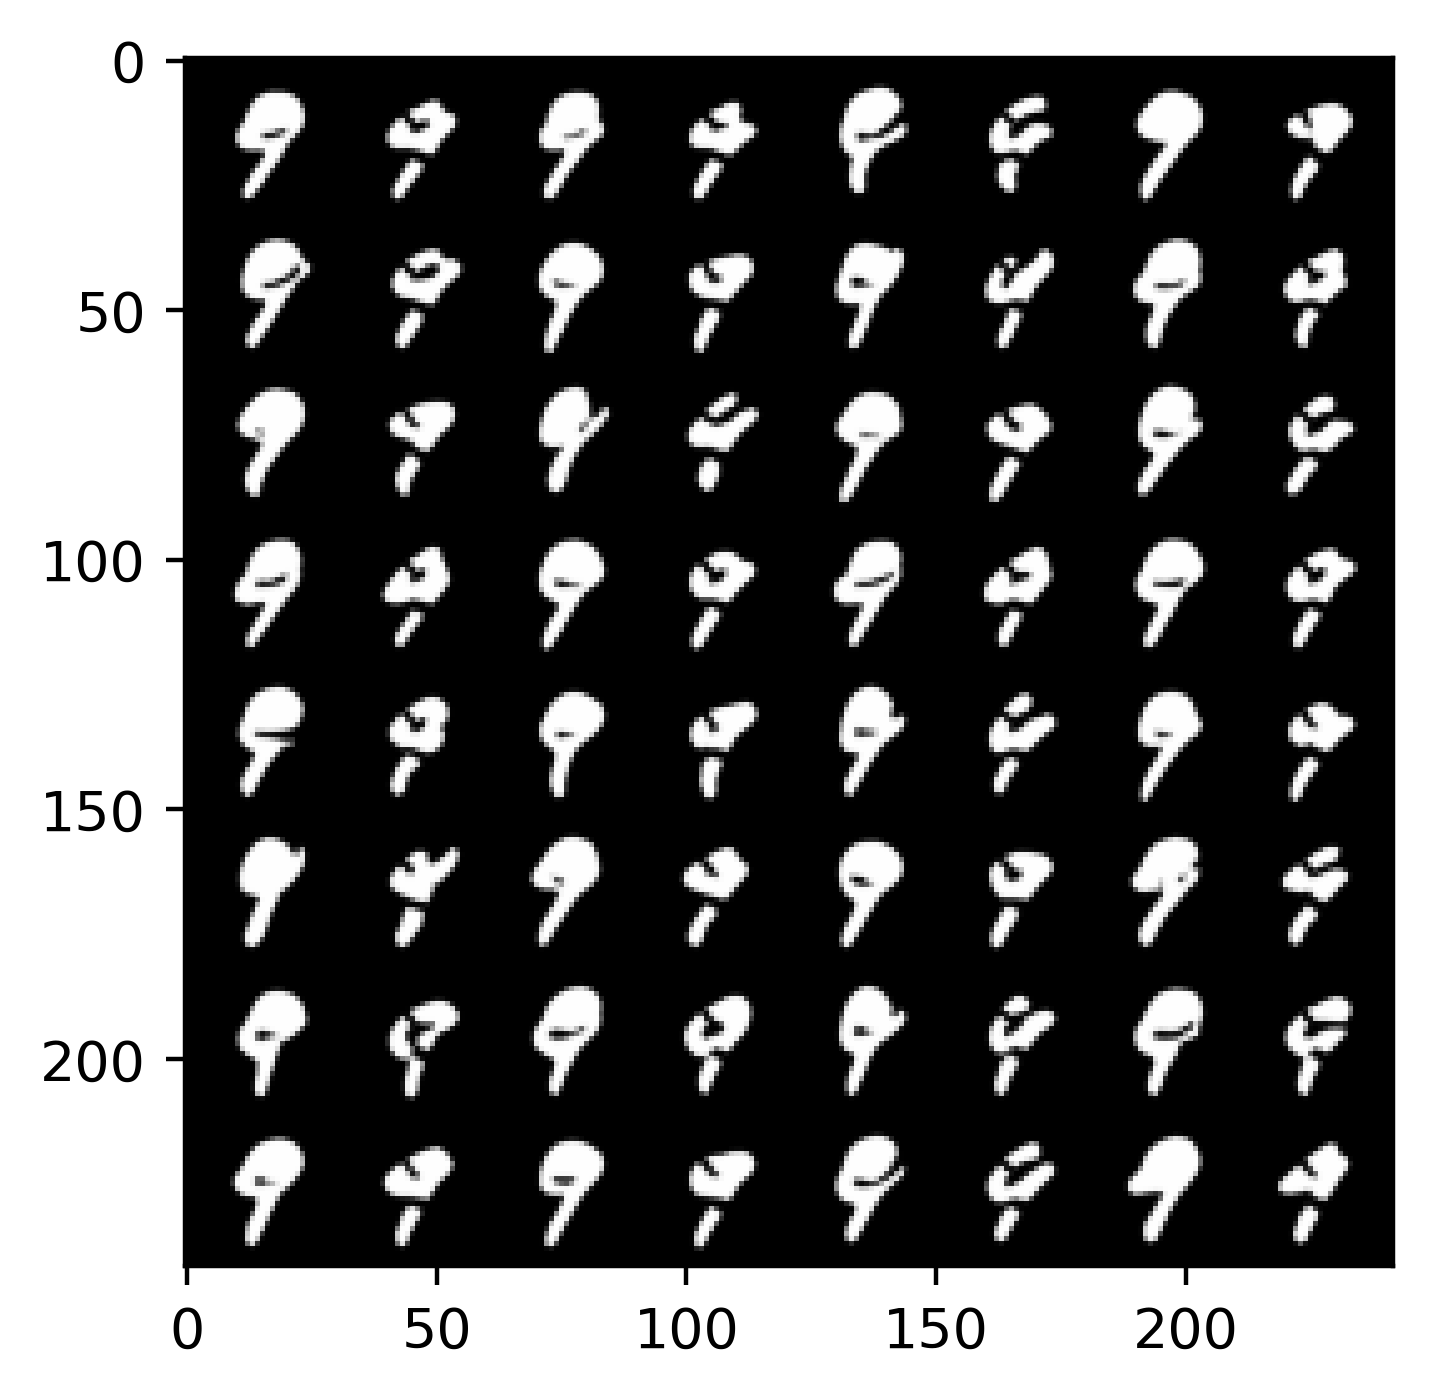

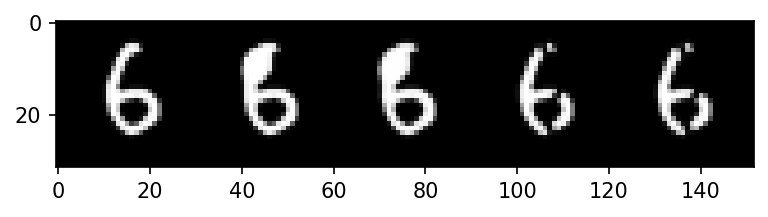

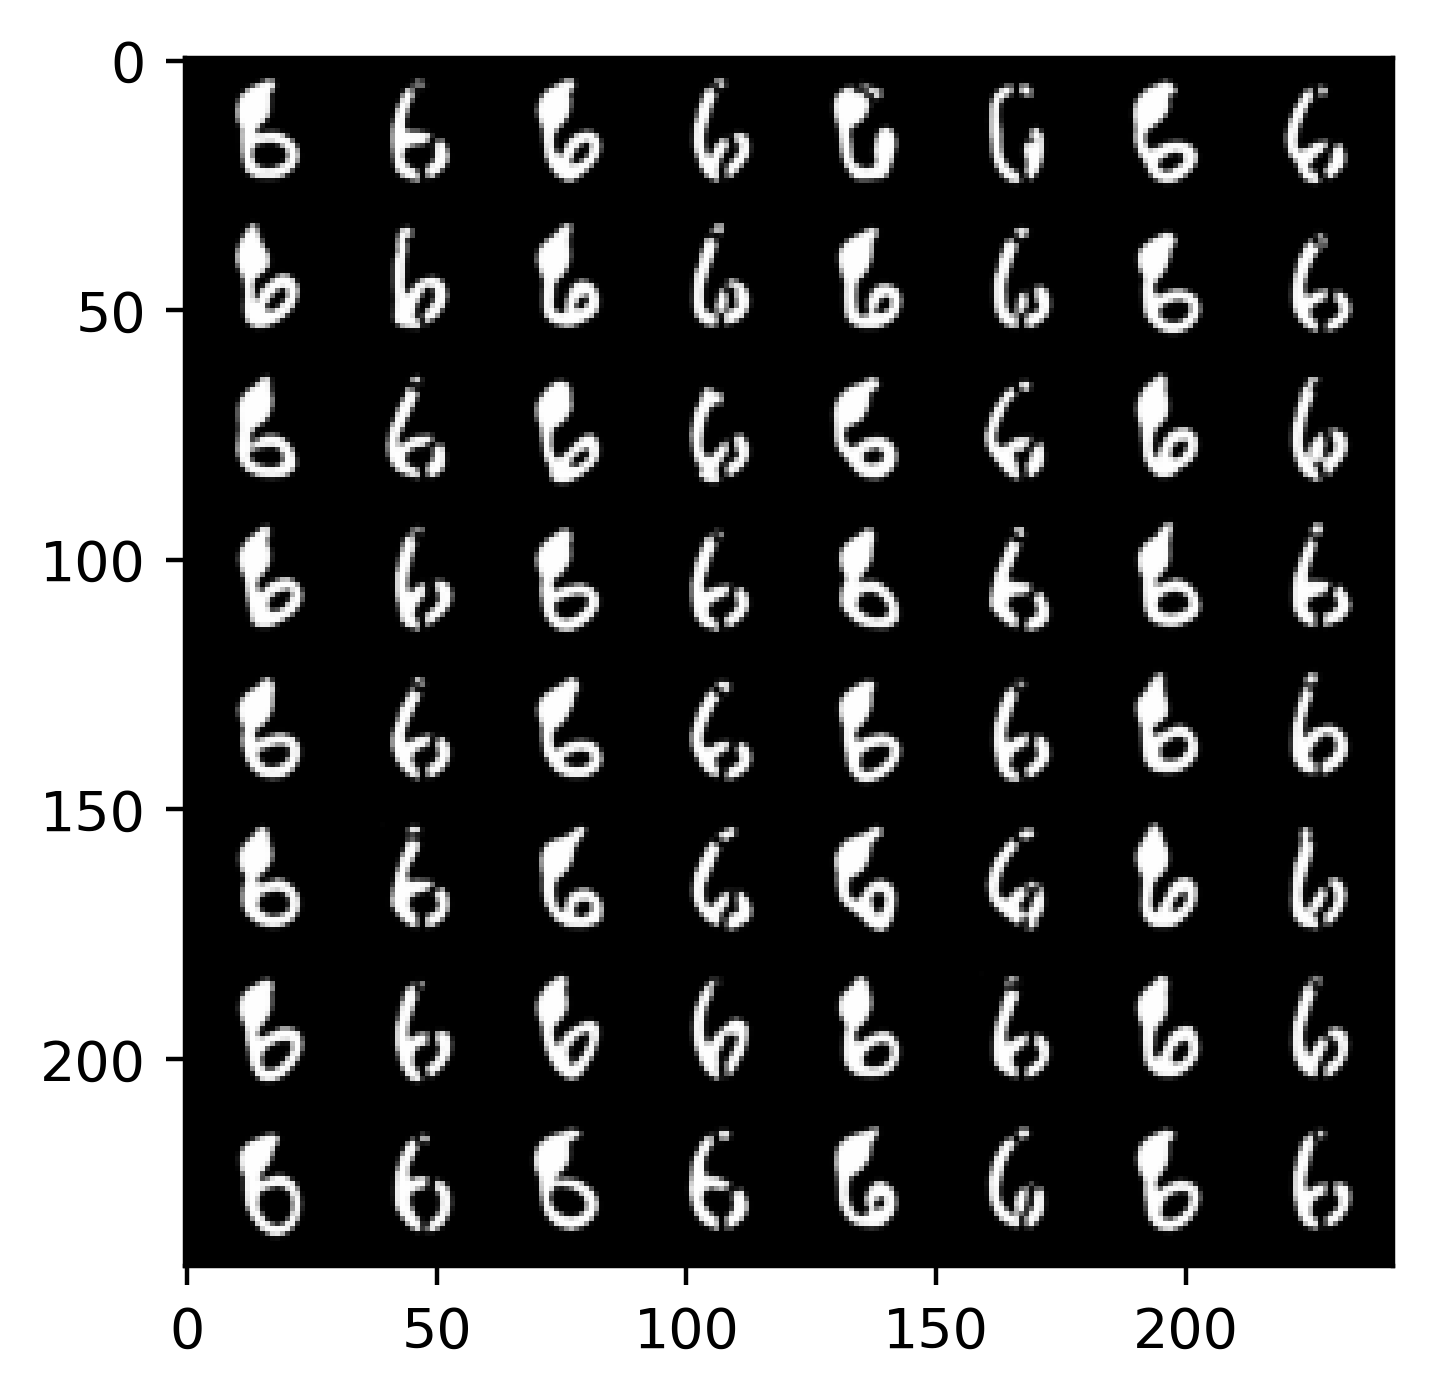

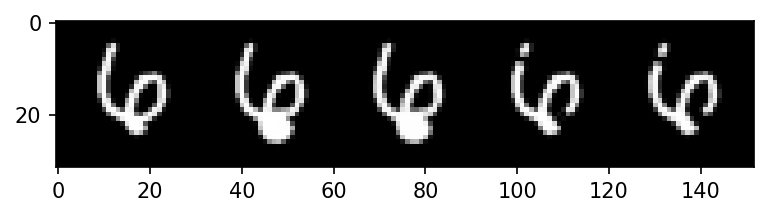

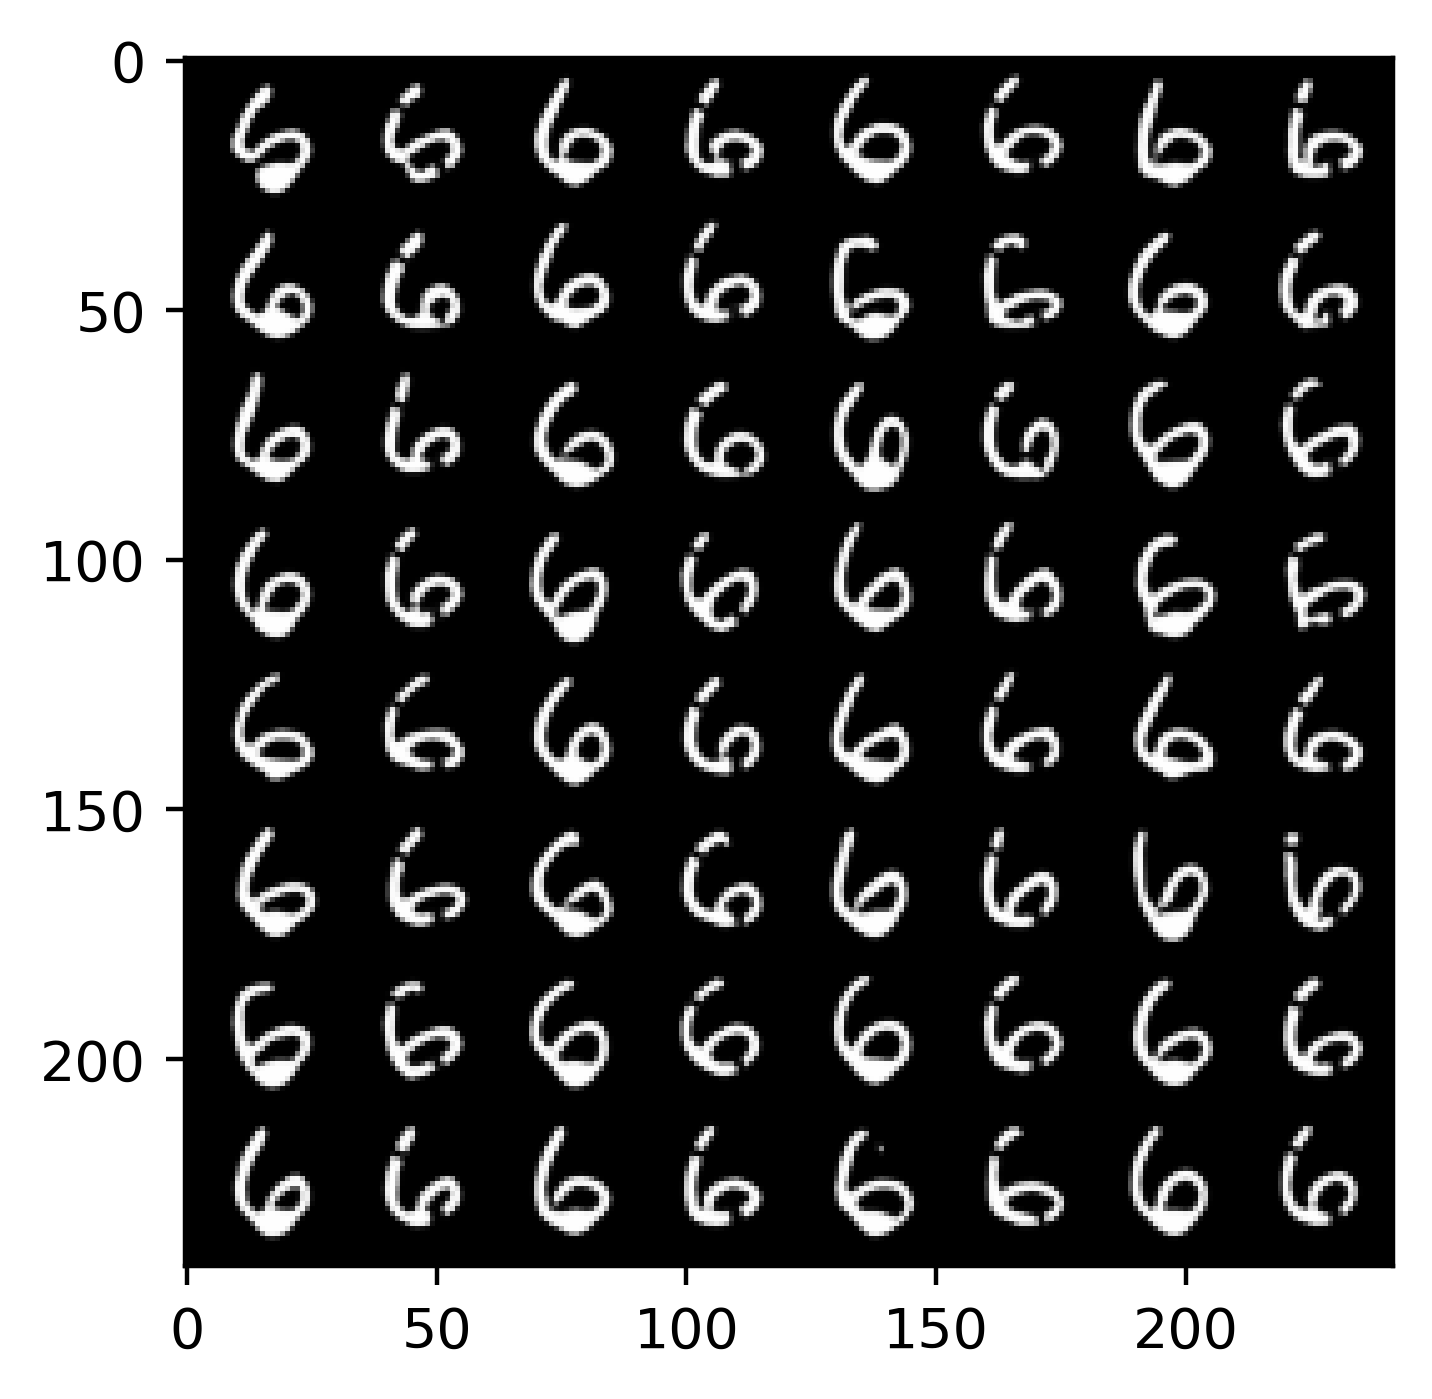

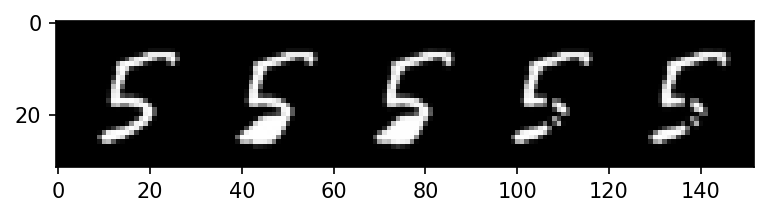

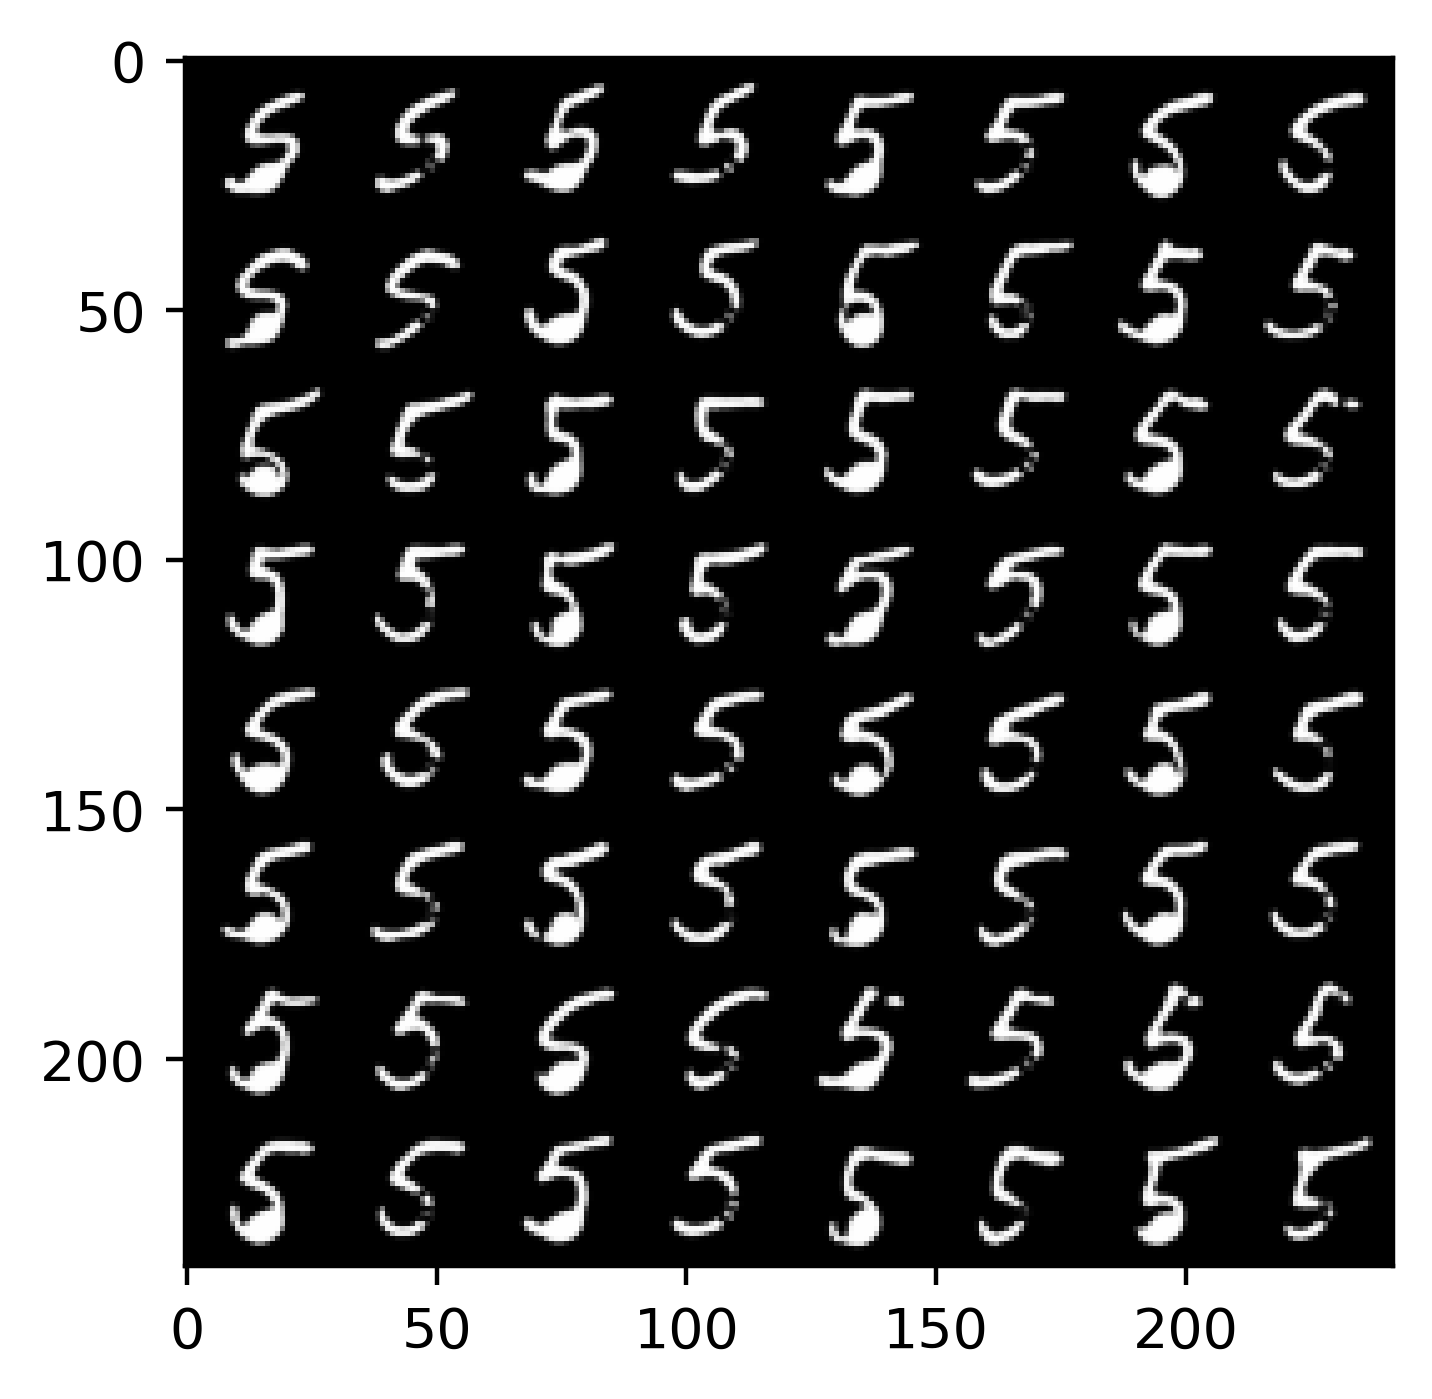

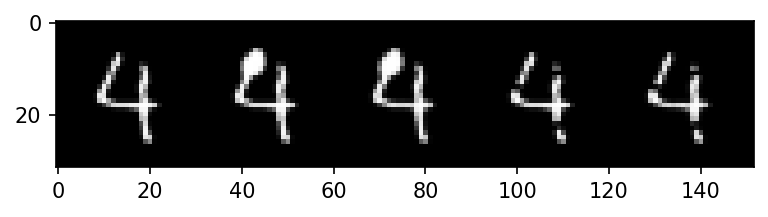

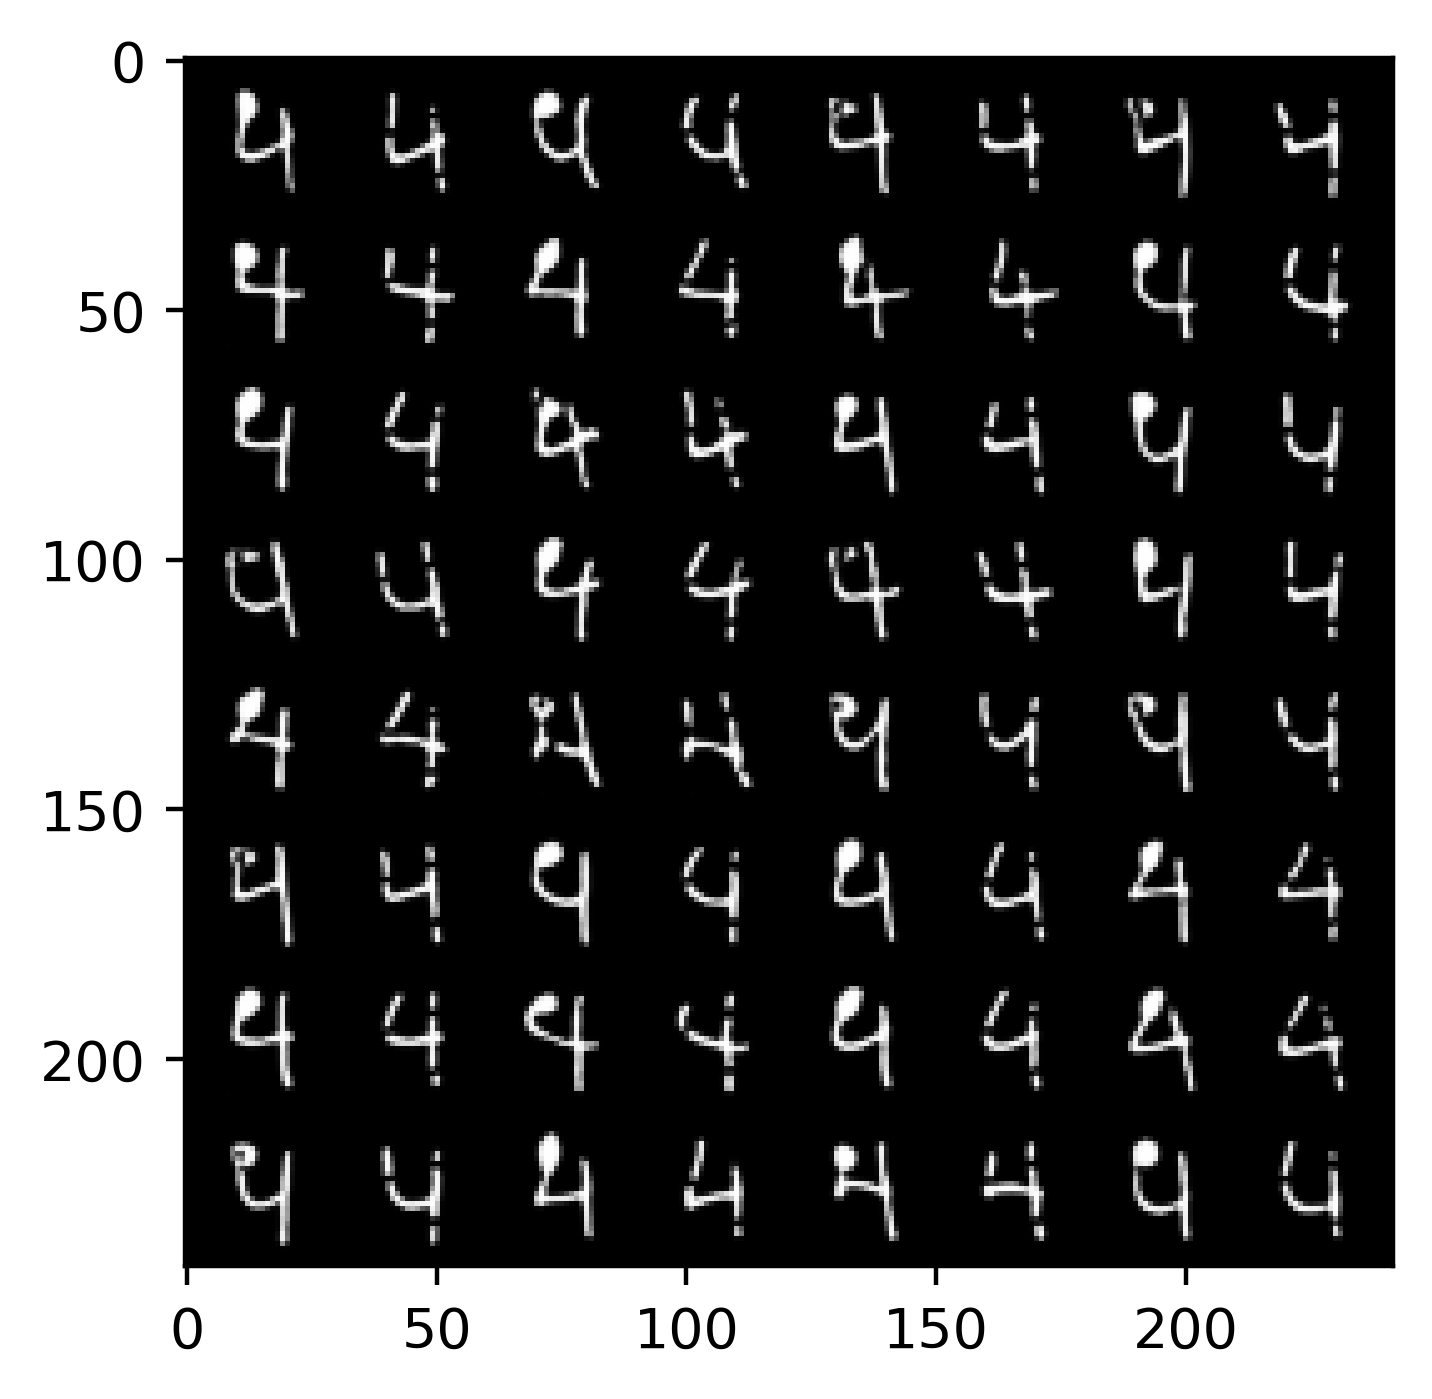

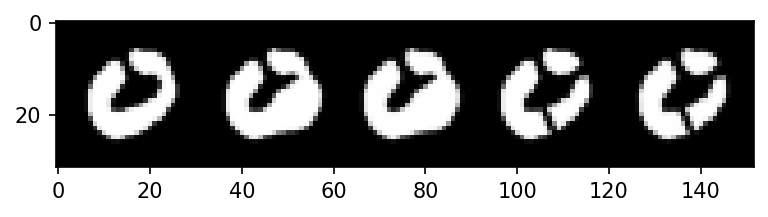

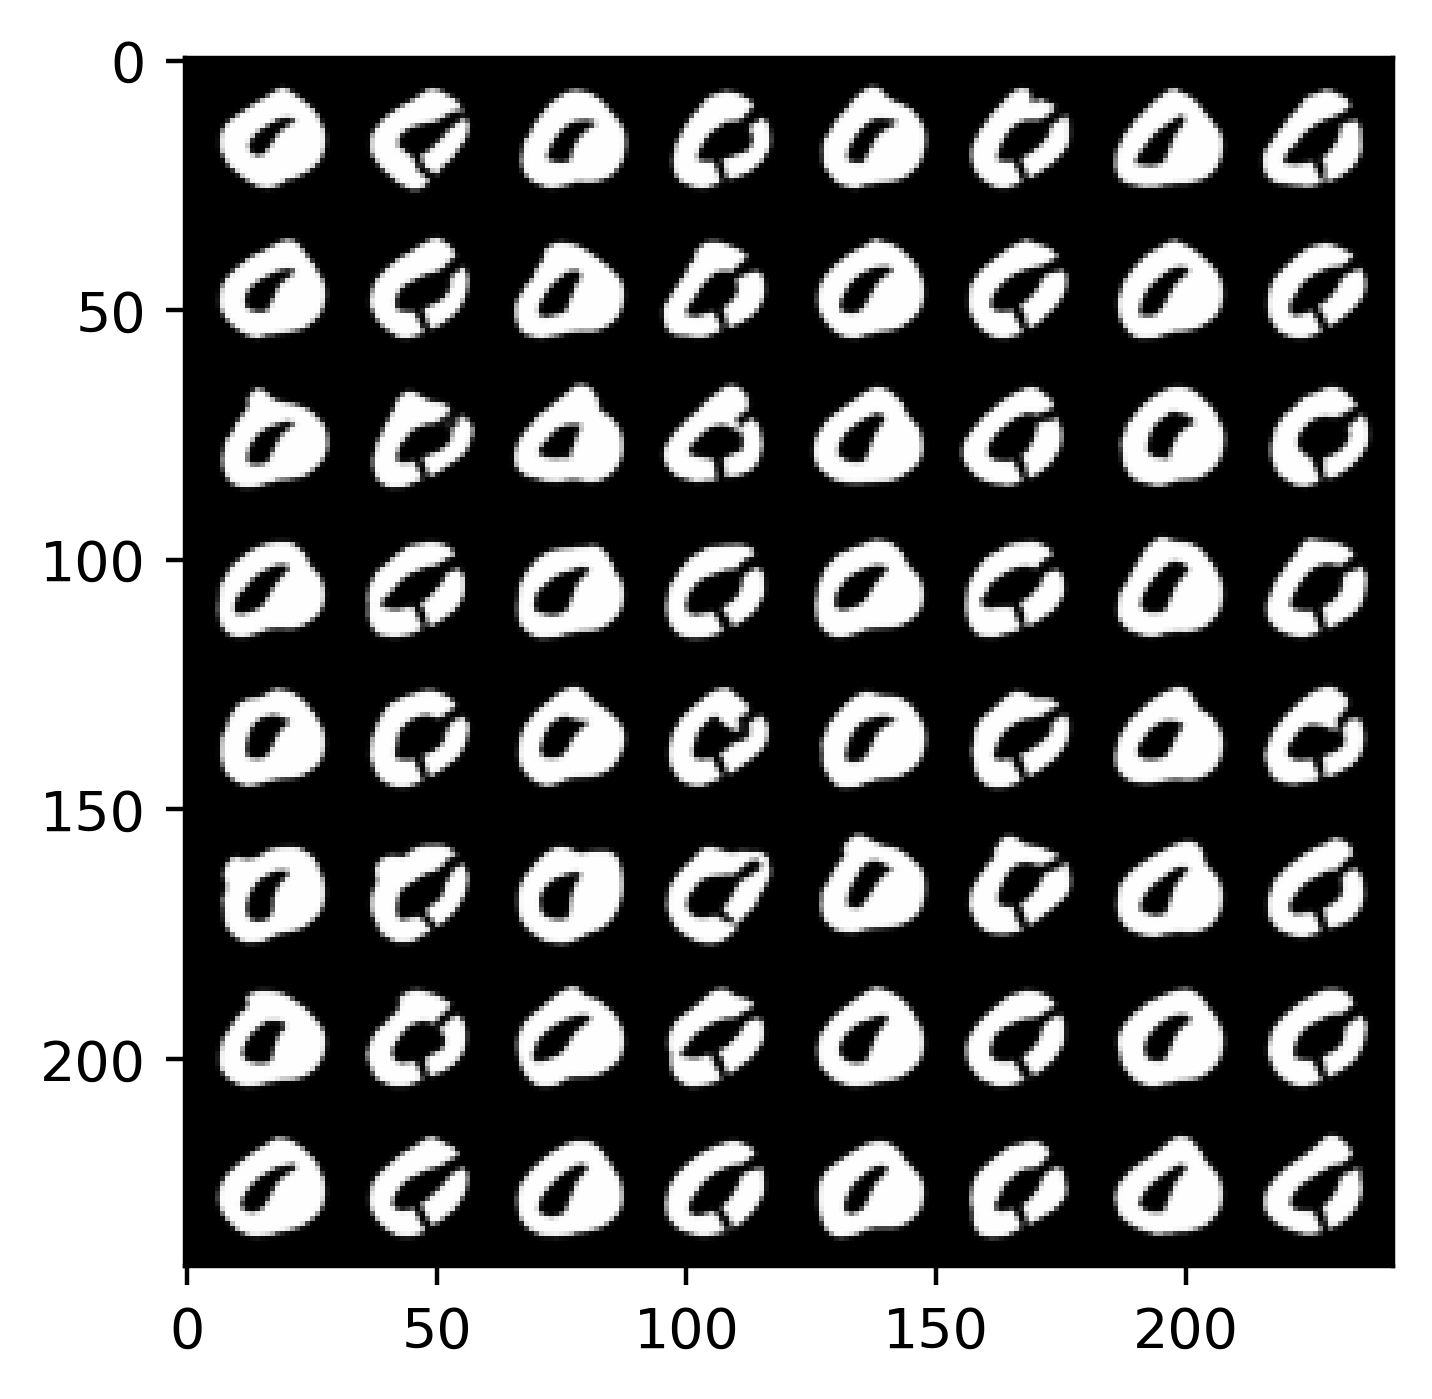

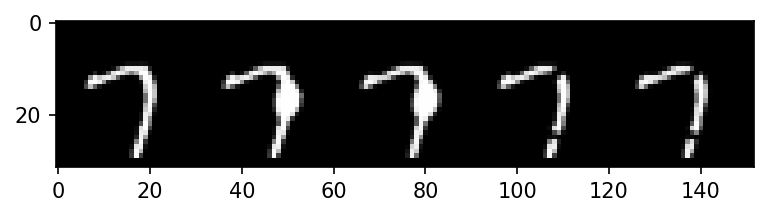

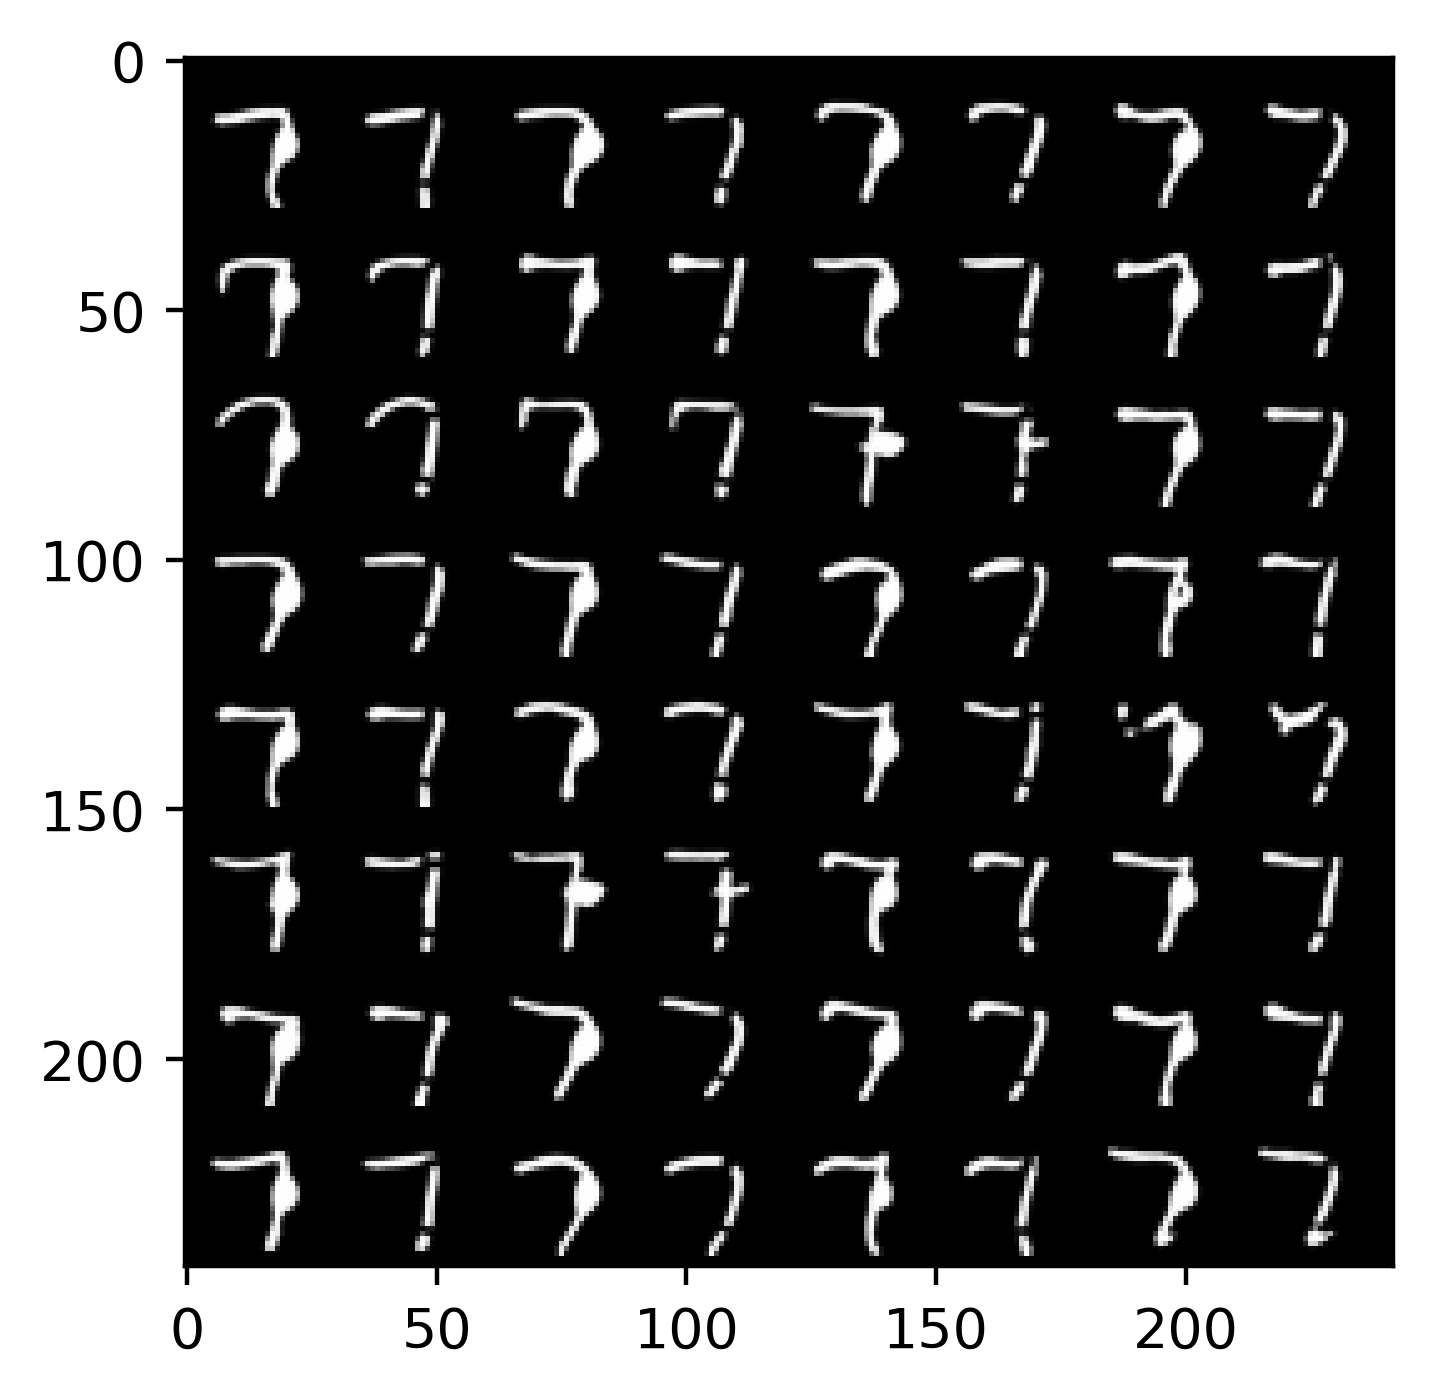

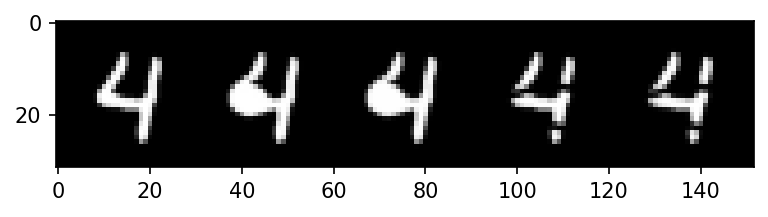

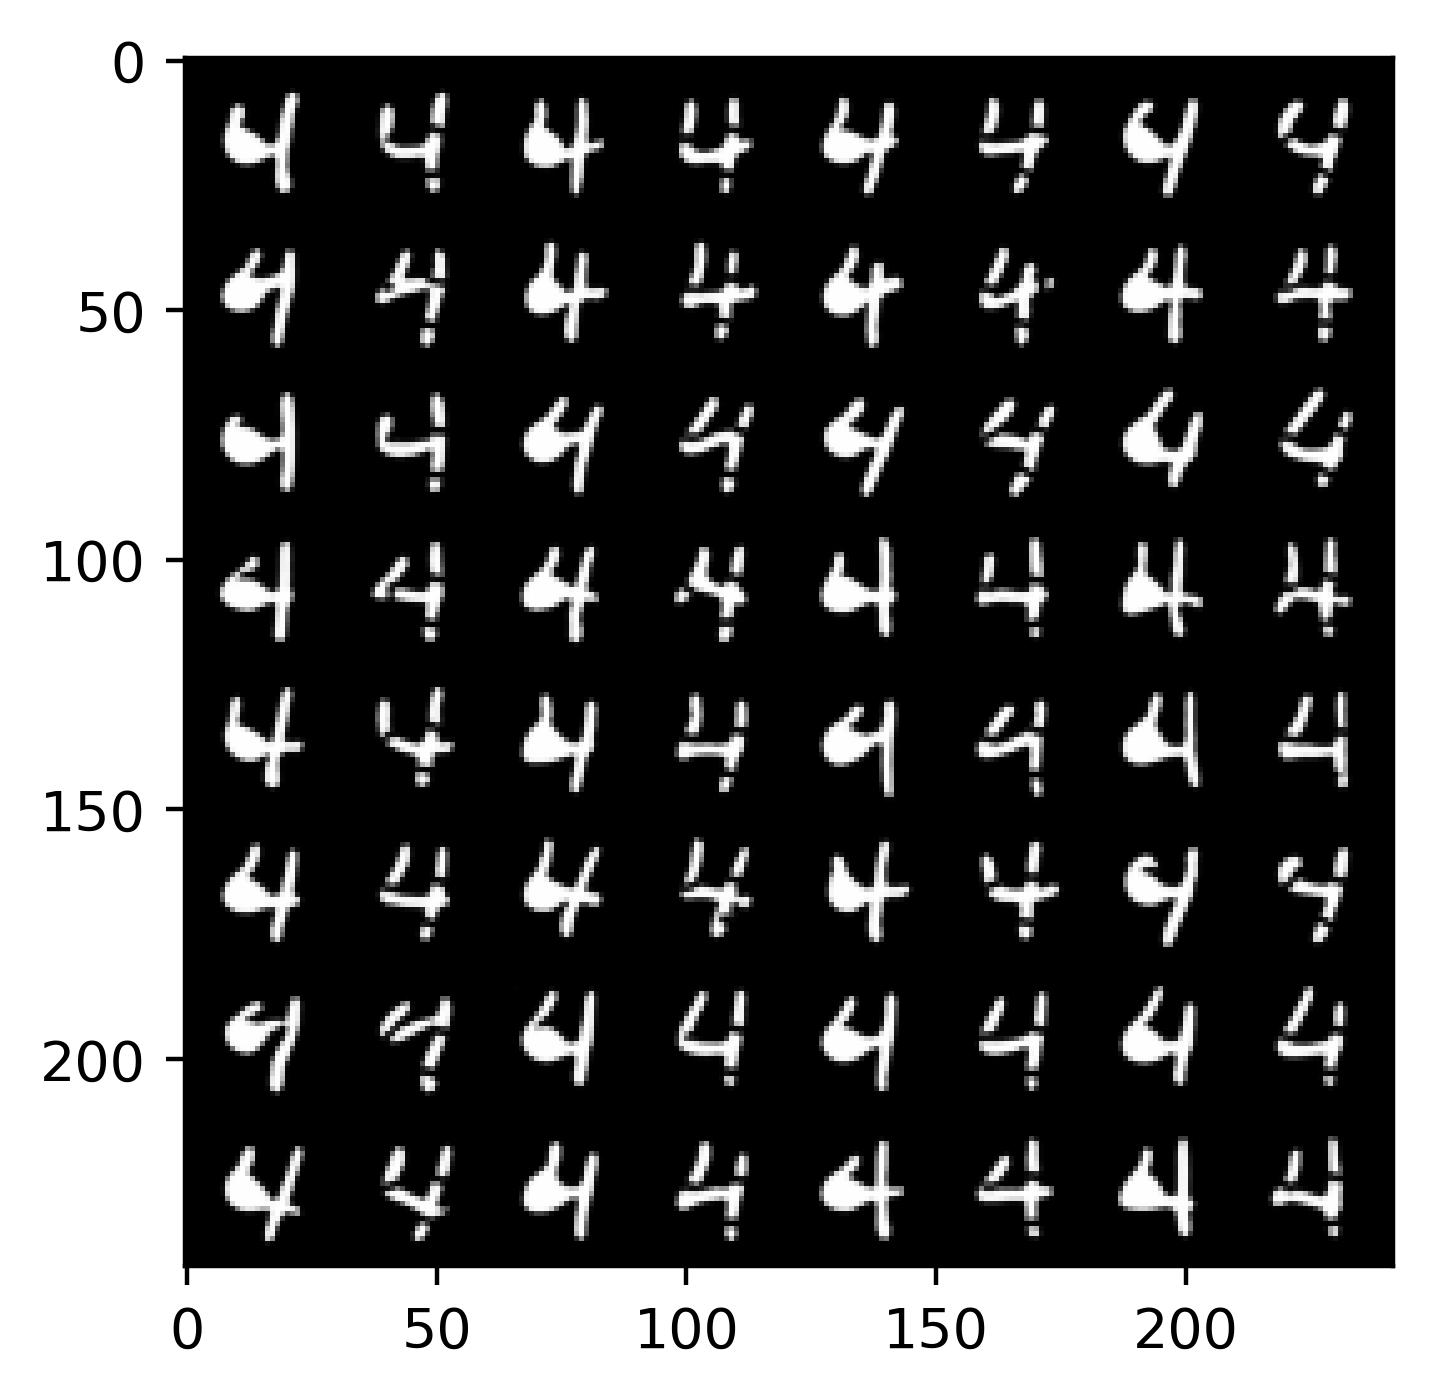

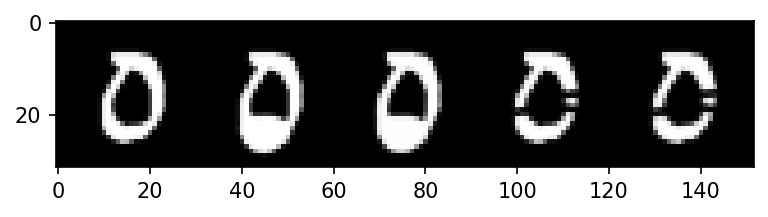

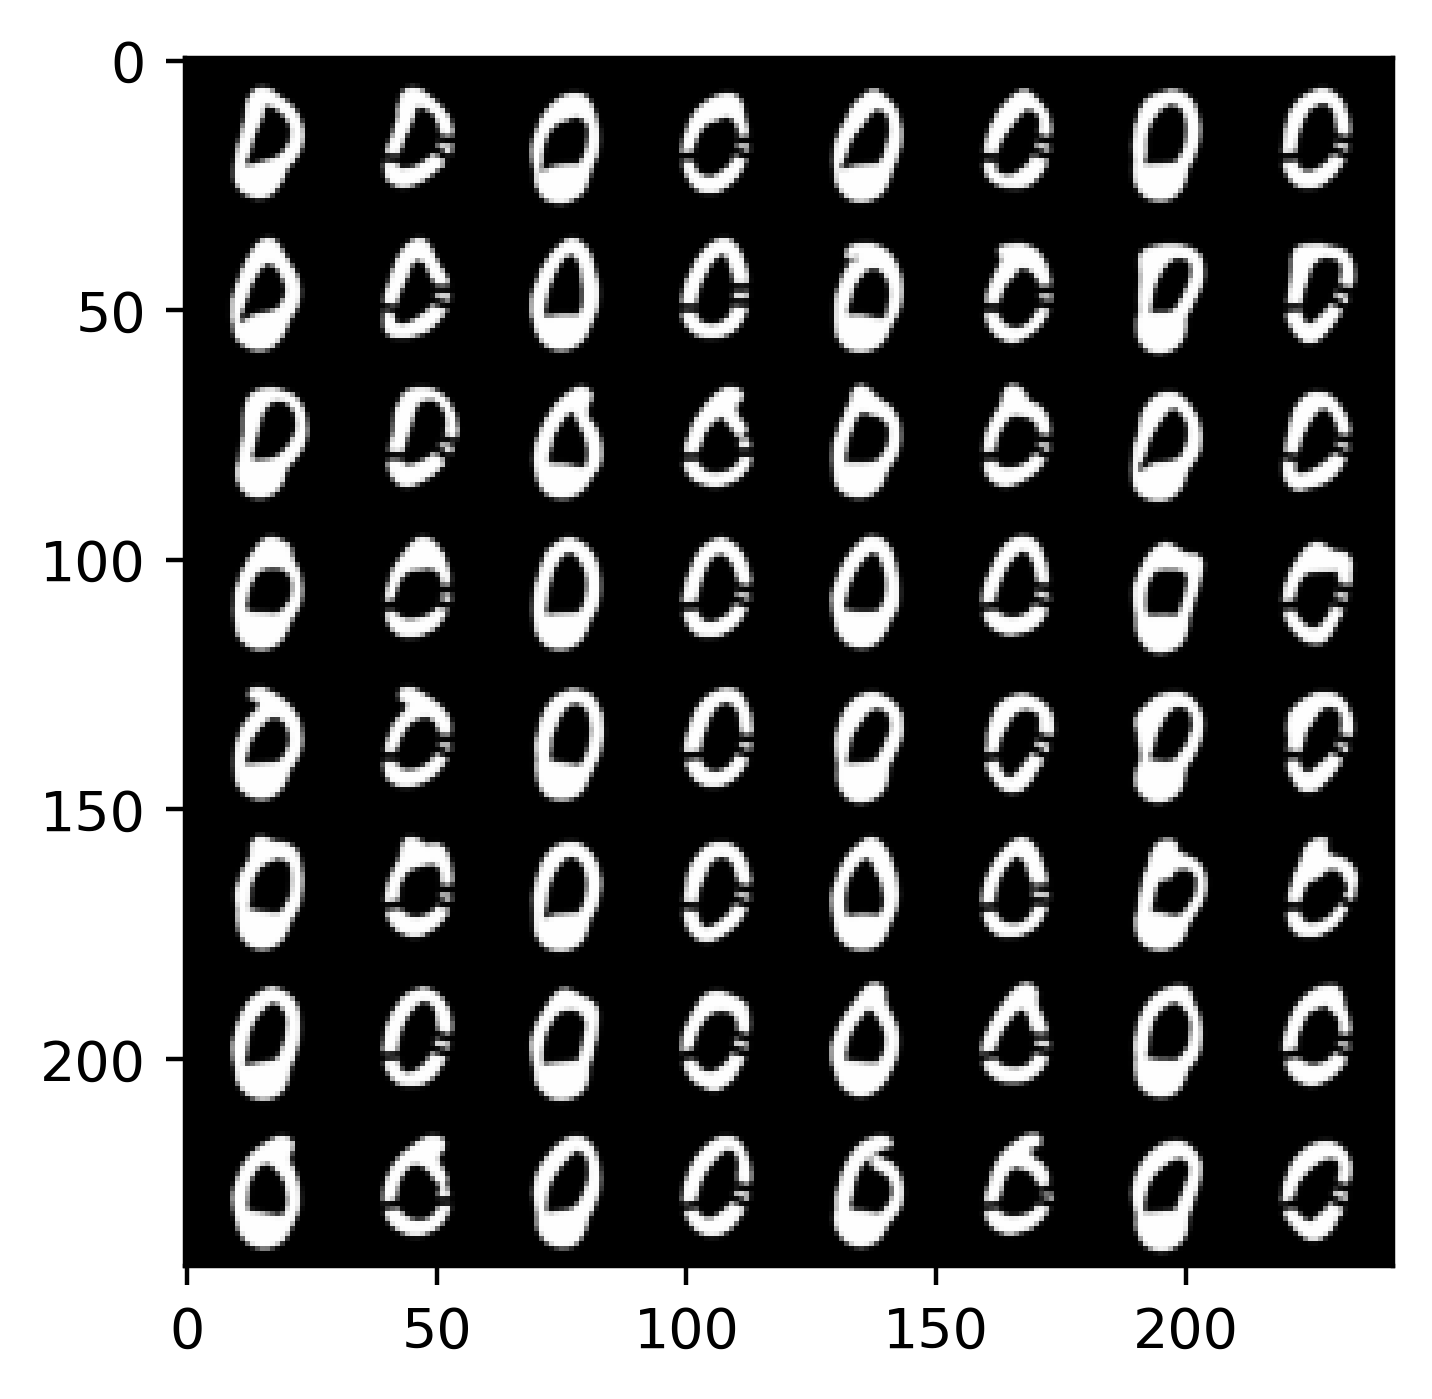

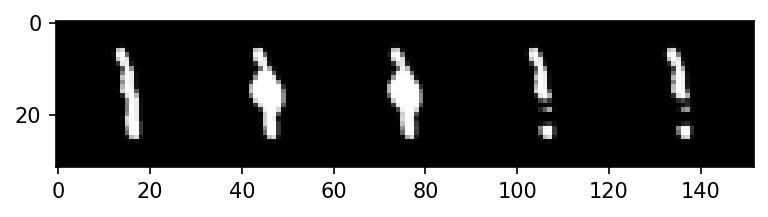

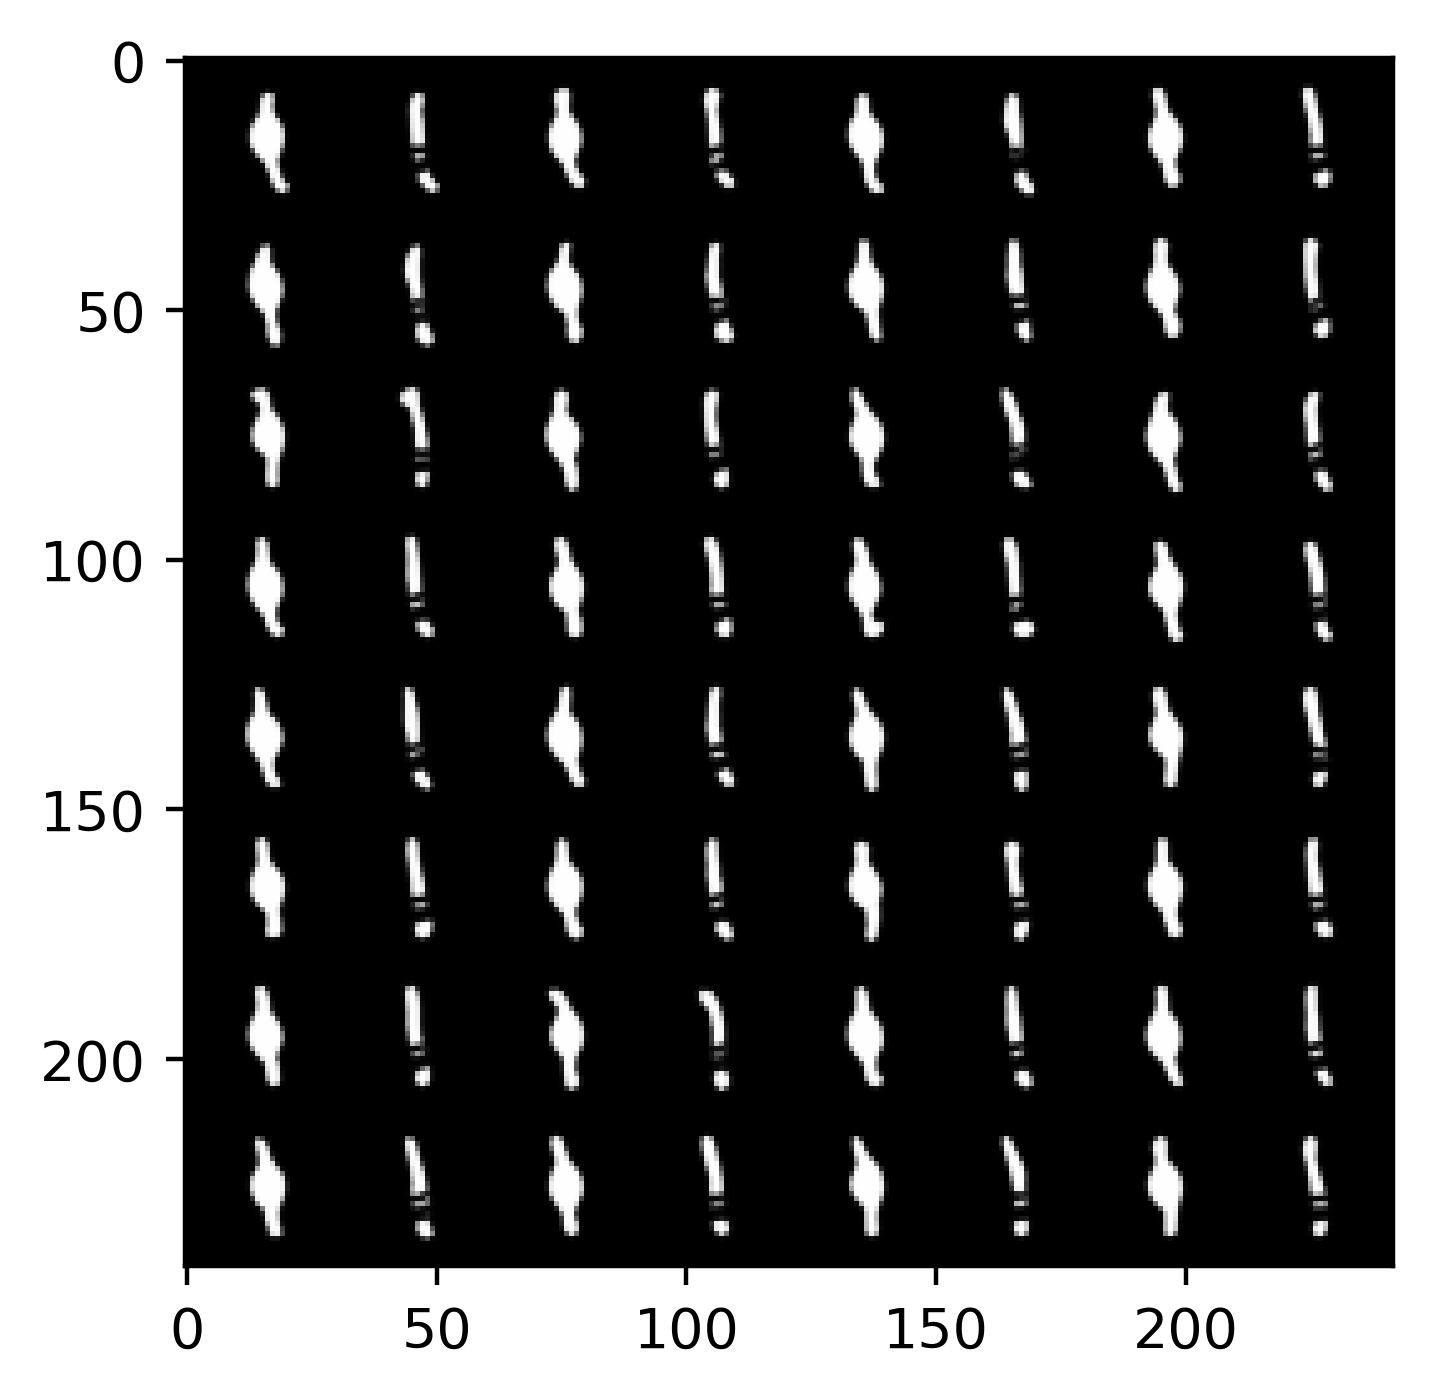

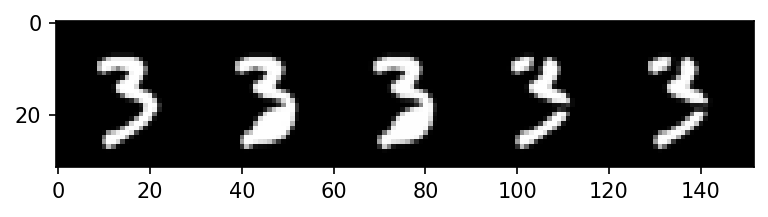

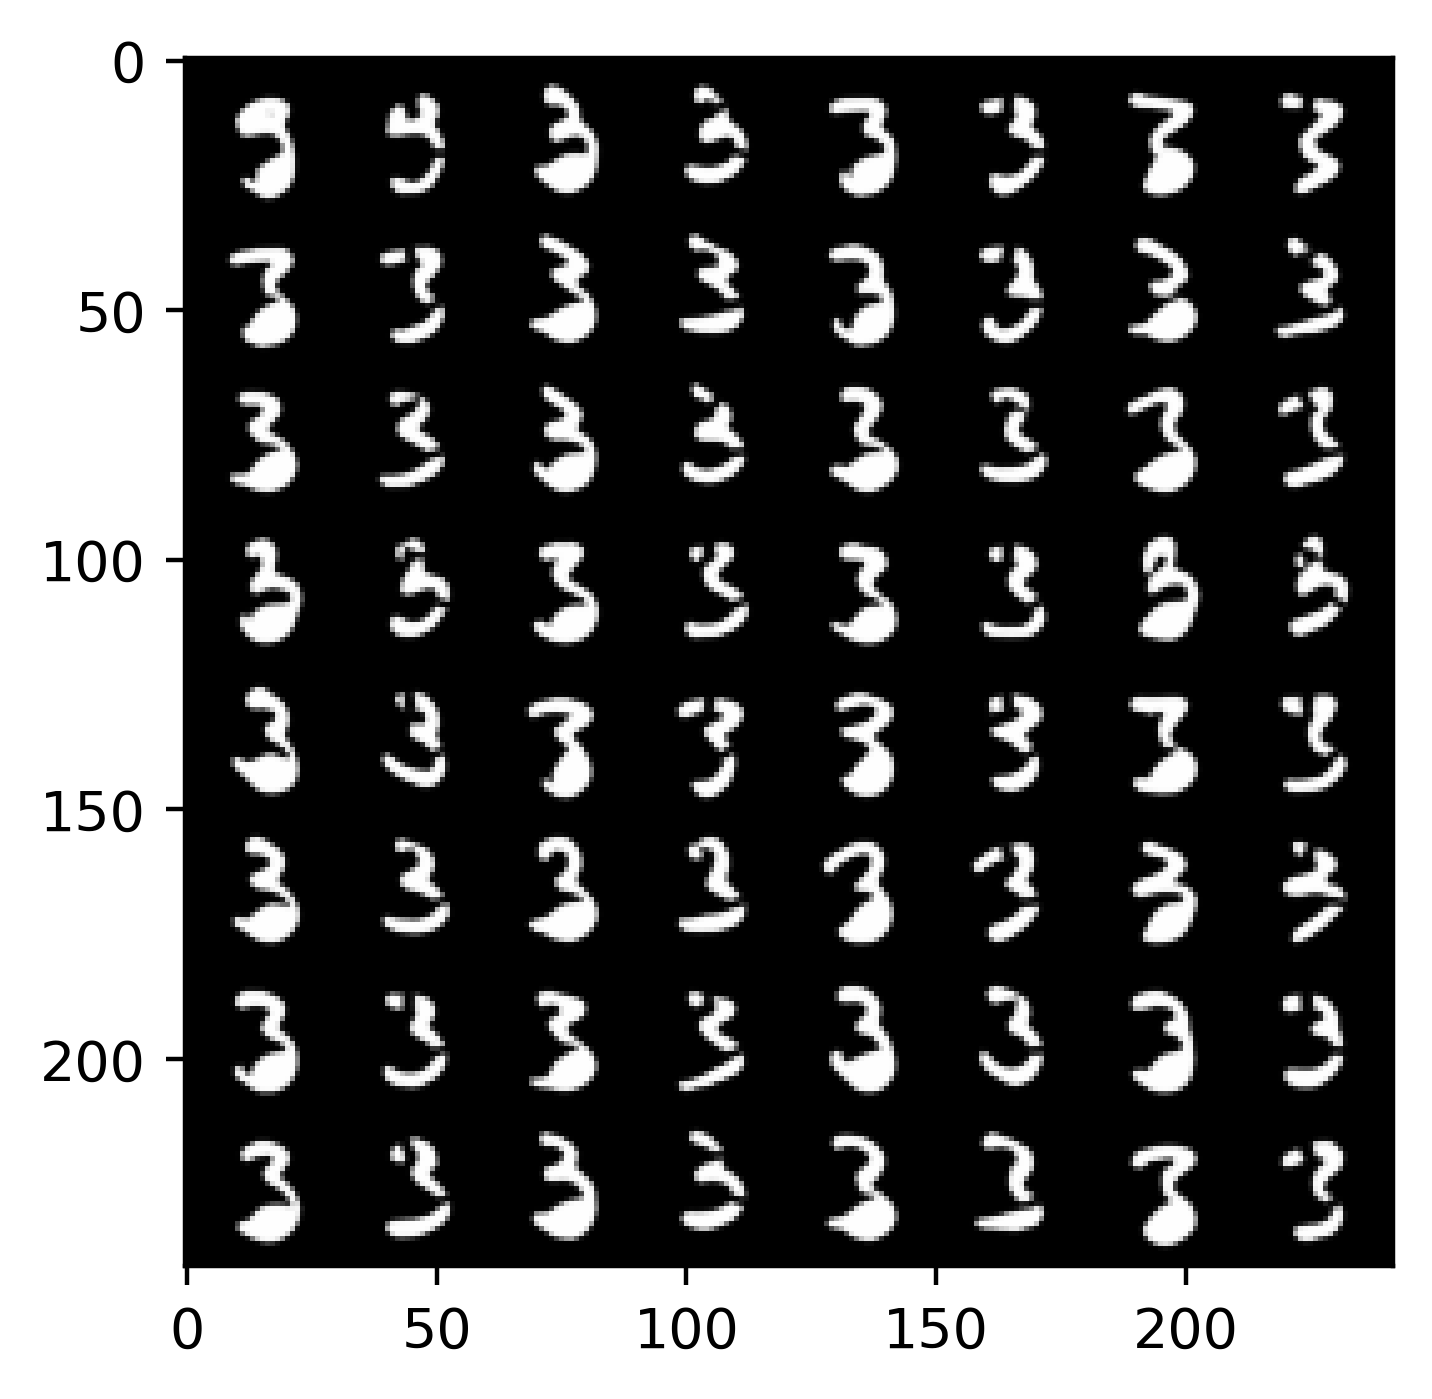

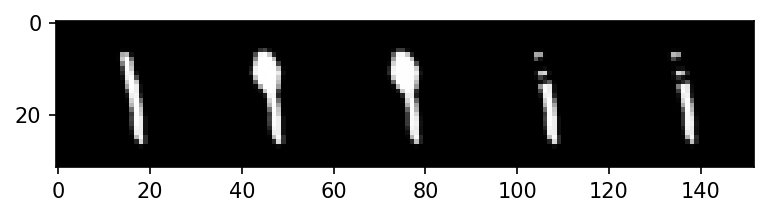

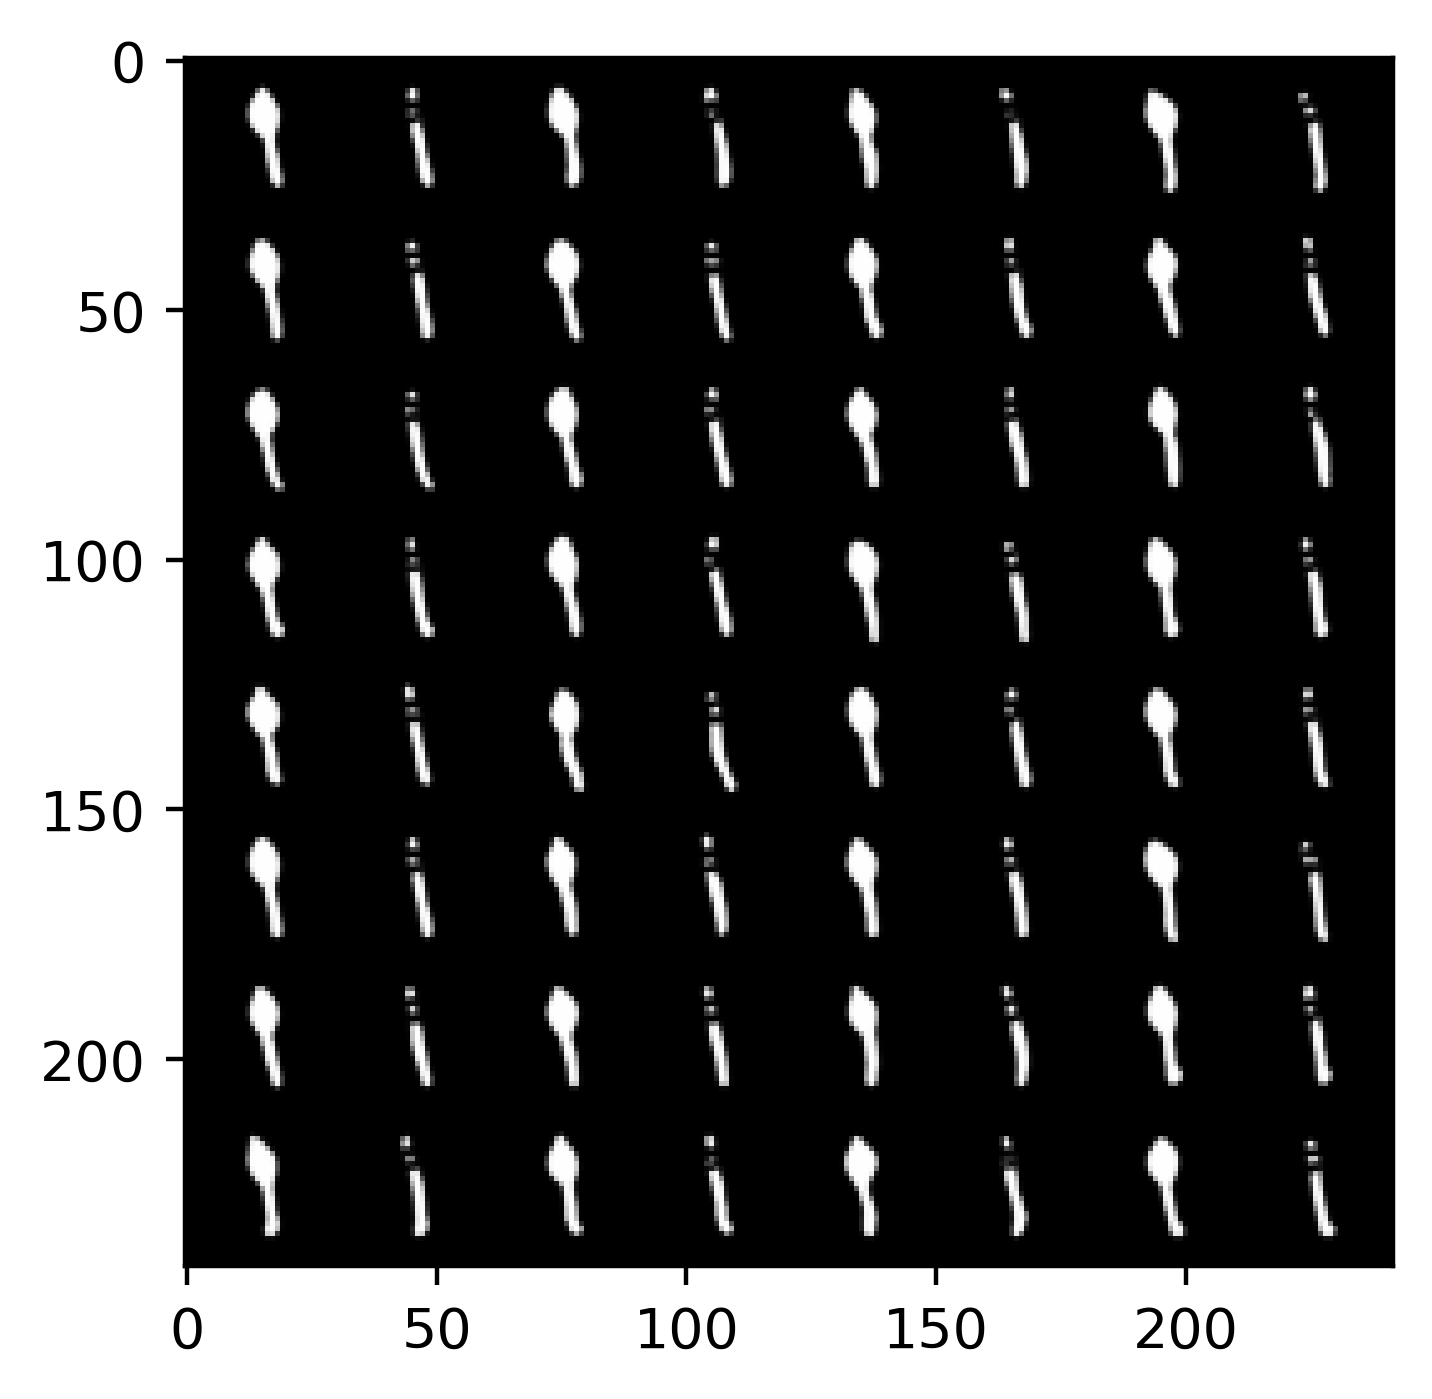

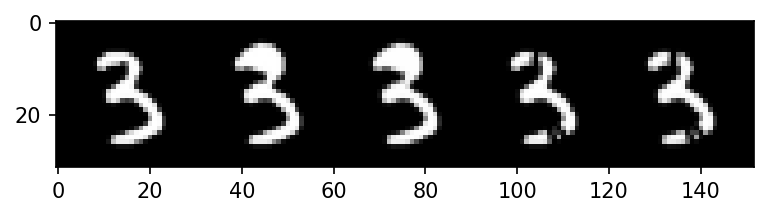

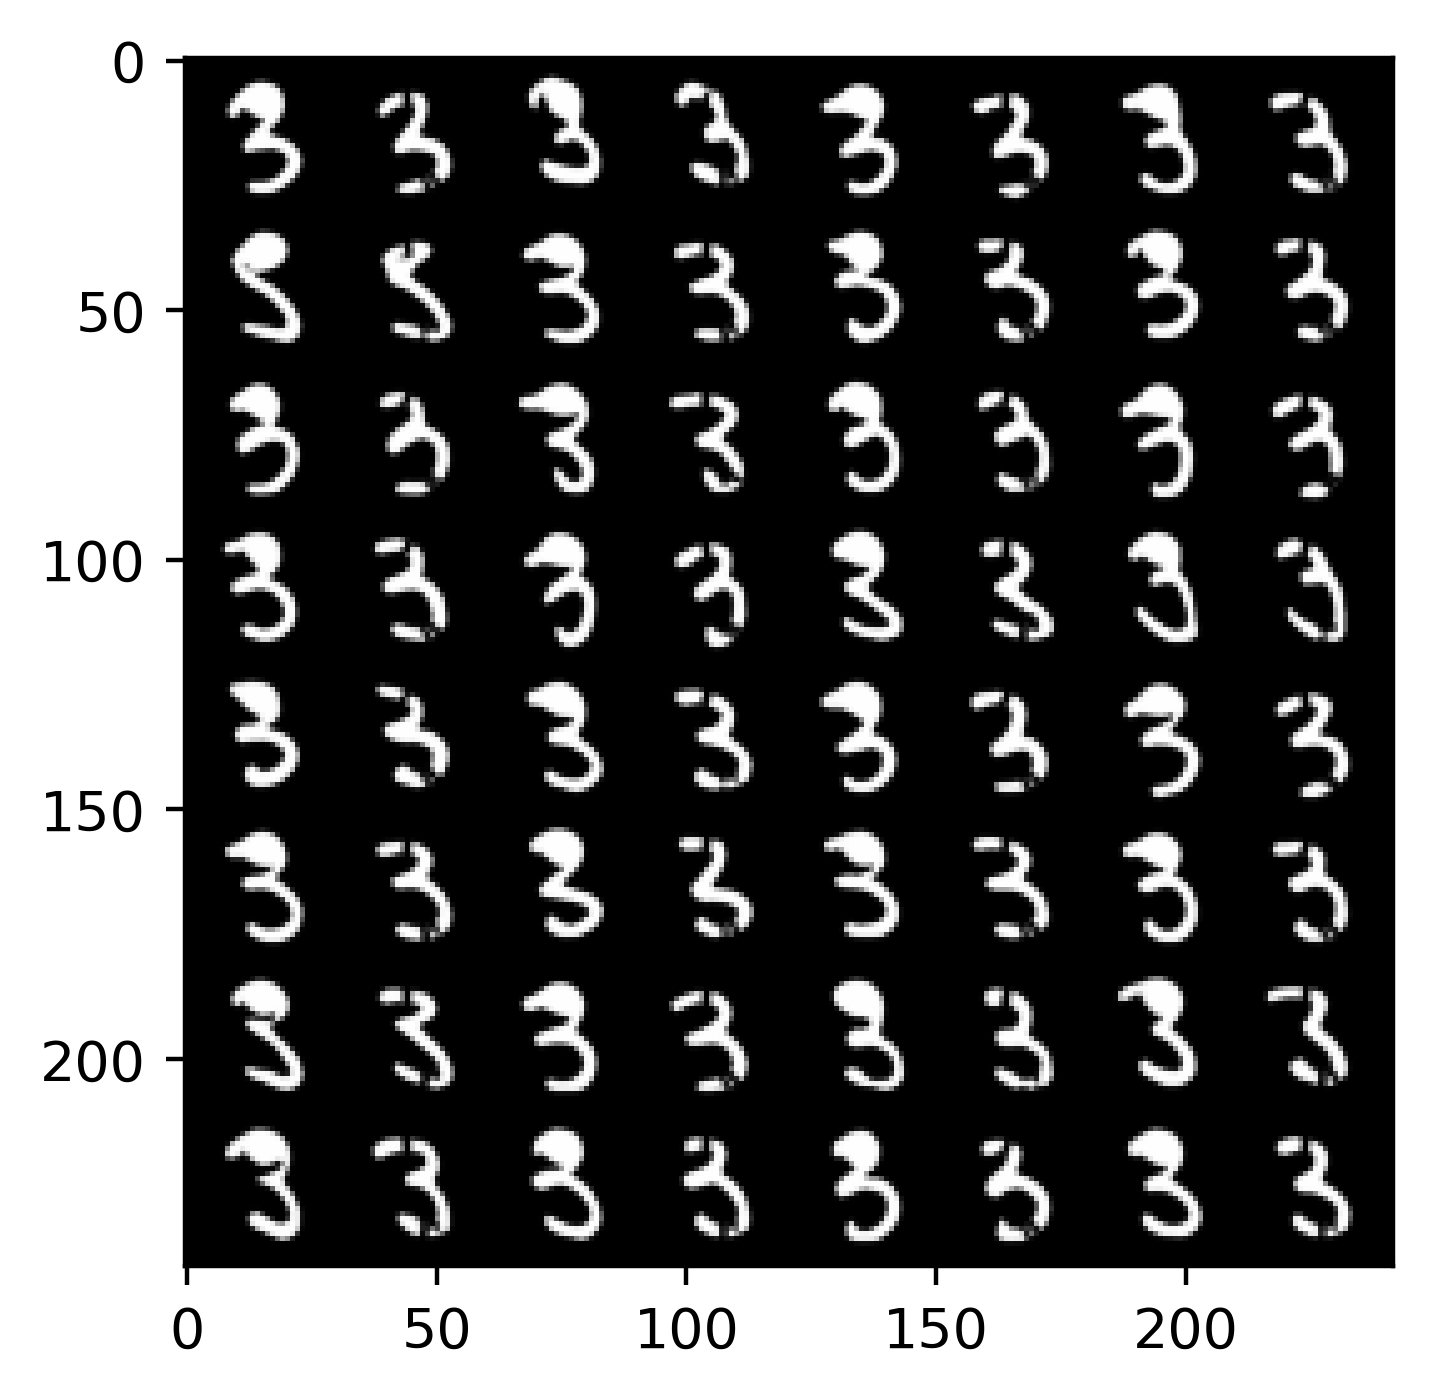

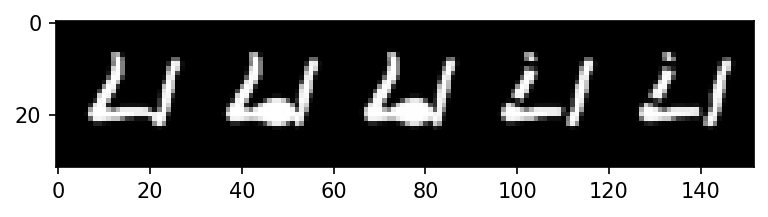

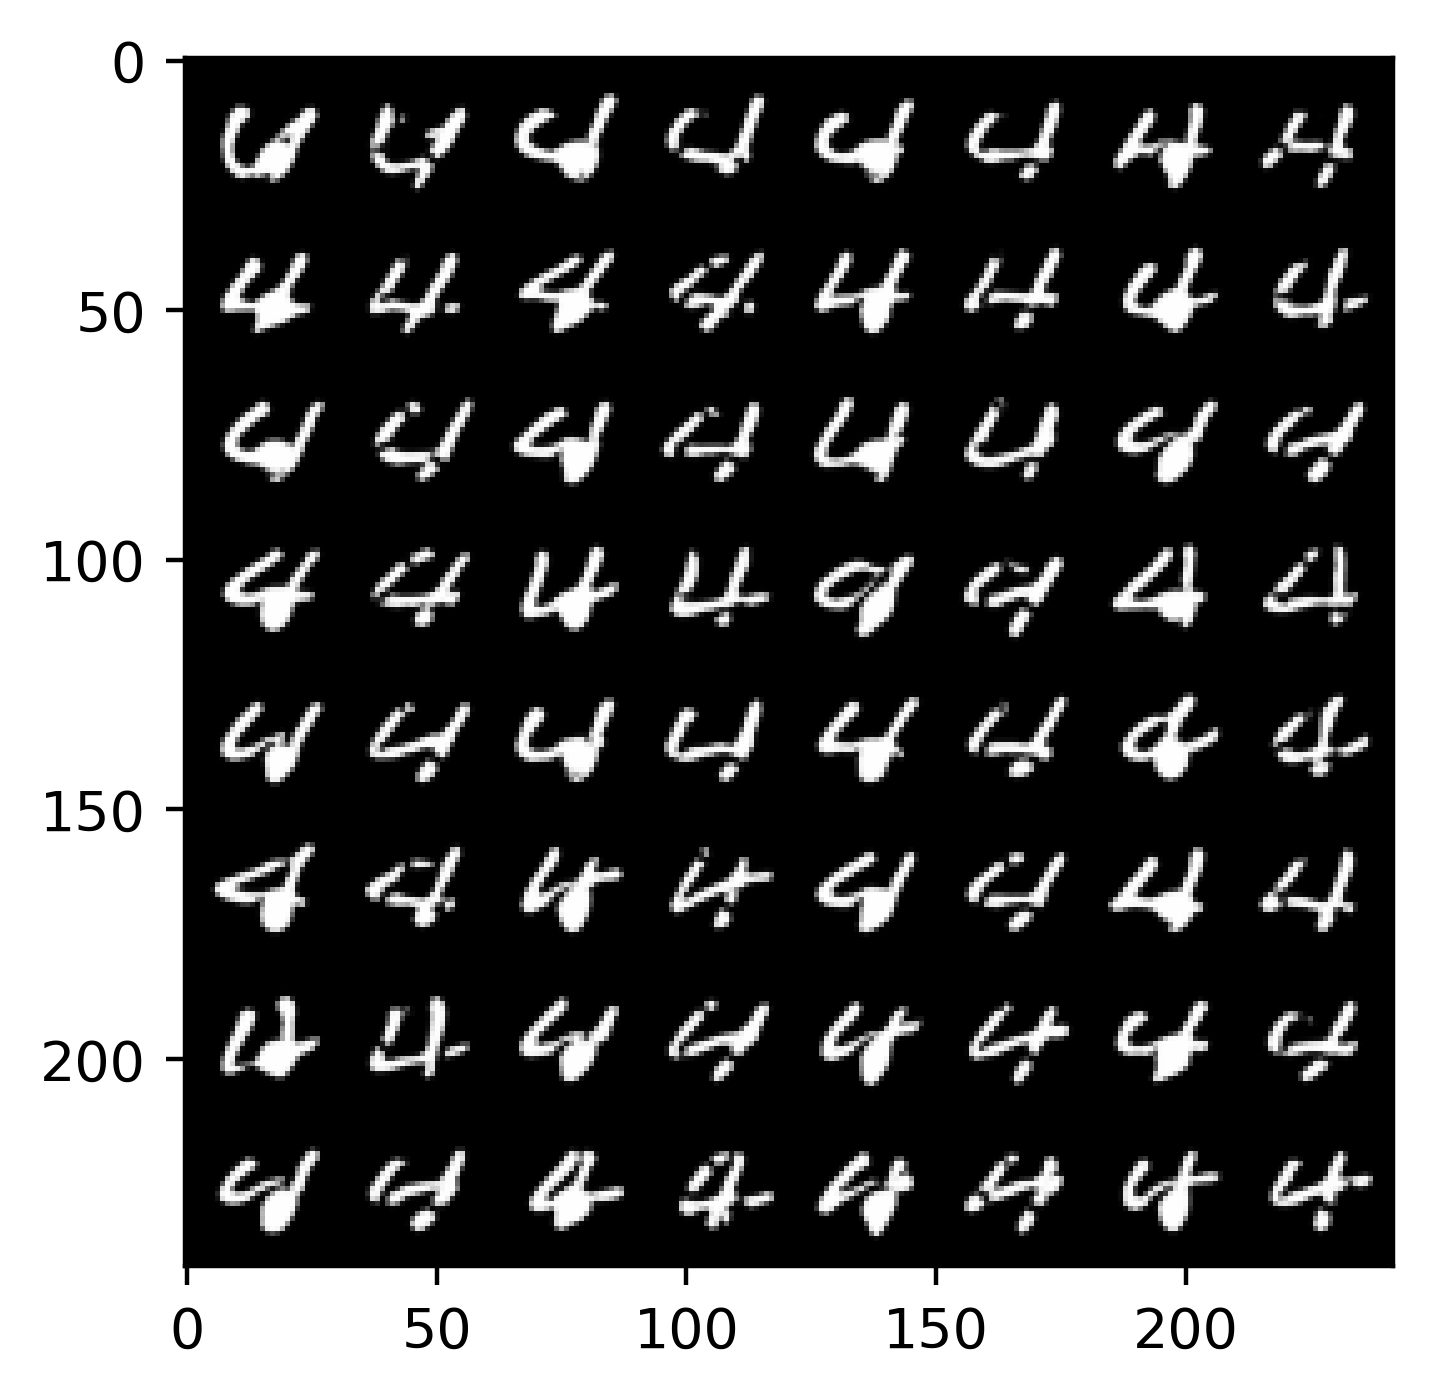

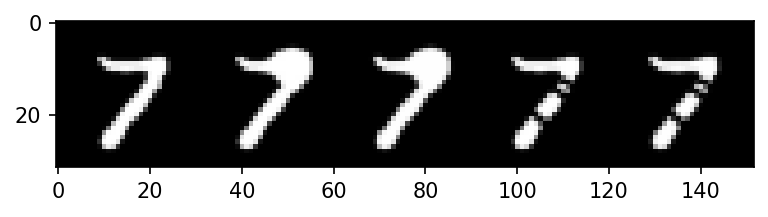

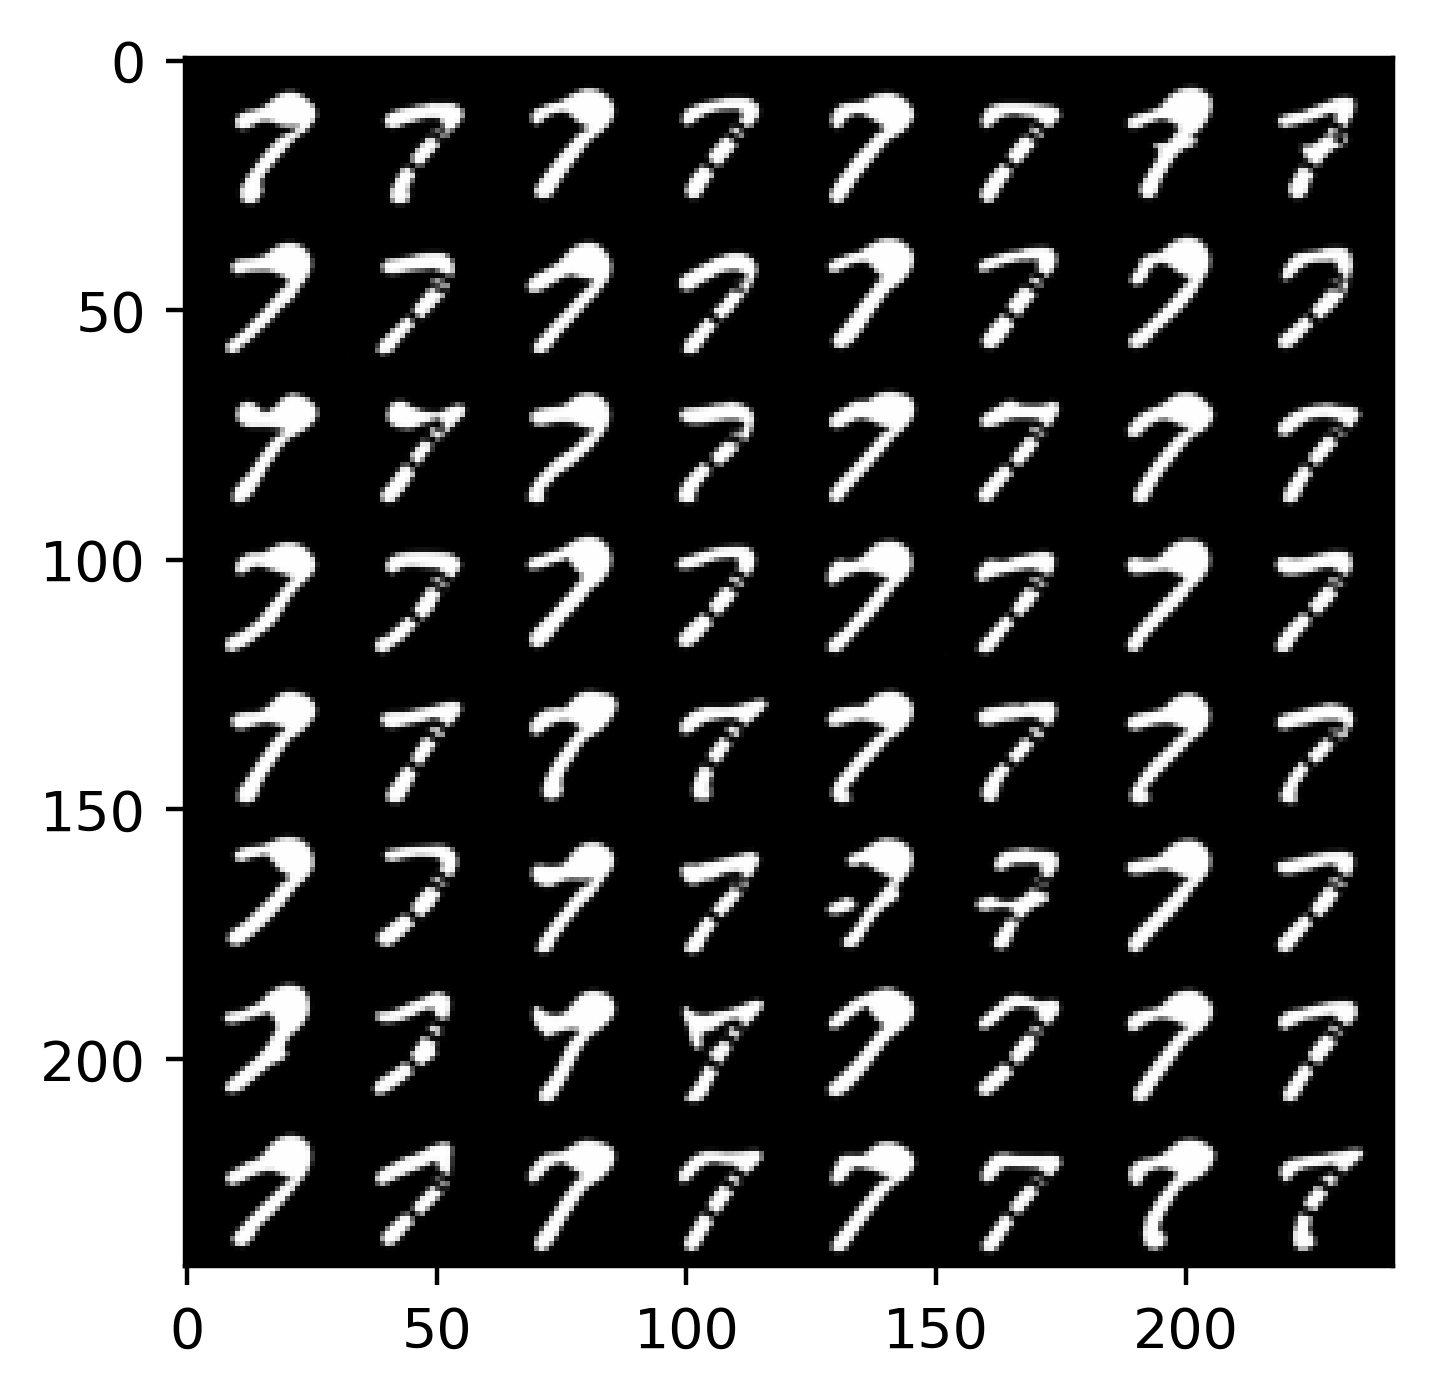

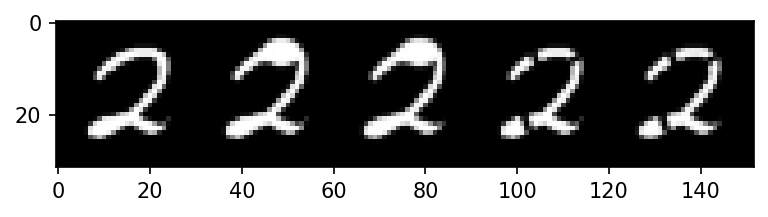

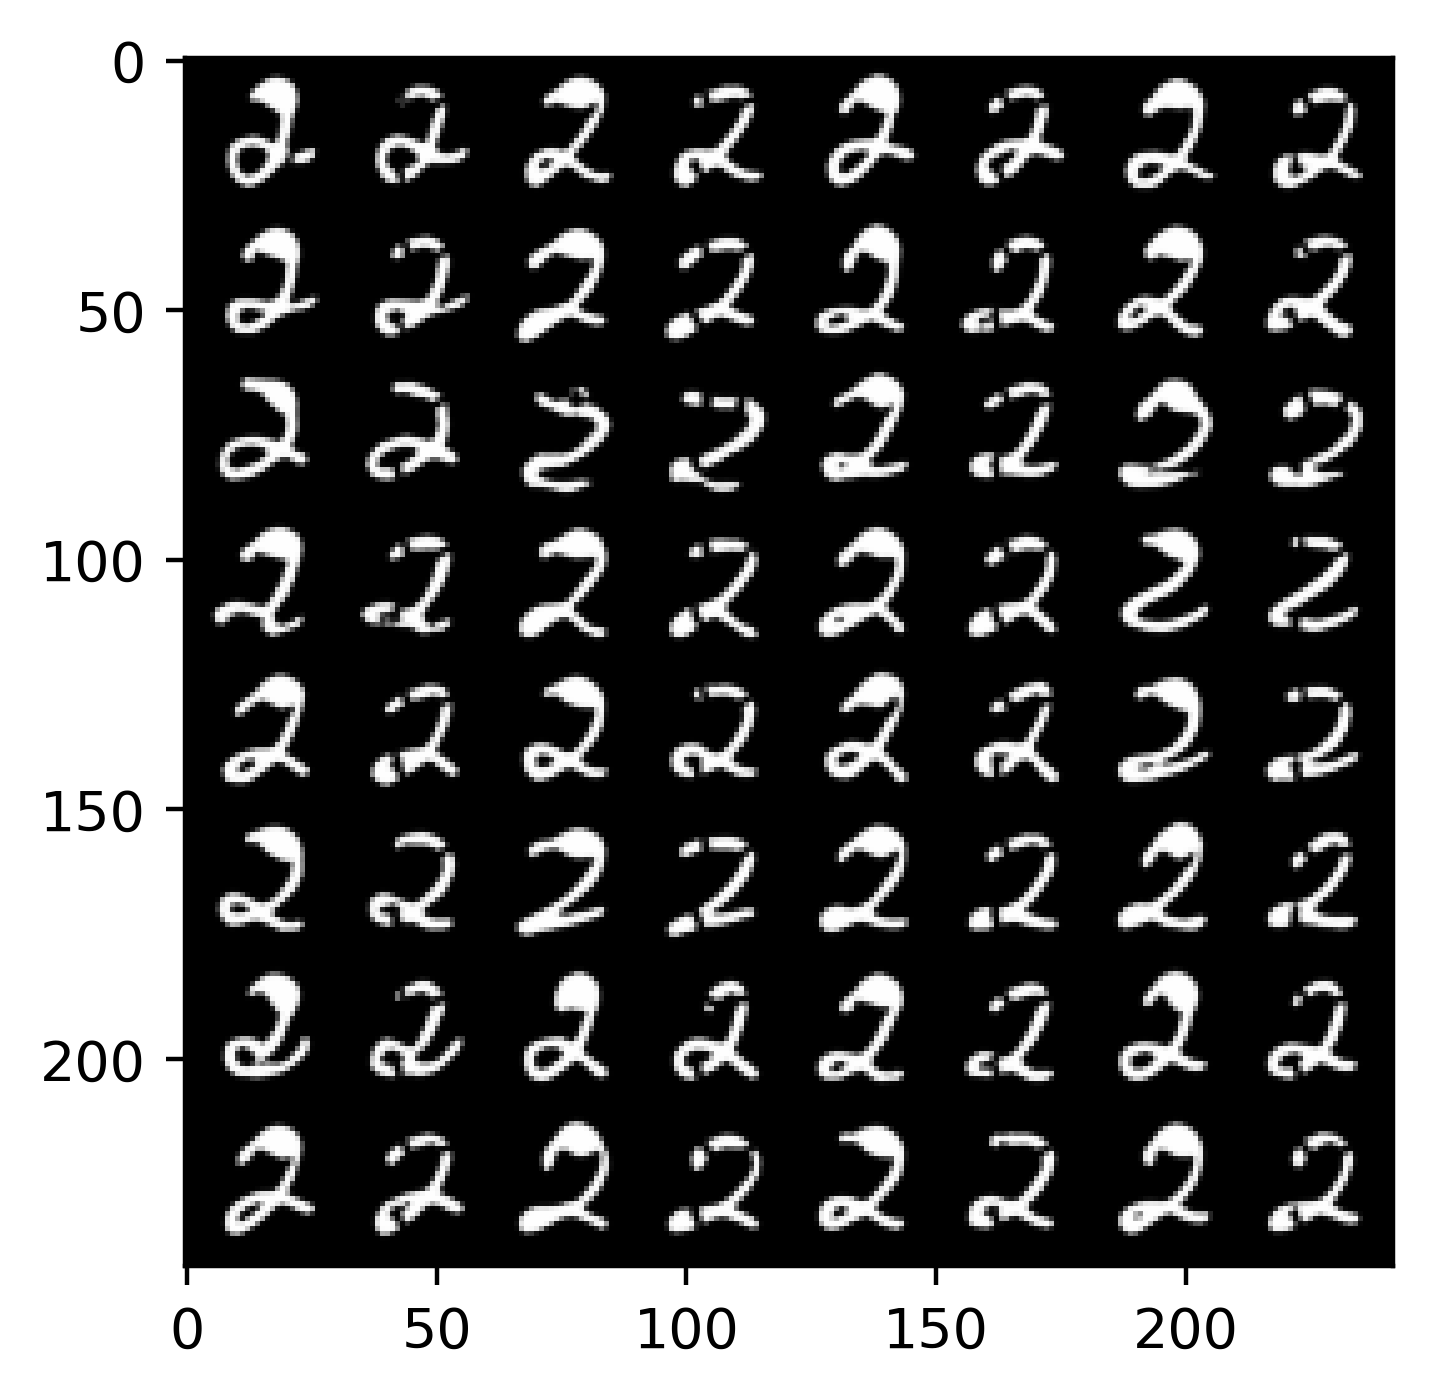

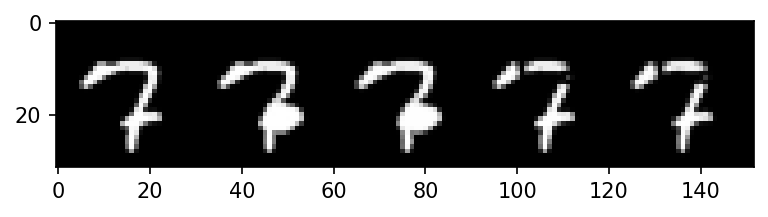

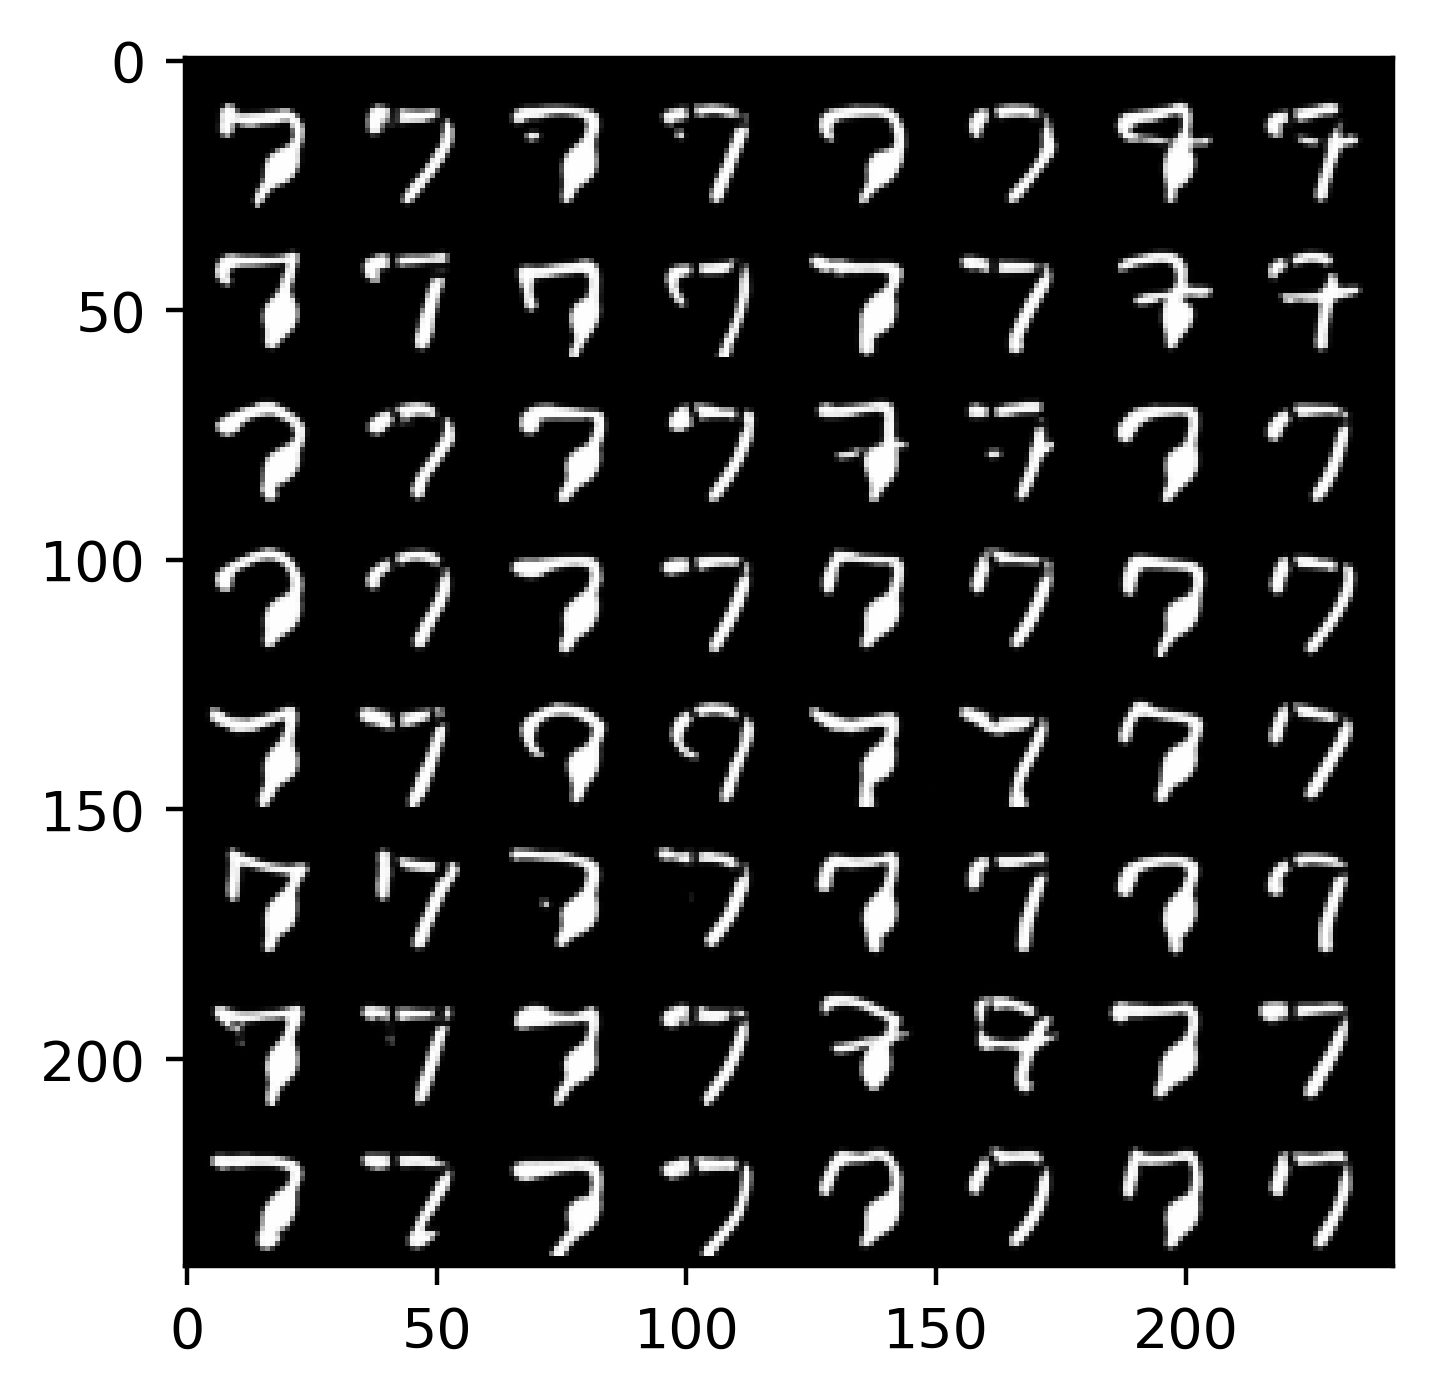

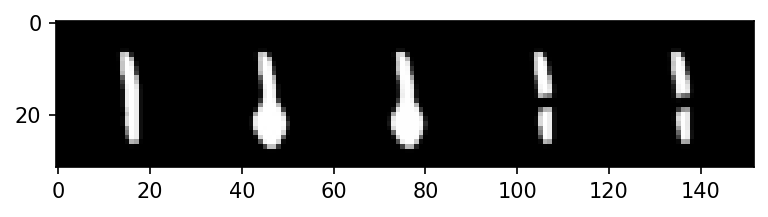

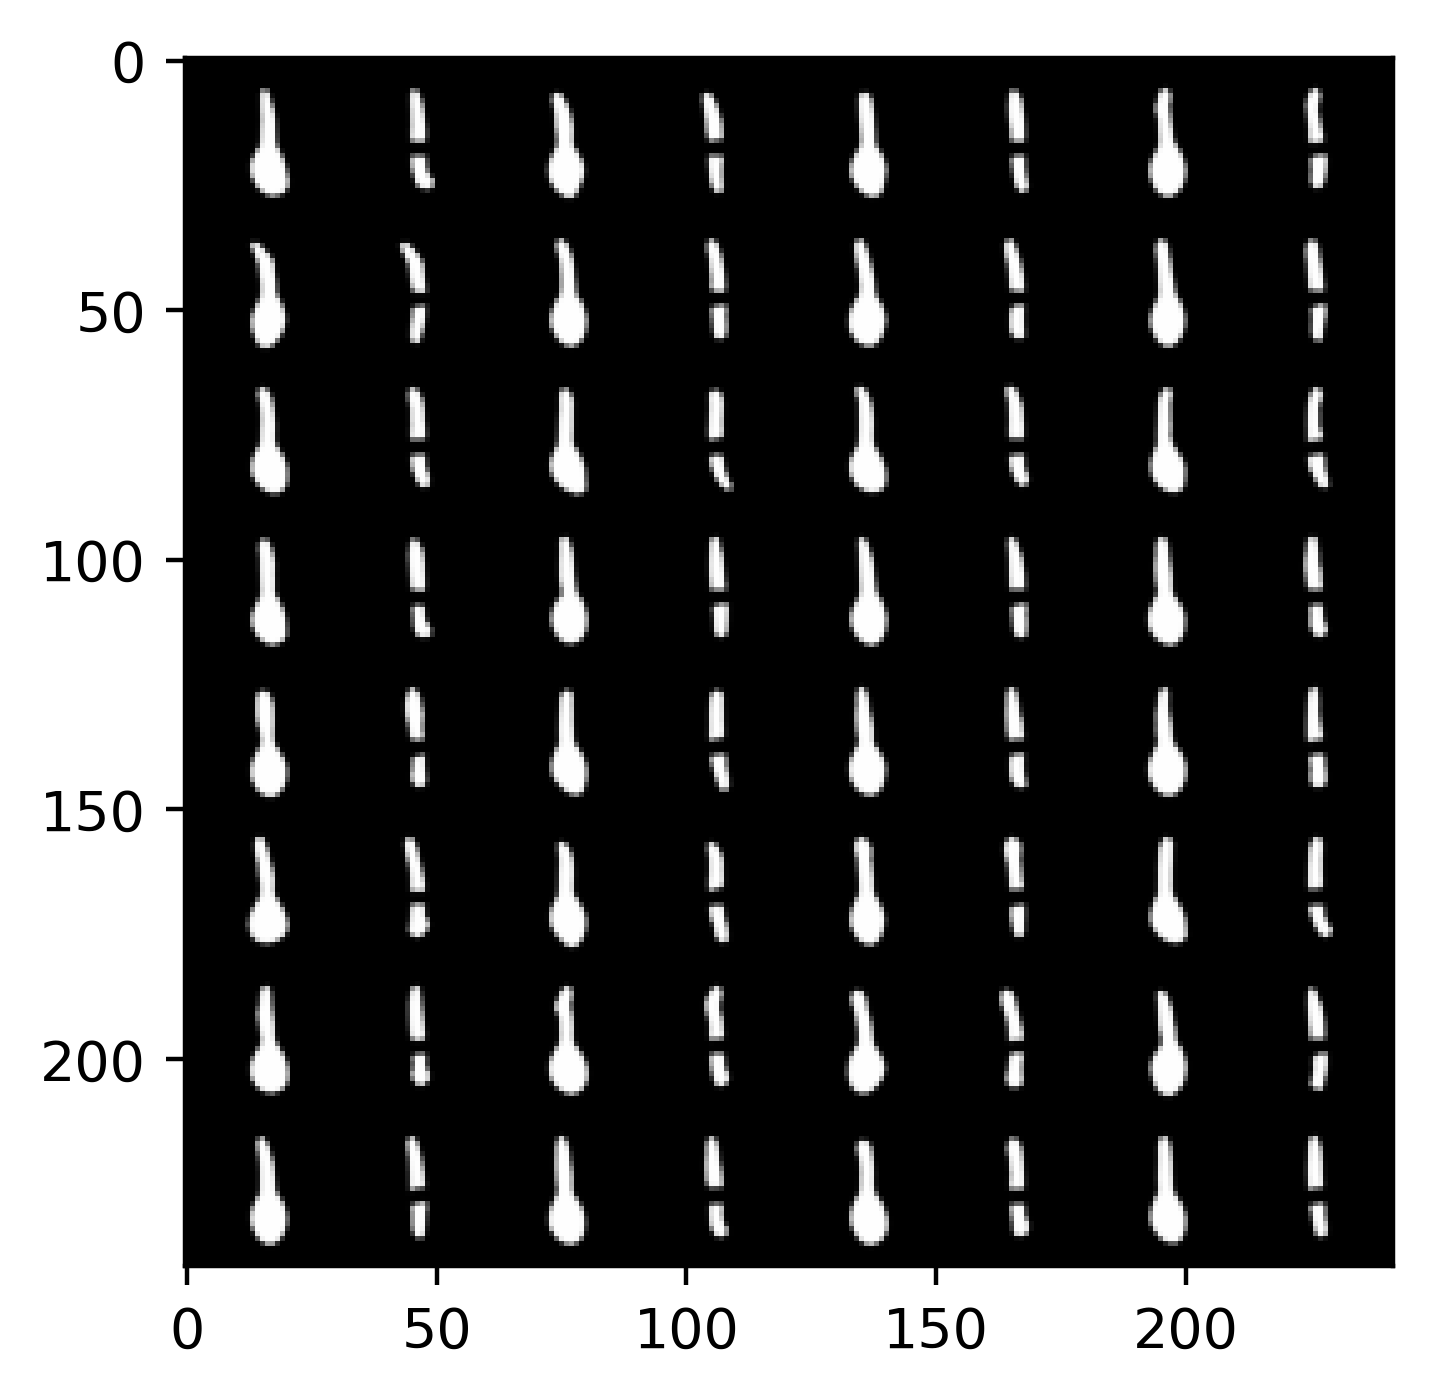

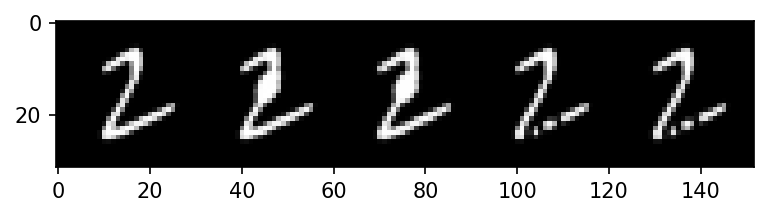

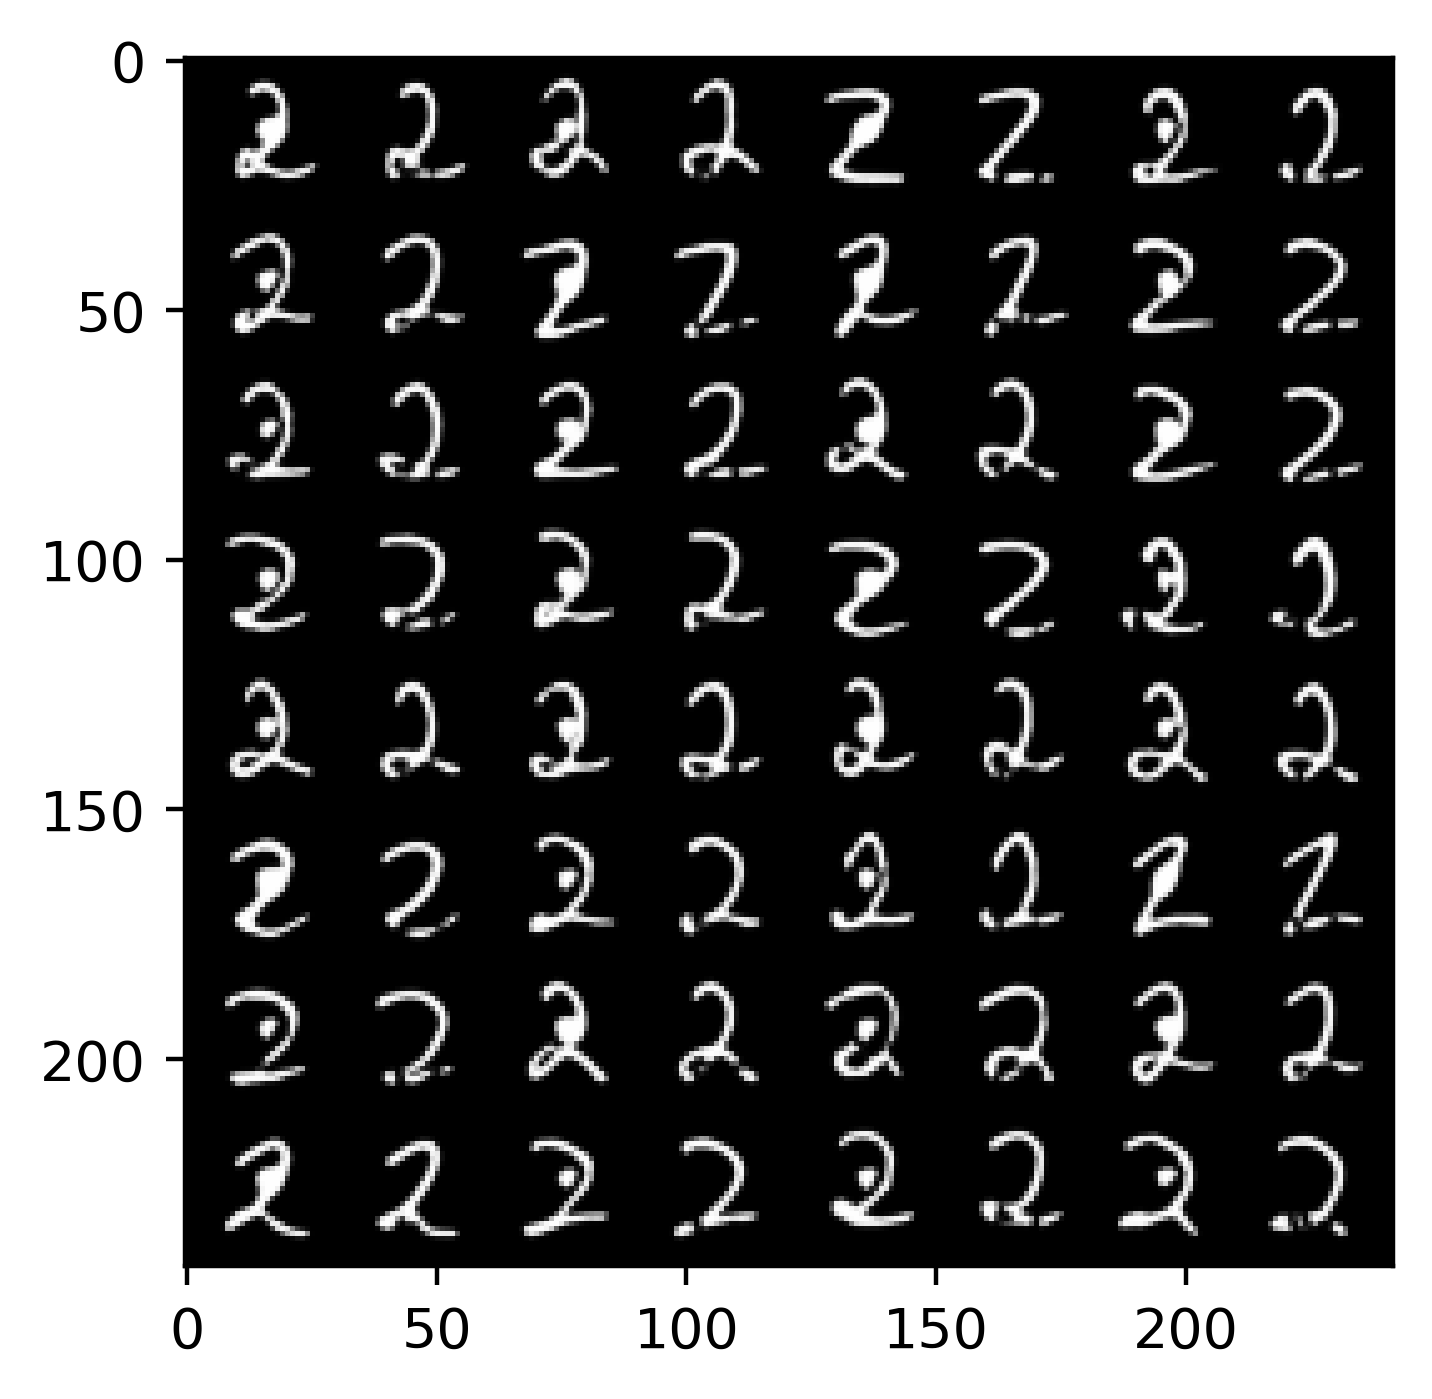

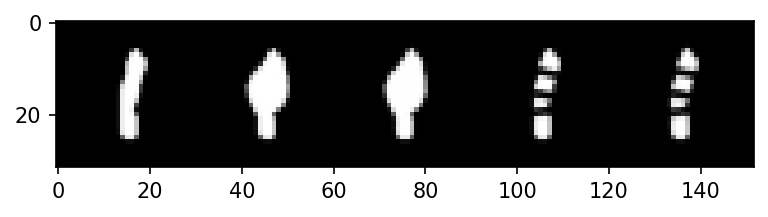

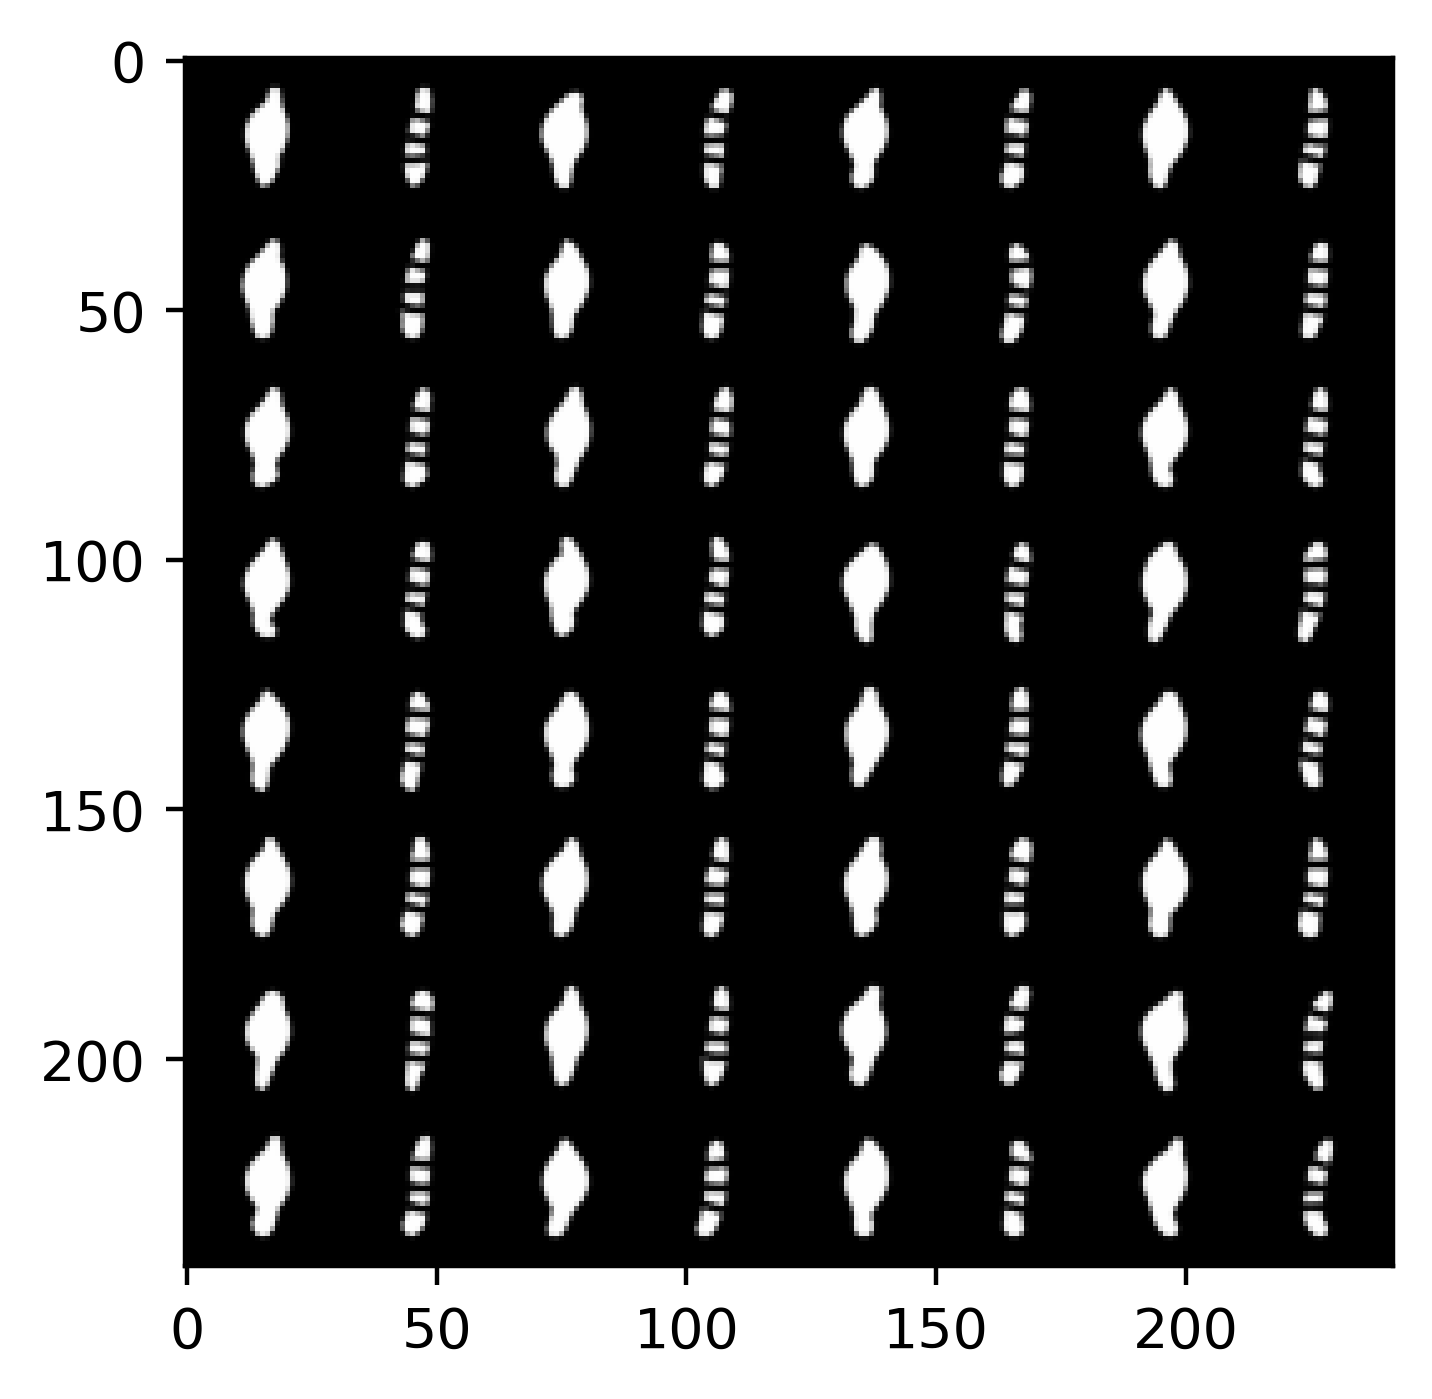

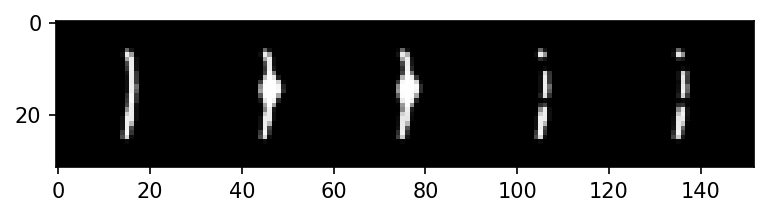

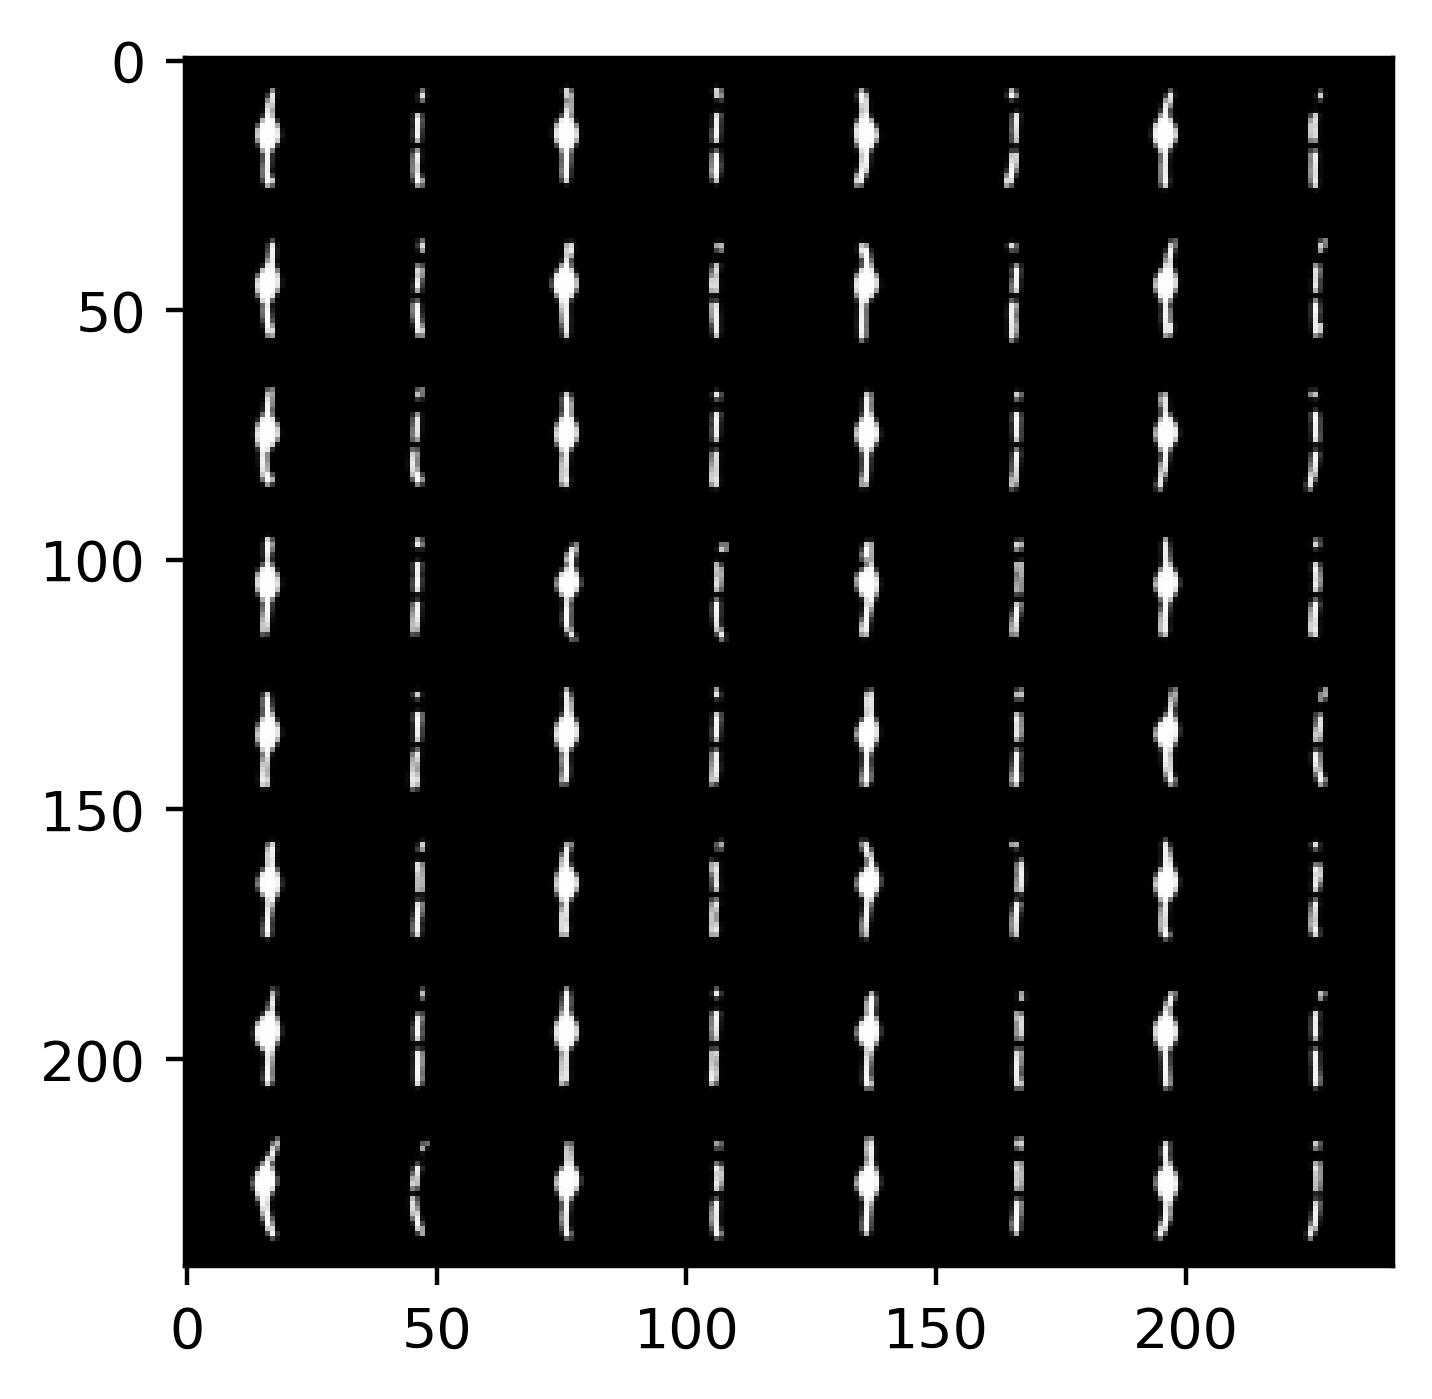

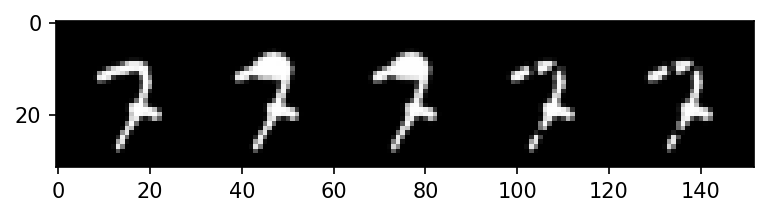

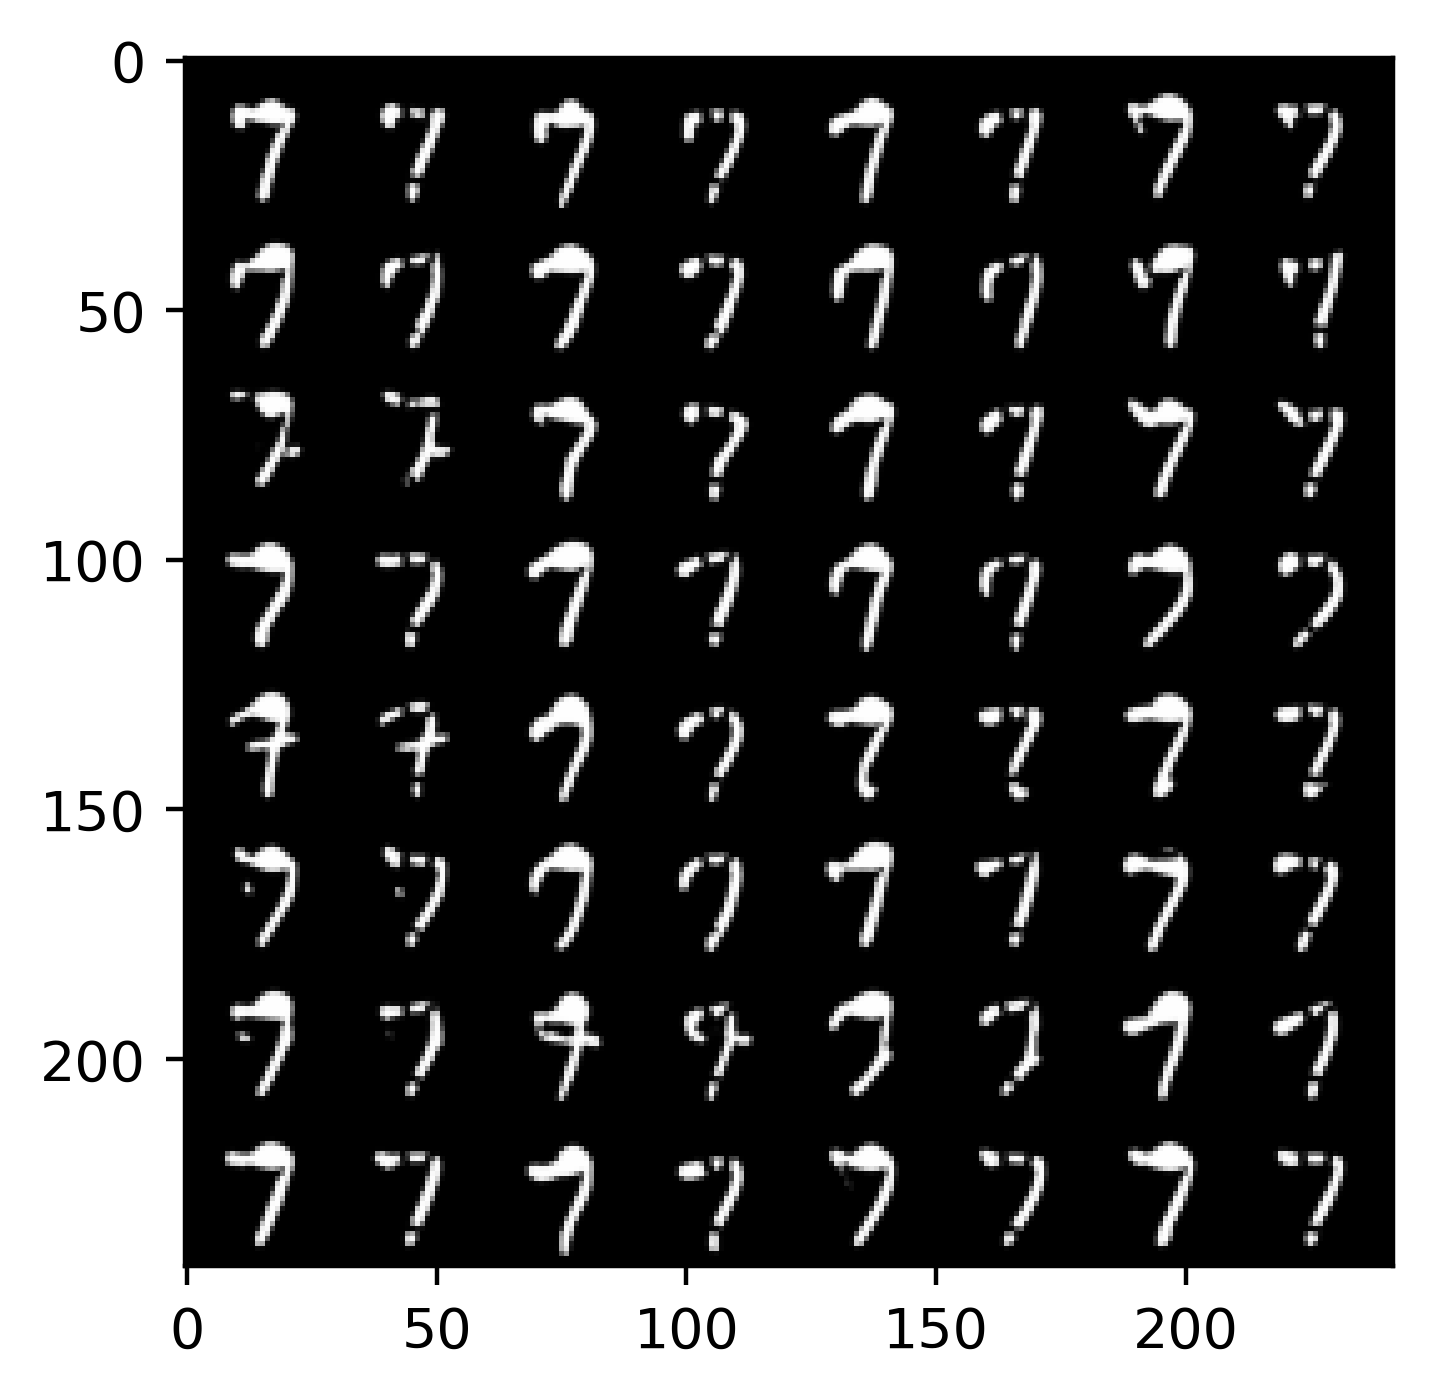

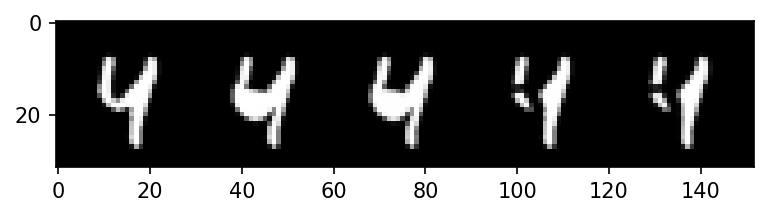

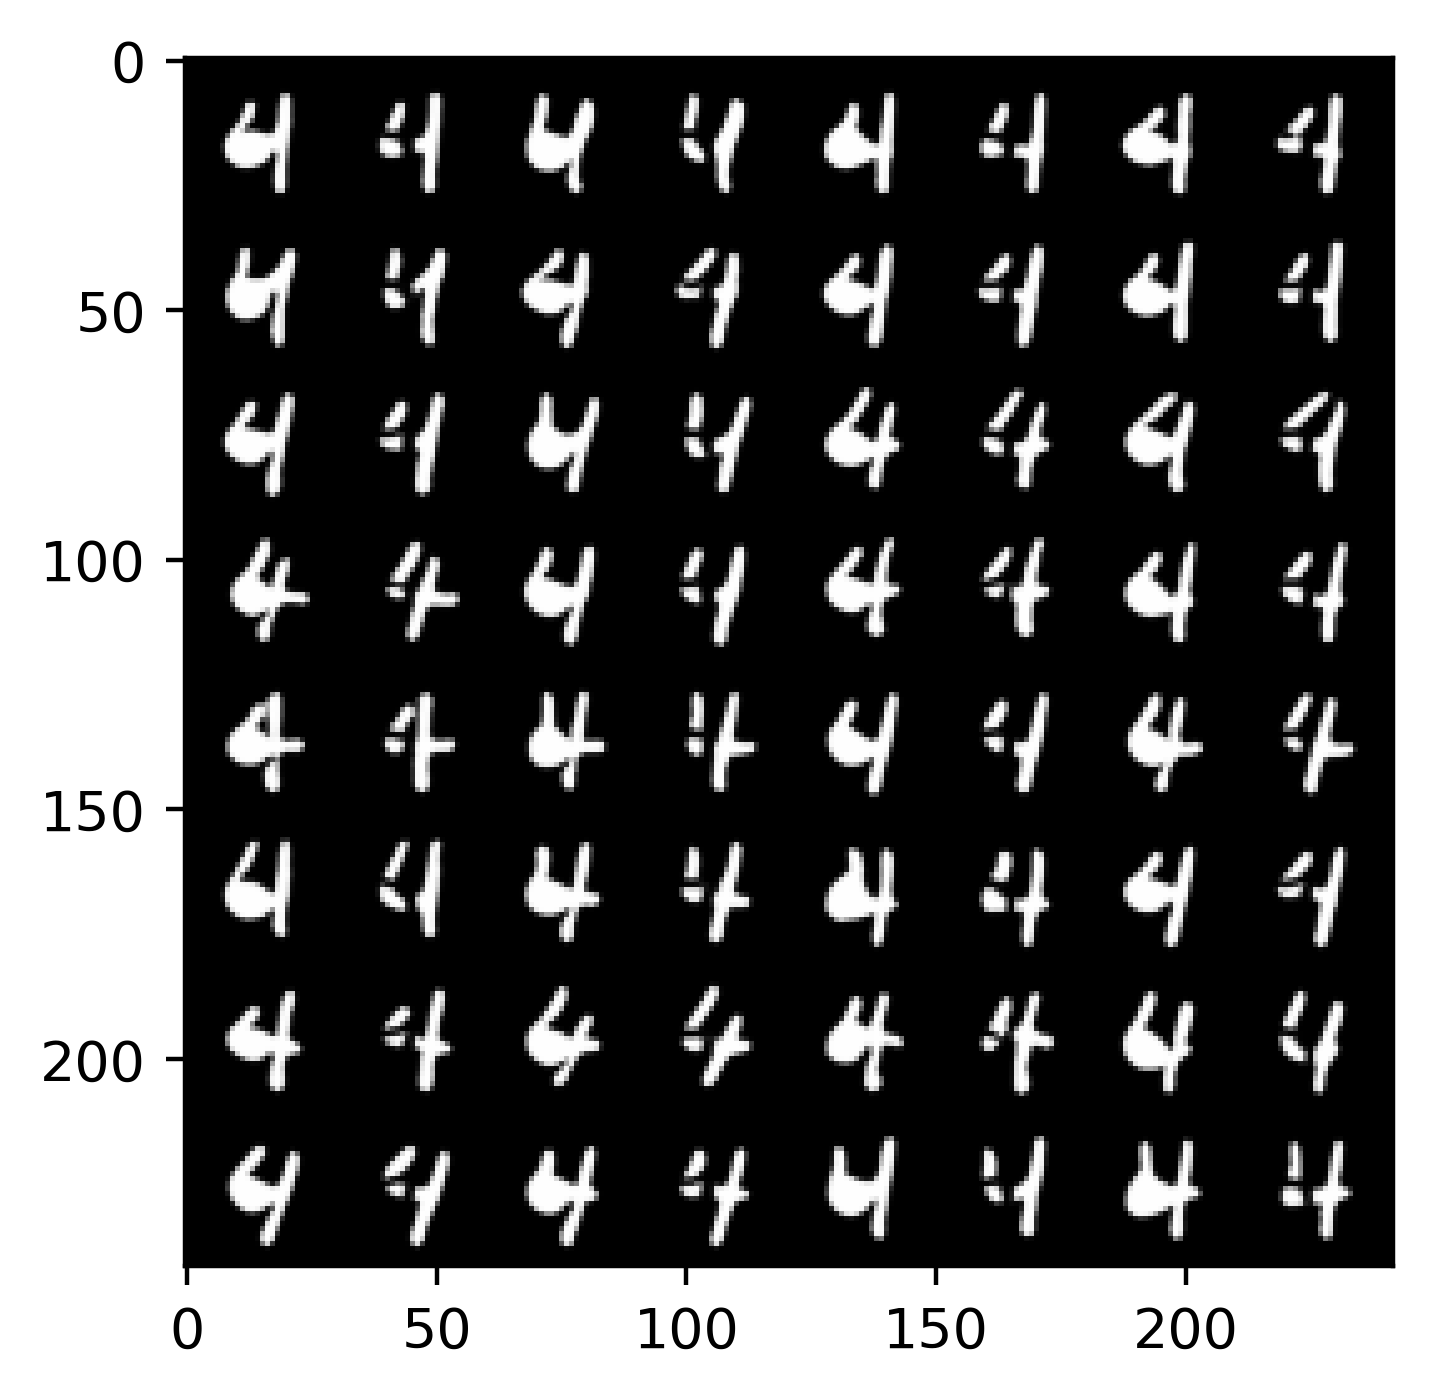

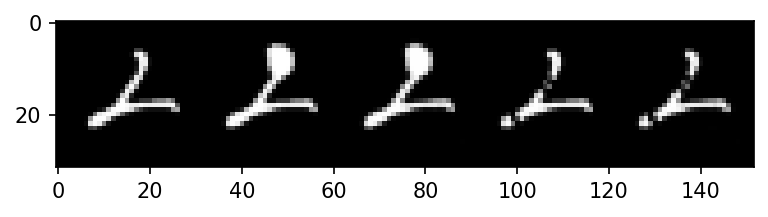

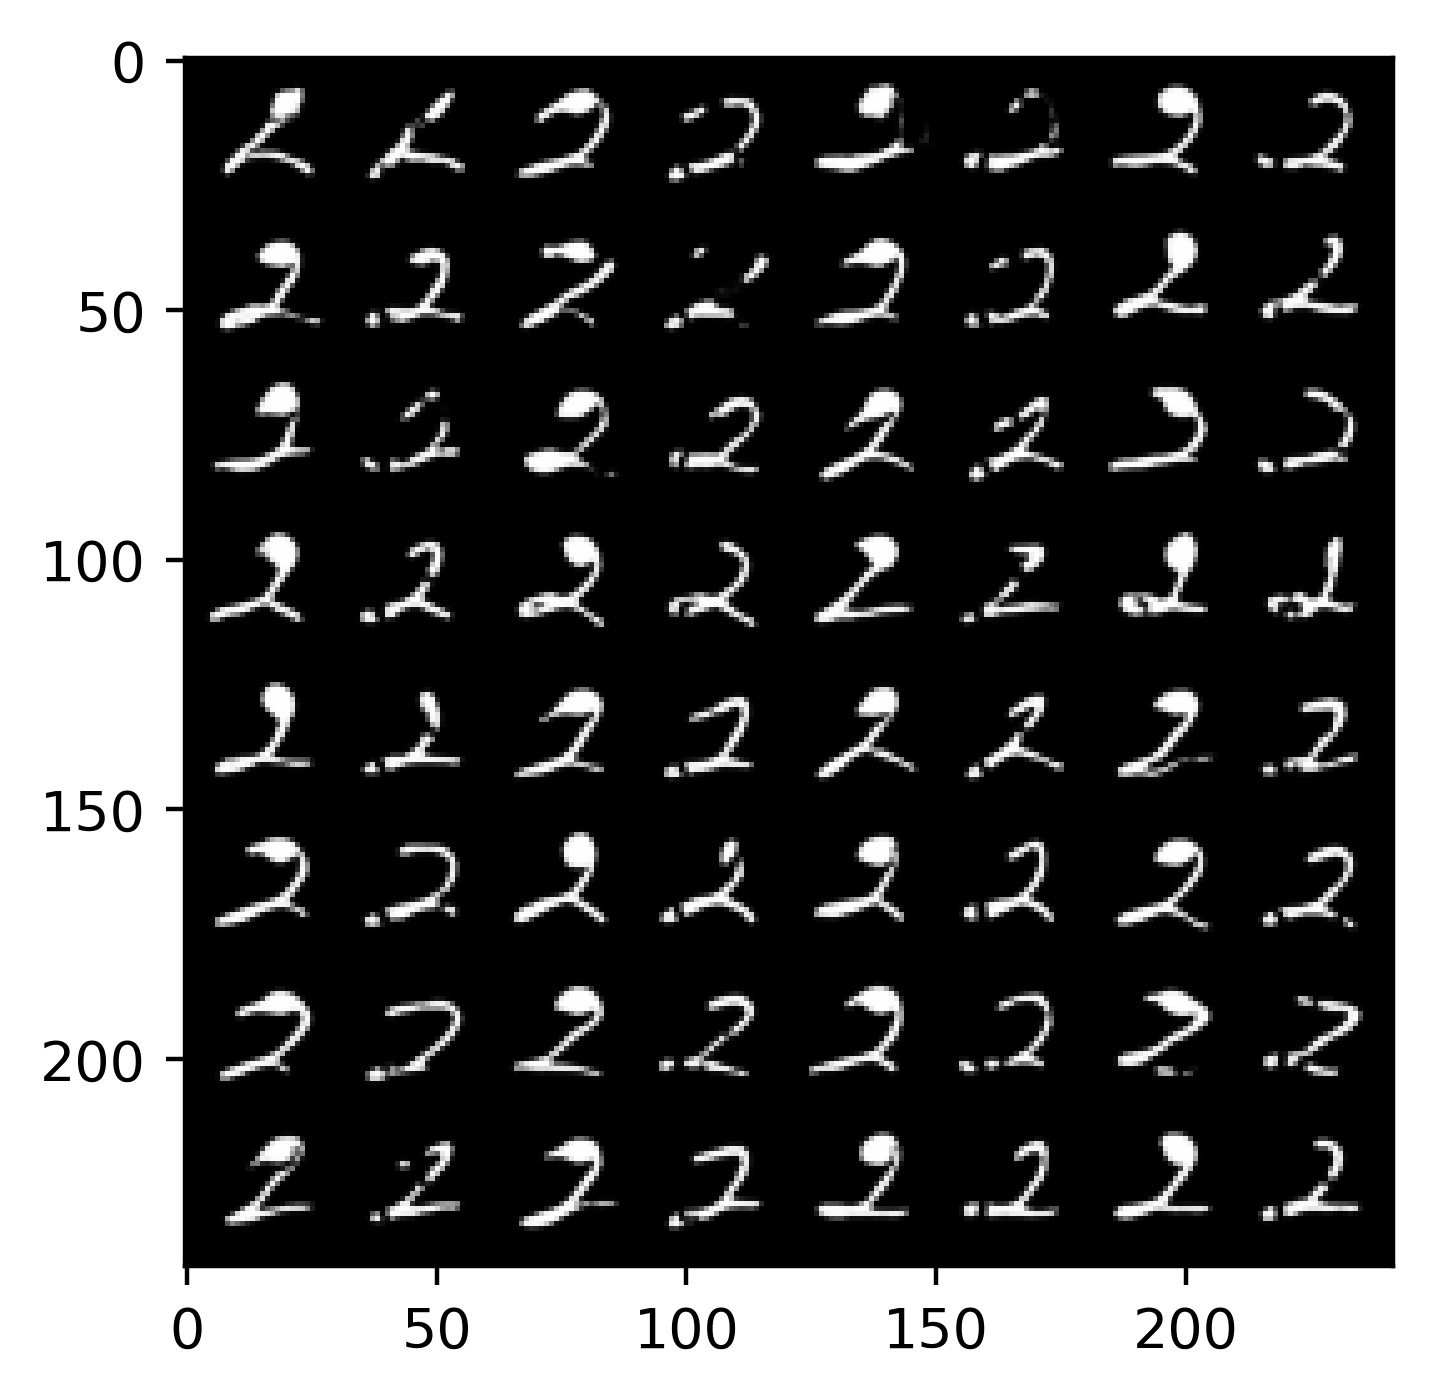

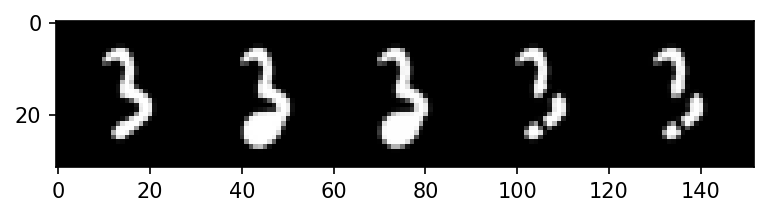

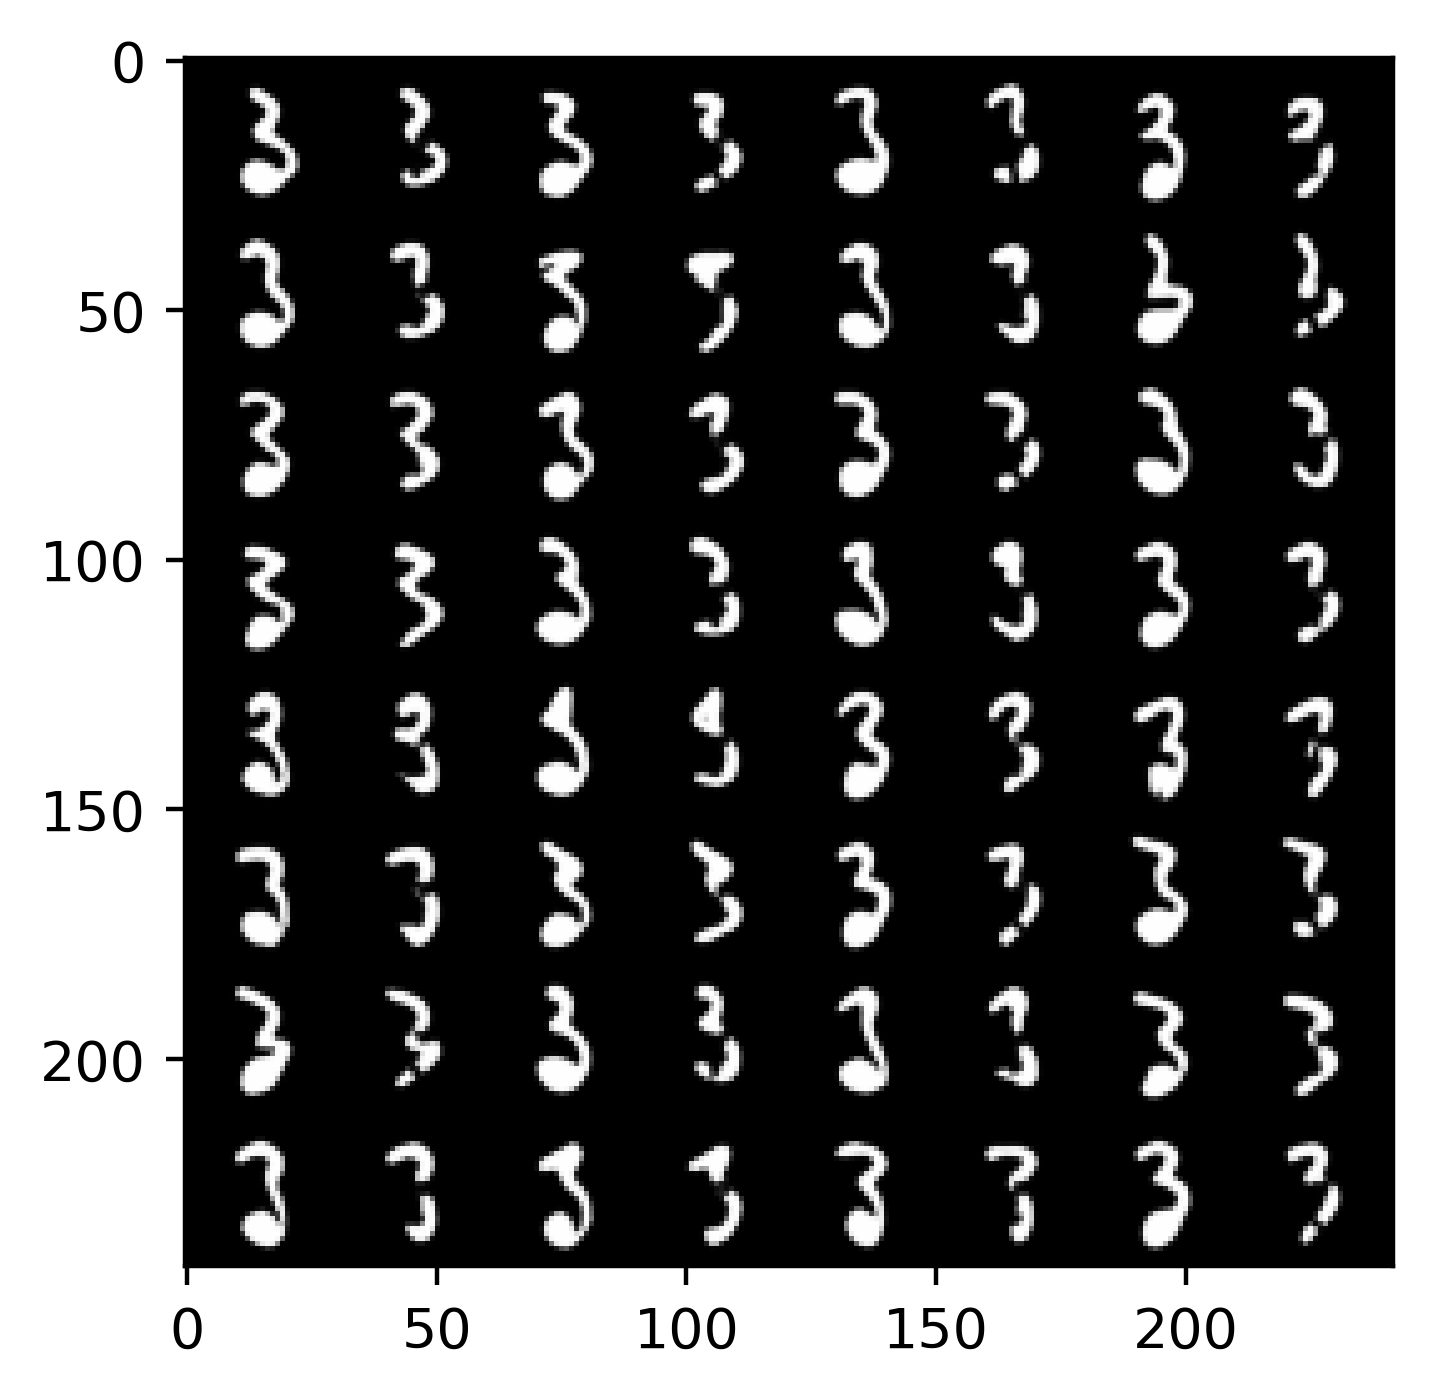

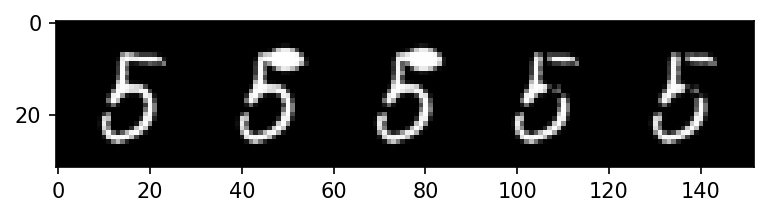

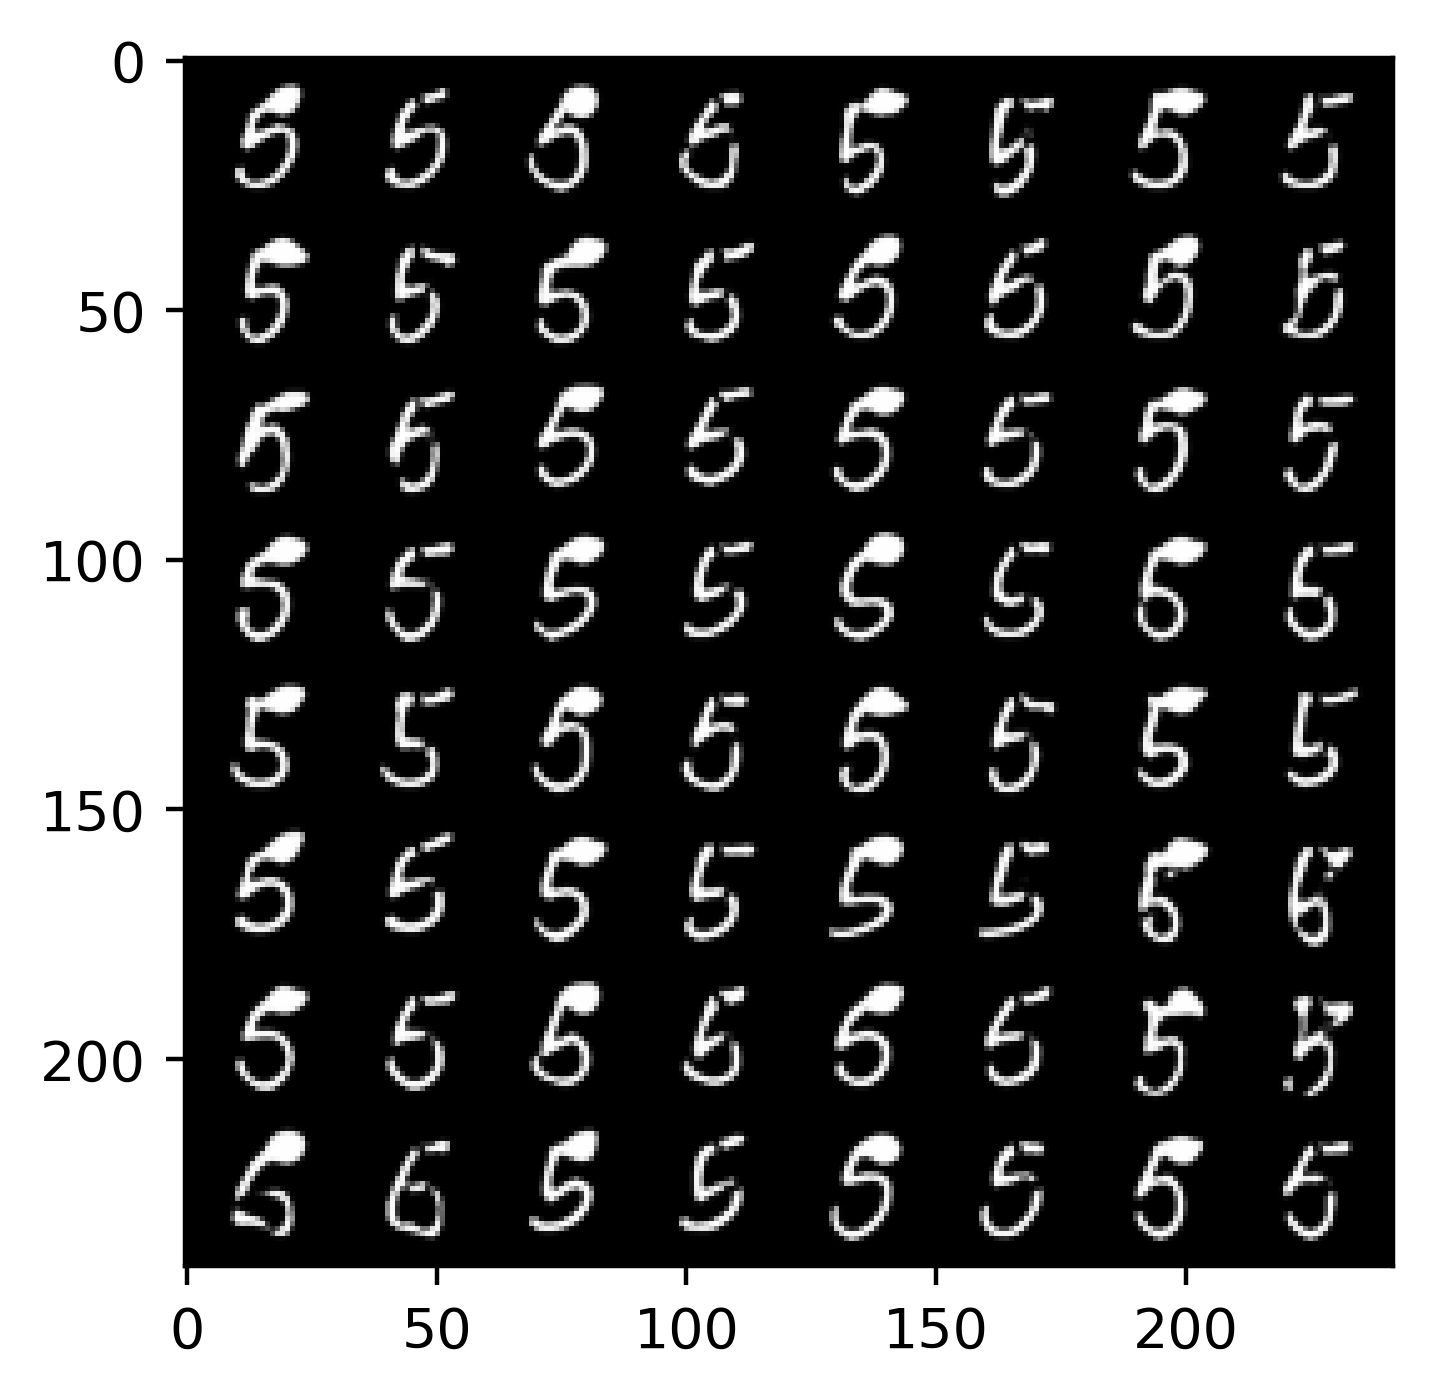

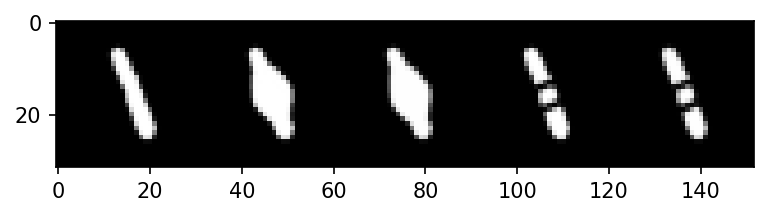

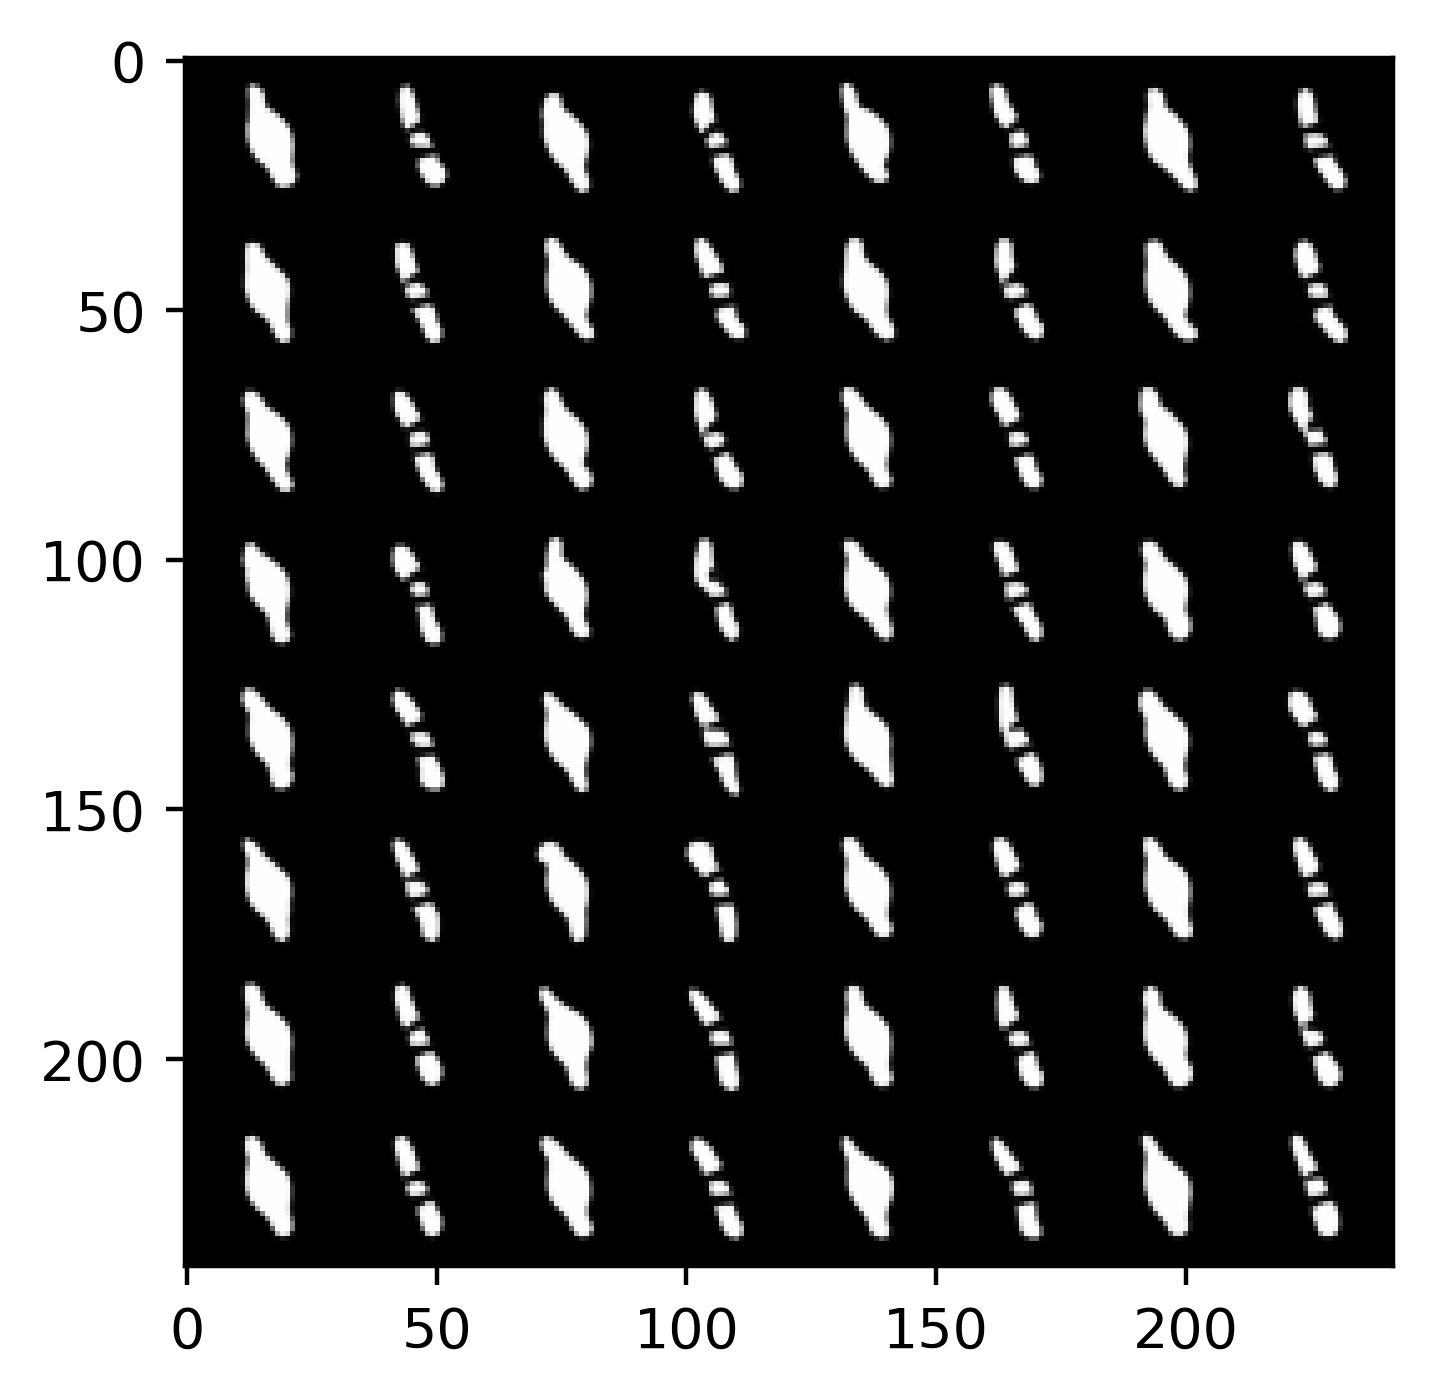

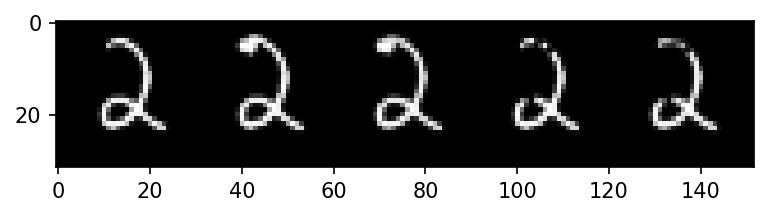

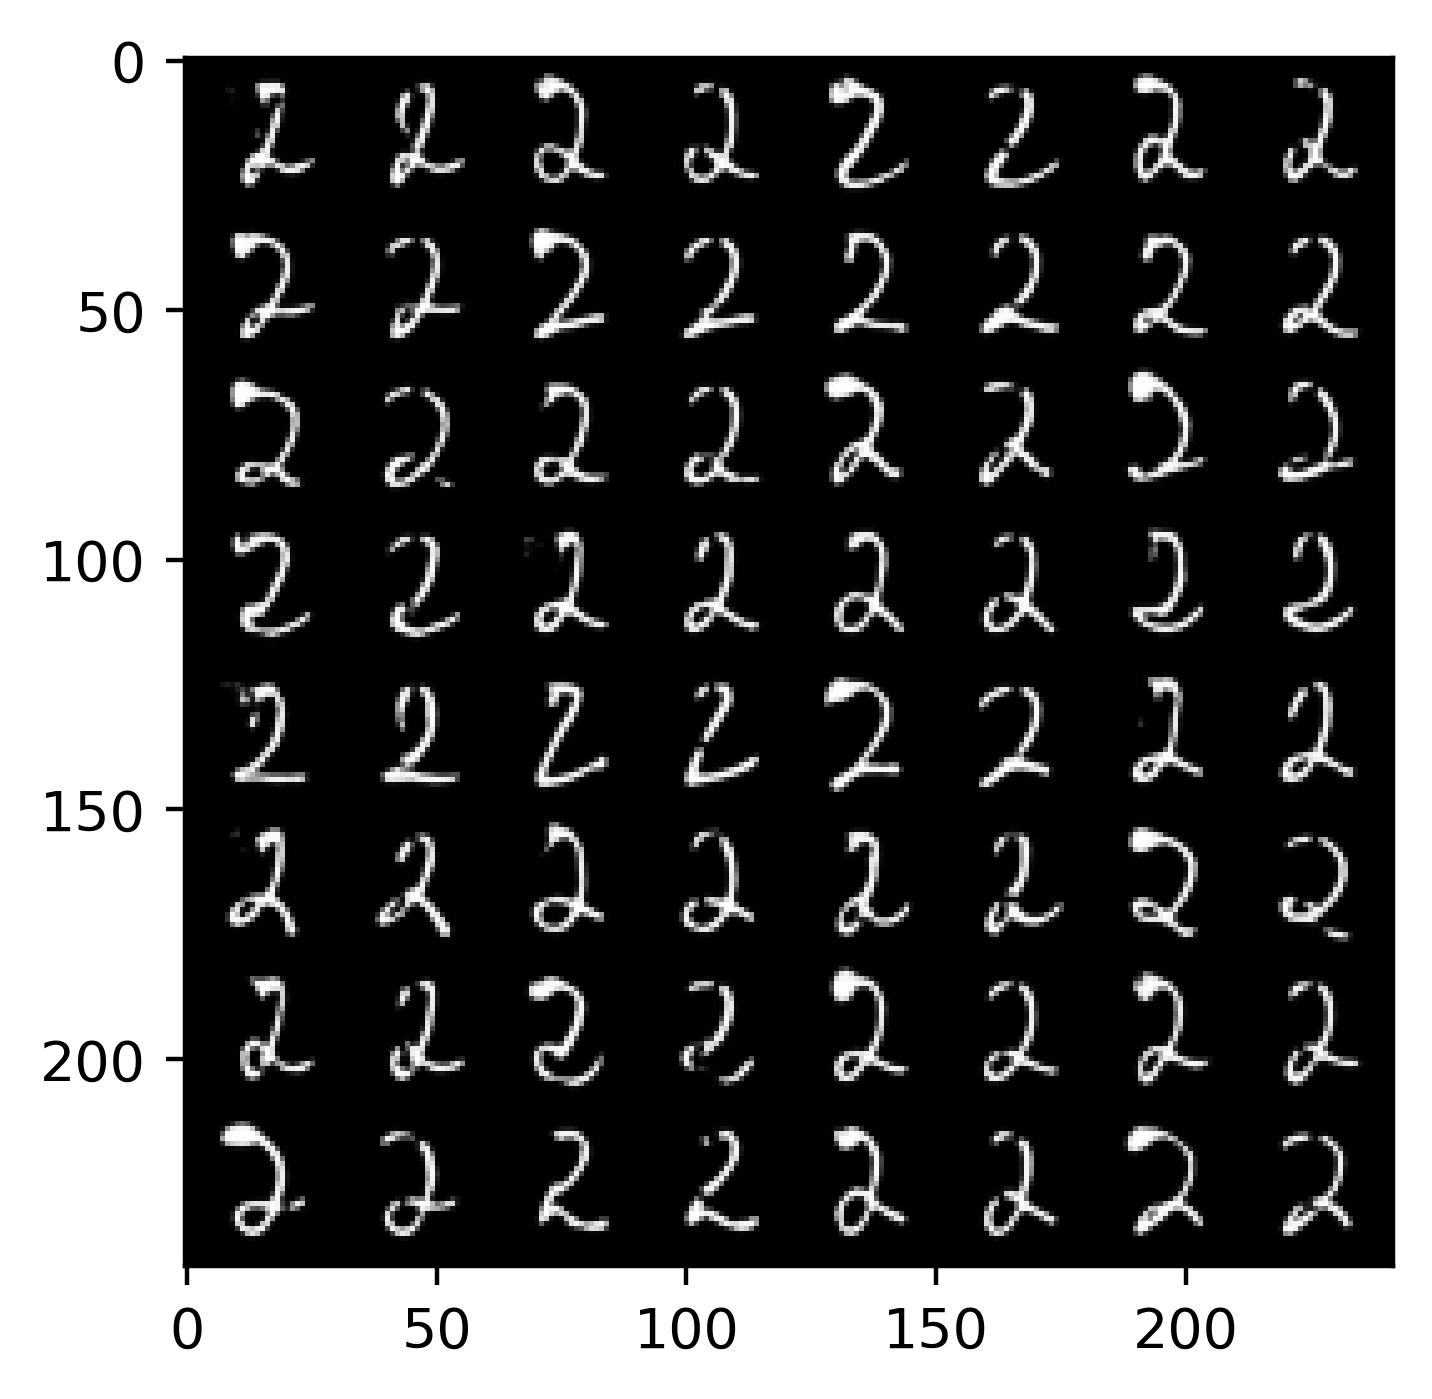

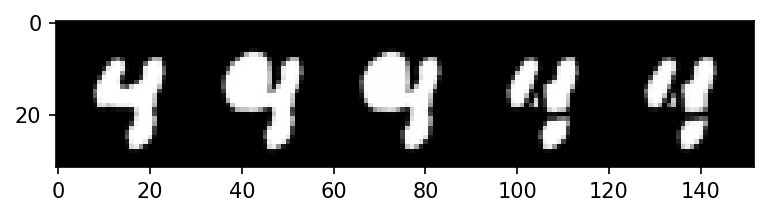

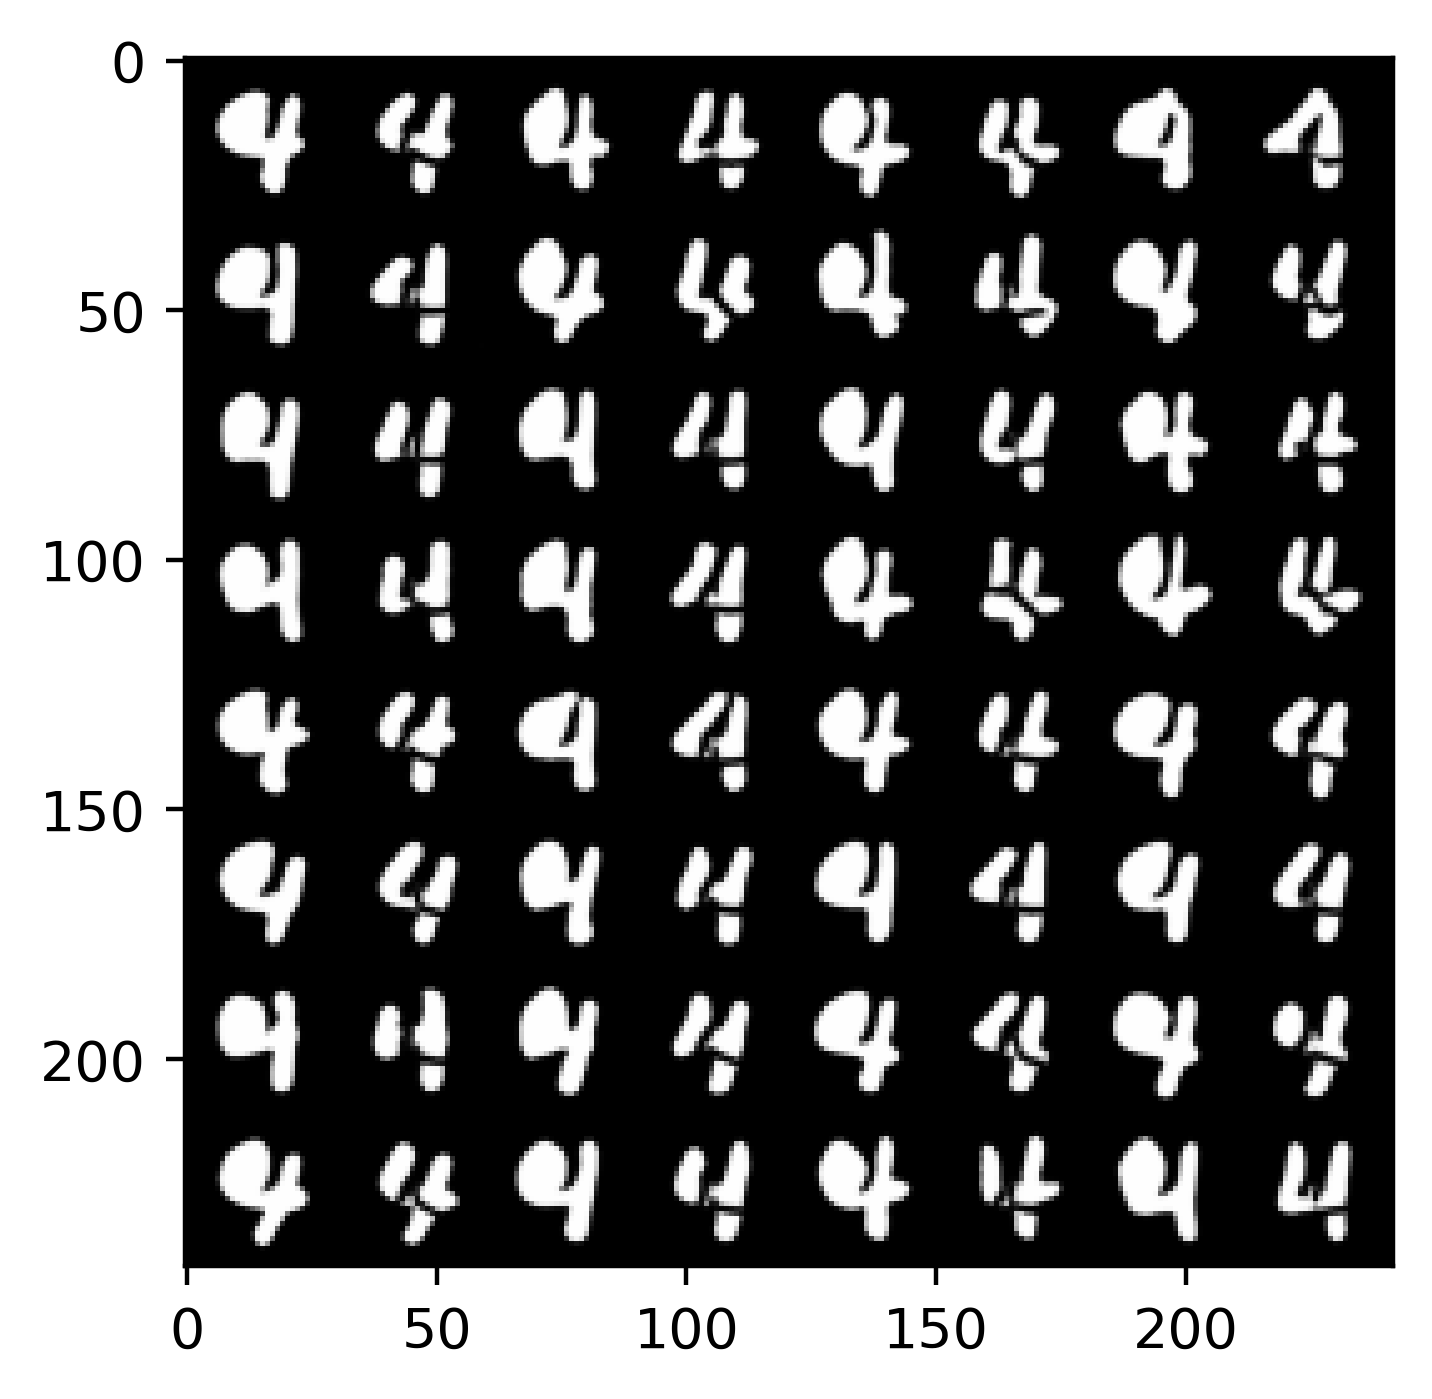

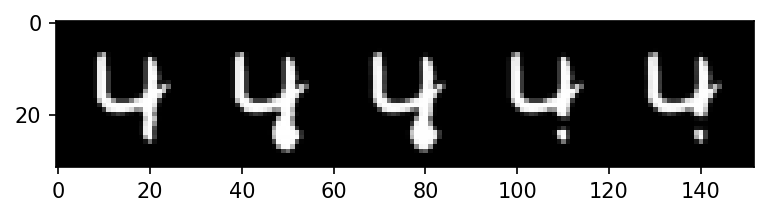

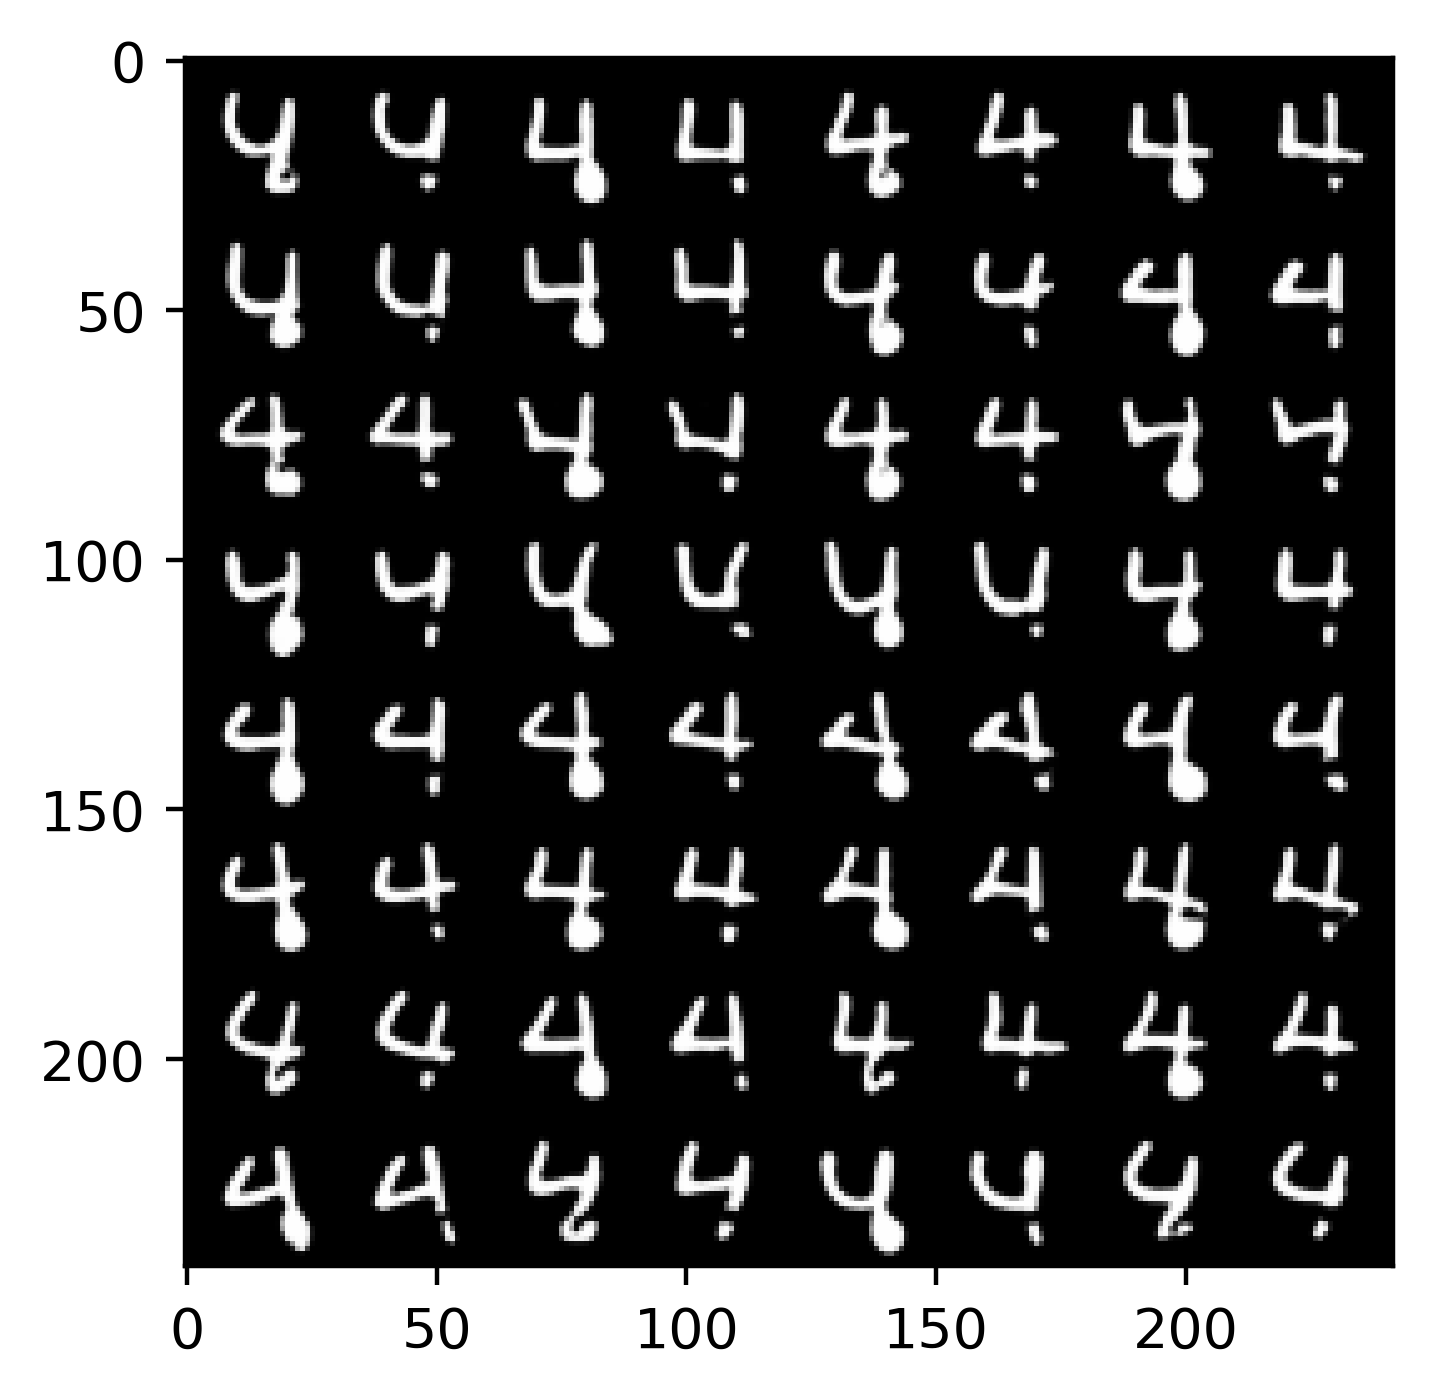

In [11]:
# 1, 35
for sample_idx in range(50):
    exp.show_twinnet_samples(sample_idx, noise_scale=1, num_samples=32, train=False, dpi=400)

Loading datamodule...
Loading dataset from cache
Loading dataset from cache
Loading dataset from cache
Loading dataset from cache
Computing TSNE...


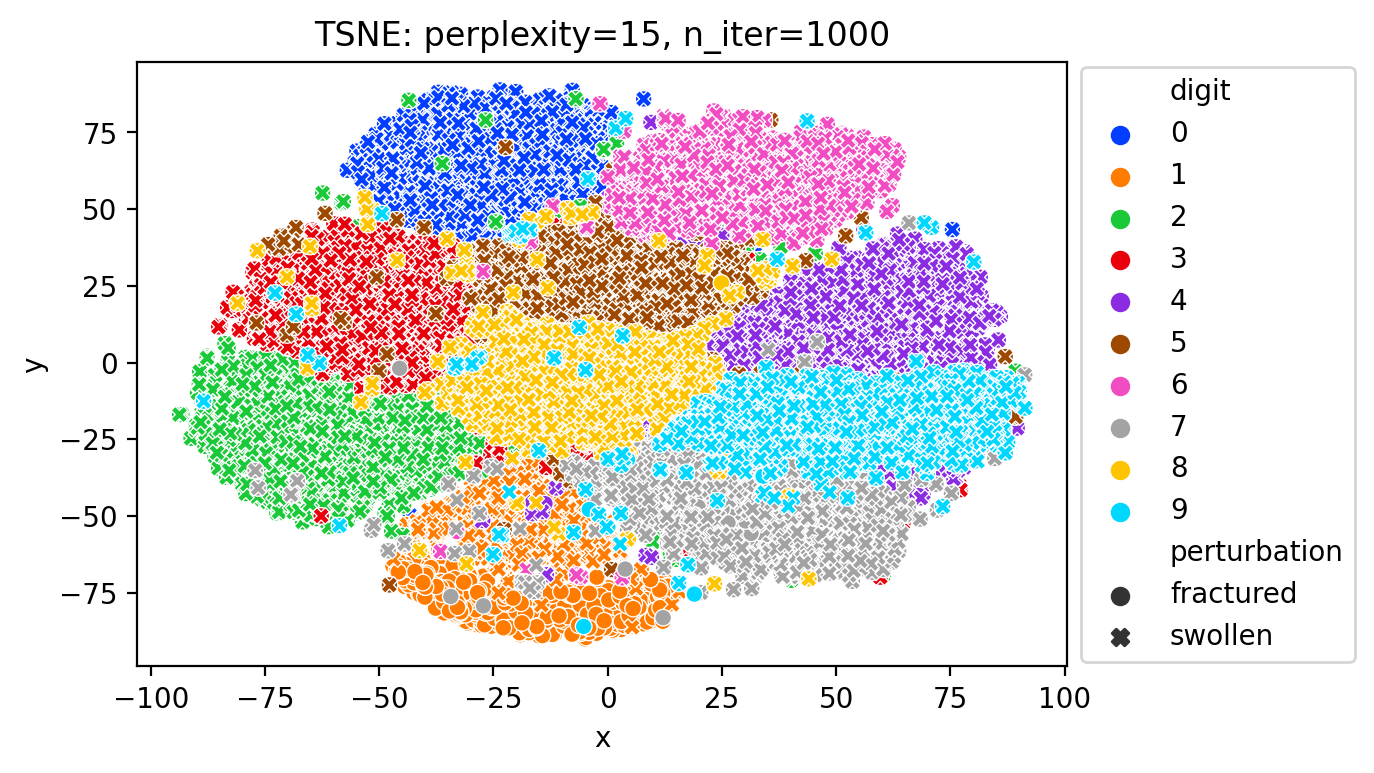

In [5]:
vqvae_exp.plot_vqvae_tsne(perplexity=15, include_perturbations=['swollen', 'fractured'], num_points=10000)

Computing TSNE...


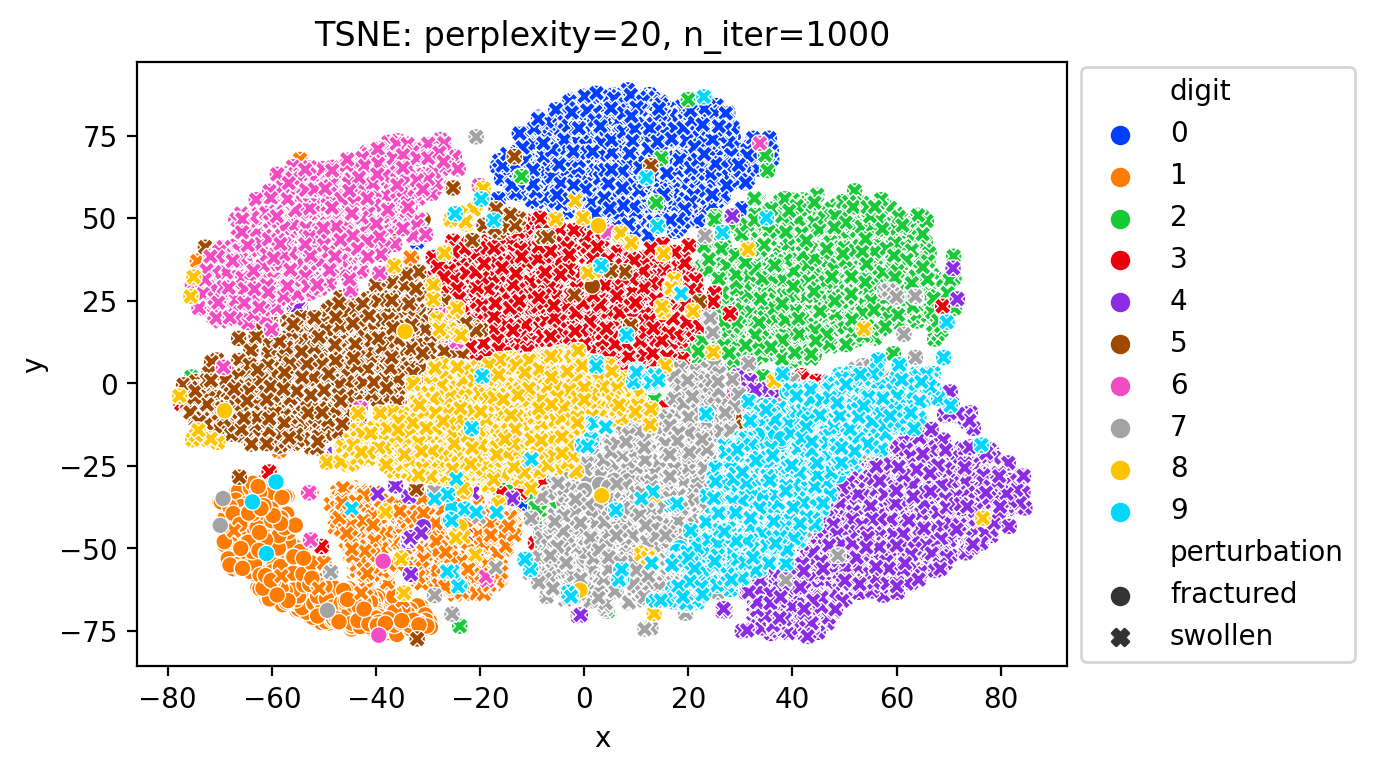

In [10]:
vqvae_exp.plot_vqvae_tsne(perplexity=20, include_perturbations=['swollen', 'fractured'], num_points=10000)

In [8]:
exp.plot_twinnet_tsne(perplexity=15, num_points=10000)

Error: Canceled future for execute_request message before replies were done